In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression  # ← ここを修正
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from scipy import interpolate
import re
# 図のスタイル設定
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

print("ライブラリ読み込み完了")
import japanize_matplotlib


ライブラリ読み込み完了


In [2]:
def make_time_row(df):
    df["time"] = np.arange(0, len(df)) / 100
    return df
def get_first_trigger_segment(df, trigger_col="value", trigger_value=2):
    """
    最初のトリガー値(trigger_value)が立ってから
    次のトリガーが立つ直前までの区間を返す。
    """

    trigger_idx = df.index[df[trigger_col] >= trigger_value].tolist()
    print(trigger_idx)


    if len(trigger_idx) == 0:
        return None  # トリガーが無い

    # 最初のトリガー開始
    start = trigger_idx[0]

    # 次のトリガーがあるか？
    # if len(trigger_idx) >= 2:
        # end = trigger_idx[-1]
    # else:
    end = df.index[-1]  # トリガーが1回だけの場合、最後まで
    
    print(start,end)

    return df.loc[start:end].reset_index(drop=True)

def fix_columns(df):
    cleaned = [re.sub(r'\.\d+$', '', c) for c in df.columns]  # .1 や .2 を除去
    new_cols = []
    seen = {}

    for col in cleaned:
        if col not in seen:
            seen[col] = 1
            new_cols.append(f"{col}_1")
        else:
            seen[col] += 1
            new_cols.append(f"{col}_{seen[col]}")

    df.columns = new_cols
    return df

def estimate_sampling_rate(df):
    t = df['time'].values
    # 時刻差分（dt）を計算
    dt = np.diff(t)
    # 正の値のみ（たまに逆順やゼロが混ざるため）
    dt = dt[dt > 0]
    # メジアンをサンプリング周期とする
    dt_med = np.median(dt)
    # sampling rate [Hz]
    fs = 1.0 / dt_med
    return fs, dt_med



def plot_shifted_cop(df, shift_samples):
    # シフトした列を追加
    df_plot = df.copy()
    df_plot["COP_Y_shift"] = df_plot["COP_Y"].shift(shift_samples)
    df_plot["COP_X_shift"] = df_plot["COP_X"].shift(shift_samples)

    # === COP_Y vs 圧力中心行 ===
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(1, 1, 1)
    ax2 = ax1.twinx()
    
    ax1.plot(df_plot.time, df_plot['COP_Y_shift'], color='blue', label=f'COP_Y (shift={shift_samples})')
    ax2.plot(df_plot.time, df_plot['圧力中心行_2'], color='orange', label='圧力中心行')

    ax1.set_title(f"COP_Y Shifted by {shift_samples} samples")
    ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
    ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
    plt.show()

    # === COP_X vs 圧力中心列 ===
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(1, 1, 1)
    ax2 = ax1.twinx()
    
    ax1.plot(df_plot.time, df_plot['COP_X_shift'], color='blue', label=f'COP_X (shift={shift_samples})')
    ax2.plot(df_plot.time, df_plot['圧力中心列_2'], color='orange', label='圧力中心列')

    ax1.set_title(f"COP_X Shifted by {shift_samples} samples")
    ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
    ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
    plt.show()

    return df_plot
# df_shift = plot_shifted_cop(df_all, shift_samples=10)


In [3]:
from scipy.signal import butter, filtfilt

# サンプルDataFrameの作成
def create_sample_data():
    np.random.seed(42)
    fs = 100  # サンプリング周波数 [Hz]
    t = np.arange(0, 10, 1/fs)
    
    # 信号生成
    clean_signal = 2 * np.sin(2 * np.pi * 1 * t)  # 1Hzの信号
    noise = 0.5 * np.random.normal(0, 1, len(t))  # ノイズ
    
    df = pd.DataFrame({
        'time': t,
        'original_signal': clean_signal,
        'noisy_signal': clean_signal + noise,
        'sensor_A': clean_signal + noise + 0.3 * np.sin(2 * np.pi * 5 * t),
        'sensor_B': clean_signal * 0.8 + noise * 1.2,
        'category': np.random.choice(['A', 'B', 'C'], len(t))
    })
    return df


# 双方向ローパスフィルタ関数
def butter_lowpass_filter(data, cutoff, fs, order=4):
    """
    双方向ローパスフィルタを適用
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# 特定の列にフィルタを適用
def apply_filter_to_column(df, column_name, cutoff_freq, sampling_freq, order=4):
    """
    DataFrameの特定の列にフィルタを適用
    """
    filtered_data = butter_lowpass_filter(
        df[column_name].values, 
        cutoff_freq, 
        sampling_freq, 
        order
    )
    
    # 新しい列名を作成
    new_column_name = f"{column_name}_filtered"
    df[new_column_name] = filtered_data
    
    return df, new_column_name


class DataFrameLowpassFilter:


    def __init__(self, sampling_freq, cutoff_freq, order=4):
        self.sampling_freq = sampling_freq
        self.cutoff_freq = cutoff_freq
        self.order = order
    
    def _design_filter(self):
        """フィルタ係数を設計"""
        nyquist = 0.5 * self.sampling_freq
        normal_cutoff = self.cutoff_freq / nyquist
        b, a = butter(self.order, normal_cutoff, btype='low', analog=False)
        return b, a
    
    def filter_column(self, data):
        """単一のデータ列にフィルタを適用"""
        b, a = self._design_filter()
        return filtfilt(b, a, data)
    
    def filter_dataframe(self, df, columns, suffix='_filtered'):
        """
        DataFrameの複数列にフィルタを適用
        
        Parameters:
        df: pandas DataFrame
        columns: フィルタ適用する列名のリスト
        suffix: 新しい列名に追加する接尾辞
        """
        df_filtered = df.copy()
        
        for col in columns:
            if col in df.columns:
                filtered_data = self.filter_column(df[col].values)
                new_col_name = f"{col}{suffix}"
                df_filtered[new_col_name] = filtered_data
            else:
                print(f"警告: 列 '{col}' はDataFrameに存在しません")
        
        return df_filtered

# # 使用例
# filter_processor = DataFrameLowpassFilter(
#     sampling_freq=100, 
#     cutoff_freq=5, 
#     order=4
# )

# # 複数列を一度にフィルタリング
# columns_to_process = ['noisy_signal', 'sensor_A', 'sensor_B']
# df_filtered = filter_processor.filter_dataframe(df, columns_to_process)

# print(df_filtered.columns.tolist())

In [58]:
data_info = pd.read_excel("info.xlsx")
data_info

sub                                               seat  \
0   A  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...   
1   B  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...   
2   A  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...   
3   C  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...   
4   E  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...   
5   G  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...   

                                                 cop  \
0  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...   
1  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...   
2  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...   
3  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...   
4  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...   
5  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...   

                                               pedal  \
0  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...   
1  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...   
2  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...   
3  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...   
4  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...   
5  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...   

                                               steer label  
0  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...    2F  
1  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...    2F  
2  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...    3F  
3  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...    3F  
4  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...    3F  
5  C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...    3F

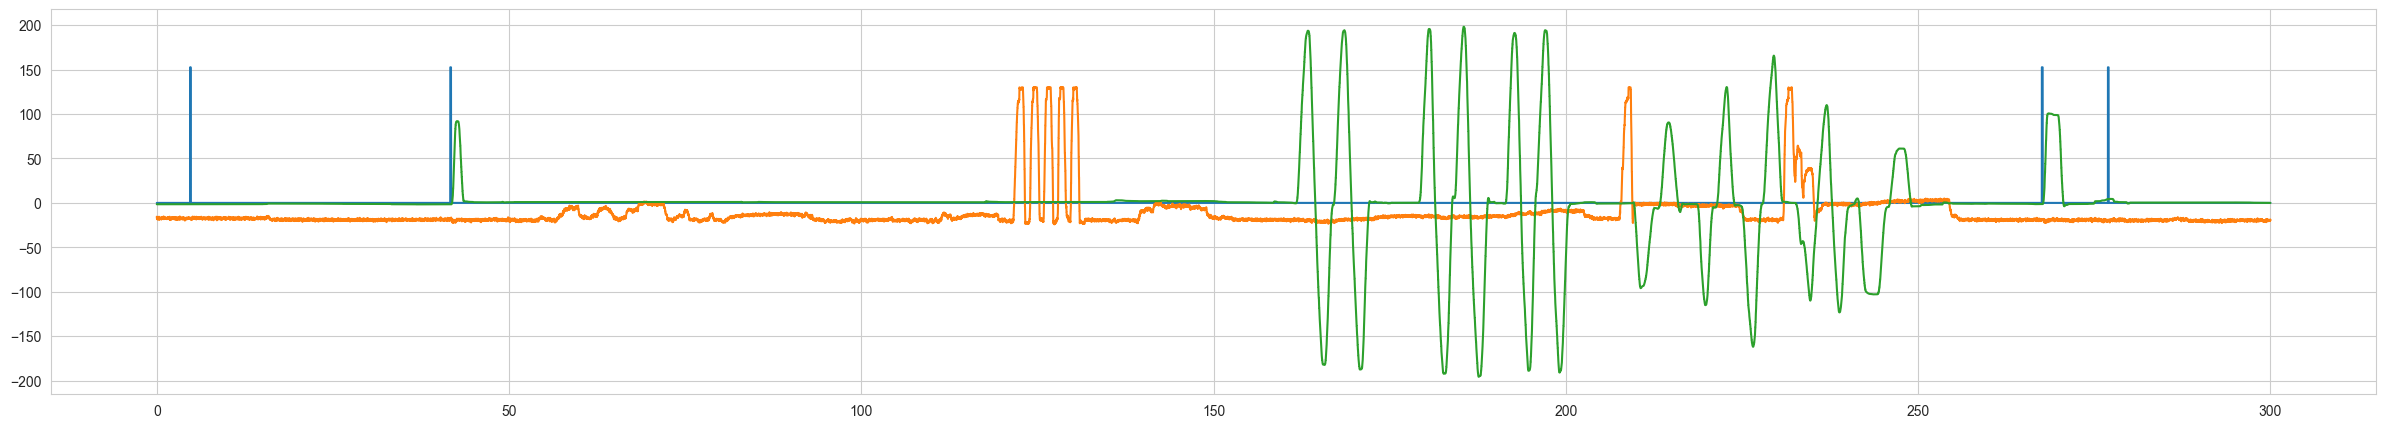

[473, 474, 475, 476, 477, 478, 479, 480, 481, 4166, 4167, 4168, 4169, 4170, 4171, 4172, 4173, 4174, 4175, 4176, 26757, 26758, 26759, 26760, 26761, 26762, 26763, 26764, 26765, 26766, 26767, 26768, 27695, 27696, 27697, 27698, 27699, 27700, 27701, 27702, 27703, 27704]
473 30001


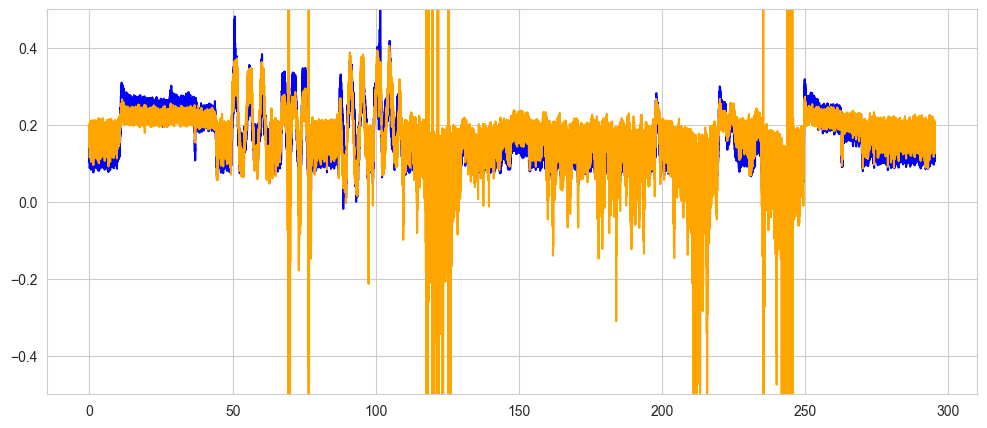

Sampling rate: 41.66666666666509 Hz


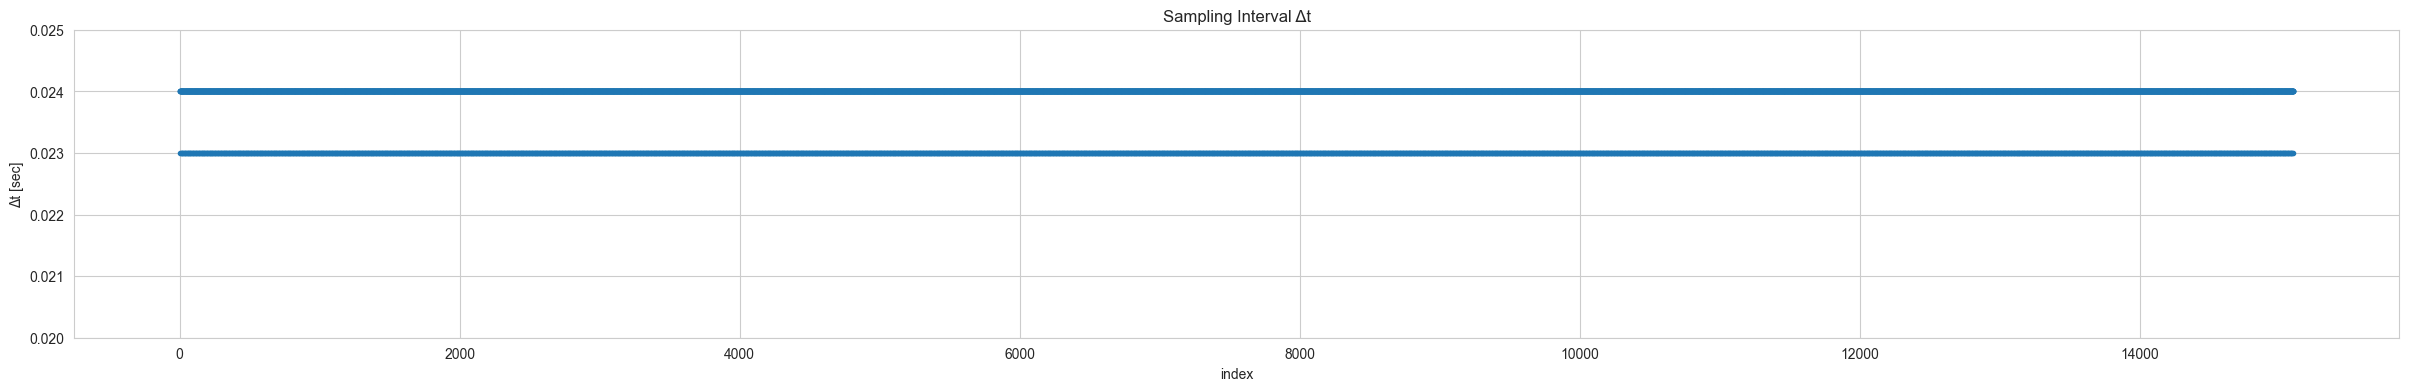

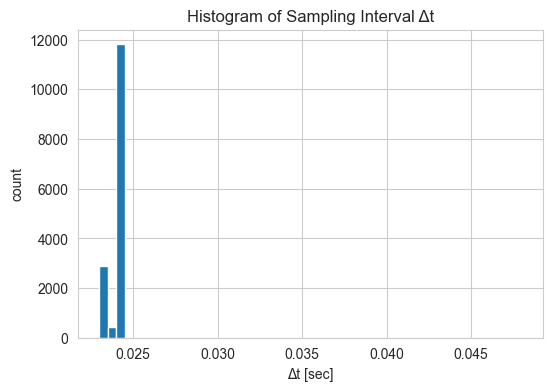

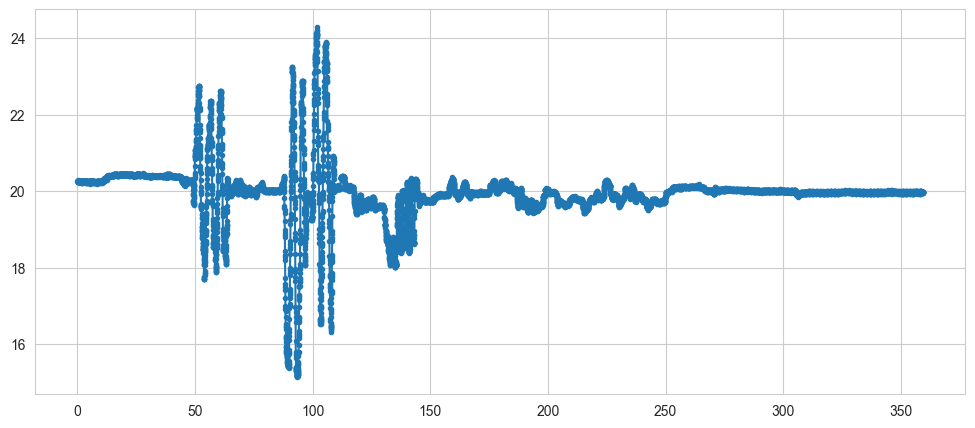

In [59]:
for num, idx in enumerate(data_info.index): 
    row = data_info.iloc[idx,:] 
    sub_ = row['sub'] 
    seat_path = row['seat']
    cop_path = row['cop']
    pedal_path = row['pedal']
    steer_path = row['steer']
    label = row['label']

    if (label != "3F") or (sub_ != "G"):
        continue

    df_seat = pd.read_csv(seat_path,skiprows=1)
    df_cop = pd.read_csv(cop_path,skiprows=21)
    df_pedal = pd.read_csv(pedal_path,skiprows=21)
    df_steer = pd.read_csv(steer_path,skiprows=21)

    if label == "2F":
        df_pedal.rename(columns={'Untitled 1':'pedal'},inplace=True)
        df_steer.rename(columns={'Untitled 1':'steer','Untitled 2':'trg'},inplace=True)
        df_cop.rename( columns={'Untitled 2':'COP_X','Untitled 3':'COP_Y'},inplace=True)

    elif label =="3F":
        df_pedal.rename(columns={'Untitled 2':'pedal','Untitled 5':'trg','Untitled':'timestamp','Untitled 7':'next_due_pedal'},inplace=True)
        df_steer.rename(columns={'Untitled 1':'steer','Untitled 7':'next_due_steer','Untitled':'timestamp'},inplace=True)
        df_cop.rename(columns={'Untitled':'F1','Untitled 1':'F2','Untitled 2':'F3','Untitled 3':'F4','Untitled 4':'FX','Untitled 5':'FY','Untitled 7':'next_due_seat'},inplace=True)


    df_pedal = make_time_row(df_pedal)
    df_steer = make_time_row(df_steer)
    df_cop = make_time_row(df_cop)
    
    df_mock = pd.merge(df_cop[['time','F1','F2','F3','F4','FX','FY']], df_steer[['time','steer']], on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 
    df_mock = pd.merge(df_mock, df_pedal[['time','pedal','trg']], on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 


    plt.figure(figsize=(30,5))
    plt.plot(df_mock.time,df_mock.trg*10)
    plt.plot(df_mock.time,df_mock.pedal*10)
    plt.plot(df_mock.time,df_mock.steer)
    plt.show()


    df_mock_tmp = get_first_trigger_segment(df_mock, trigger_col="trg", trigger_value=1)
    df_mock_tmp['time'] -= df_mock_tmp['time'].iloc[0]
    plt.plot(df_mock_tmp.time,df_mock_tmp['FY'],'-',color='blue')
    plt.plot(df_mock_tmp.time,df_mock_tmp['FX'],'-',color='orange')
    plt.ylim(-0.5,0.5)
    plt.show()

    df_seat = fix_columns(df_seat)
    df_seat['time'] = df_seat['時間_1']
    fs, dt = estimate_sampling_rate(df_seat)
    print("Sampling rate:", fs, "Hz")

    # time 差分（サンプリング間隔）
    dt = df_seat['time'].diff()

    plt.figure(figsize=(30,4))
    plt.plot(dt,'.')
    plt.title("Sampling Interval Δt")
    plt.xlabel("index")
    plt.ylabel("Δt [sec]")
    plt.ylim(0.020,0.025)
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(6,4))
    plt.hist(dt.dropna(), bins=50)
    plt.title("Histogram of Sampling Interval Δt")
    plt.xlabel("Δt [sec]")
    plt.ylabel("count")
    plt.grid(True)
    plt.show()

    plt.plot(df_seat.time,df_seat['圧力中心列_2'],'.-')

    
    # break


--- Processing Start ---
Column 'FX' (Thresh=5.0): Detected 34 outliers.
Column 'FY' (Thresh=1.0): Detected 0 outliers.
--- Processing End ---



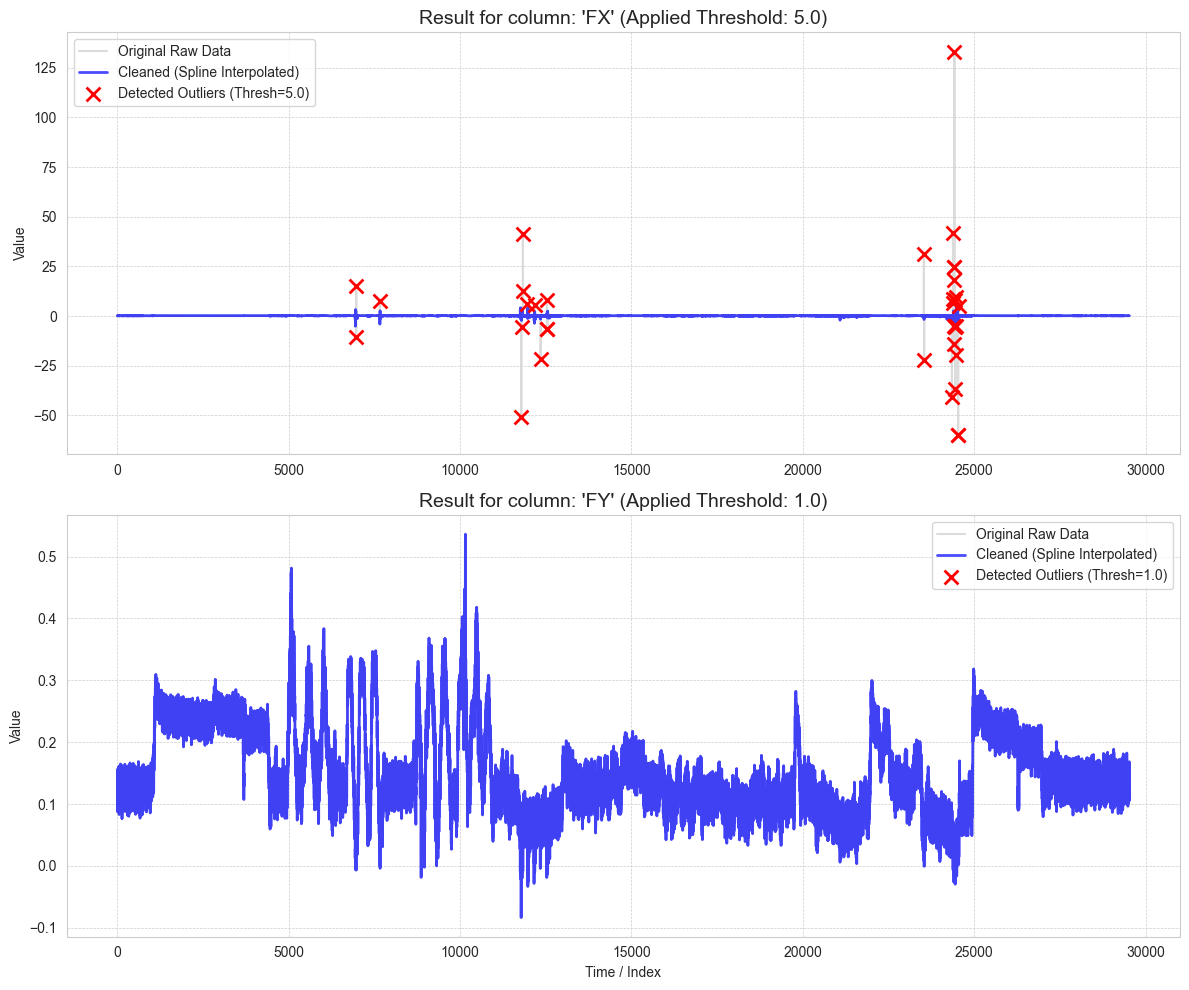

In [60]:
# --- 修正済みの関数 ---
def clean_outliers_spline_multi(df_input, threshold_dict, window=11):
    """
    カラムごとに異なる閾値で外れ値を検知し、スプライン補間で埋める関数。
    (インデックス重複や不整合によるエラーを回避する .values 版)
    """
    # 元データを変更しないようコピー
    df_result = df_input.copy()
    
    for col, thresh in threshold_dict.items():
        if col not in df_result.columns:
            continue

        # 1. トレンド推定（Seriesのまま計算）
        # rollingはインデックスを維持するため、そのまま使います
        rolling_obj = df_result[col].rolling(window=window, center=True)
        rolling_median = rolling_obj.median()
        
        # 2. 残差スコア計算 & 3. 閾値判定
        # 【重要修正ポイント】 .values をつけて Numpy配列同士として計算します。
        # これによりインデックスの不整合によるエラーを回避します。
        diff = df_result[col].values - rolling_median.values
        score = np.abs(diff)
        
        # マスクもNumpy配列(True/Falseのリスト)になります
        outlier_mask = score > thresh
        
        # ログ表示（numpyのsumを使います）
        n_outliers = np.sum(outlier_mask) 
        print(f"Column '{col}' (Thresh={thresh}): Detected {n_outliers} outliers.")
        
        if n_outliers > 0:
            # 4. 外れ値をNaNに置換
            # .loc は Numpy配列のマスク(True/False)をそのまま受け取れます
            df_result.loc[outlier_mask, col] = np.nan
            
            # 5. スプライン補間
            # limit_direction='both'で端も埋めます
            df_result[col] = df_result[col].interpolate(method='spline', order=3, limit_direction='both')
            
    return df_result

# ==========================================
#  実行と確認プロット
# ==========================================

# 1. テスト用データの作成（正常な時系列データ）
# np.random.seed(42)
# t = np.linspace(0, 100, 300) # 点数を少し増やして滑らかに

# # カラムA (FX): 変動が小さいデータ
# col_a = np.sin(t / 5) + np.random.normal(0, 0.1, 300)
# col_a[50] = 4.5   # 上スパイク
# col_a[120] = -3.5 # 下スパイク

# # カラムB (Sensor): 変動が激しいデータ（振幅が大きい）
# col_b = 5 * np.cos(t / 5) + np.random.normal(0, 0.5, 300) 
# col_b[200] = 18.0 # 巨大なスパイク
# col_b[205:210] = -15.0 # 幅のある異常

# df_mock = pd.DataFrame({'FX': col_a, 'Sensor': col_b}, index=t)

# 2. 設定（辞書で閾値を個別指定）
# FXは厳しく(1.0)、Sensorは緩く(4.0)
settings = {
    'FX': 5.0,
    'FY': 1.0 
}

# 3. 関数を実行（修正済み関数を使用）
print("--- Processing Start ---")
df_cleaned = clean_outliers_spline_multi(df_mock_tmp, threshold_dict=settings, window=15)
print("--- Processing End ---\n")

# --- 復活させた結果確認プロット ---
fig, axes = plt.subplots(len(settings), 1, figsize=(12, 10))

# 辞書のキー（カラム名）を使って順番にプロット
for i, col in enumerate(settings.keys()):
    # 元データ（薄いグレーで表示）
    axes[i].plot(df_mock_tmp.index, df_mock_tmp[col], label='Original Raw Data', color='lightgray', alpha=0.8, linewidth=1.5)
    
    # 補間後データ（青色で表示）
    axes[i].plot(df_cleaned.index, df_cleaned[col], label='Cleaned (Spline Interpolated)', color='blue', linewidth=2, alpha=0.7)
    
    # 除去された点（赤いバツ印で強調）
    # 元データと補間後データが異なる場所を探します
    removed_points = df_mock_tmp[df_mock_tmp[col] != df_cleaned[col]]
    axes[i].scatter(removed_points.index, removed_points[col], color='red', marker='x', s=100, linewidth=2, label=f'Detected Outliers (Thresh={settings[col]})', zorder=5)
    
    # グラフの体裁を整える
    axes[i].set_title(f"Result for column: '{col}' (Applied Threshold: {settings[col]})", fontsize=14)
    axes[i].legend(fontsize=10)
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[i].set_ylabel('Value')

axes[-1].set_xlabel('Time / Index')
plt.tight_layout()
plt.show()

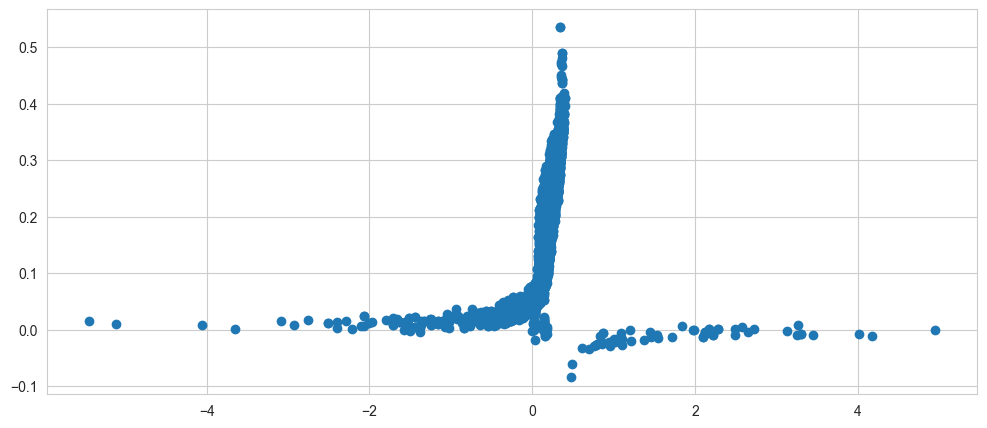

In [61]:
plt.scatter(df_cleaned.FX,df_cleaned.FY)

# ずれ量探索

['time', 'F1', 'F2', 'F3', 'F4', 'FX', 'FY', 'steer', 'pedal', 'trg', 'FX_filtered', 'FY_filtered']


C:\Users\youli\AppData\Local\Temp\ipykernel_27576\1500078414.py:115: UserWarning: Glyph 12489 (\N{KATAKANA LETTER DO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_27576\1500078414.py:115: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_27576\1500078414.py:115: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_27576\1500078414.py:115: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_27576\1500078414.py:115: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_27576\1500078414.py:115: UserWarning: Glyph 12469 (\N{KATAKANA LETTER SA}) missing from font(s) Arial.
  plt

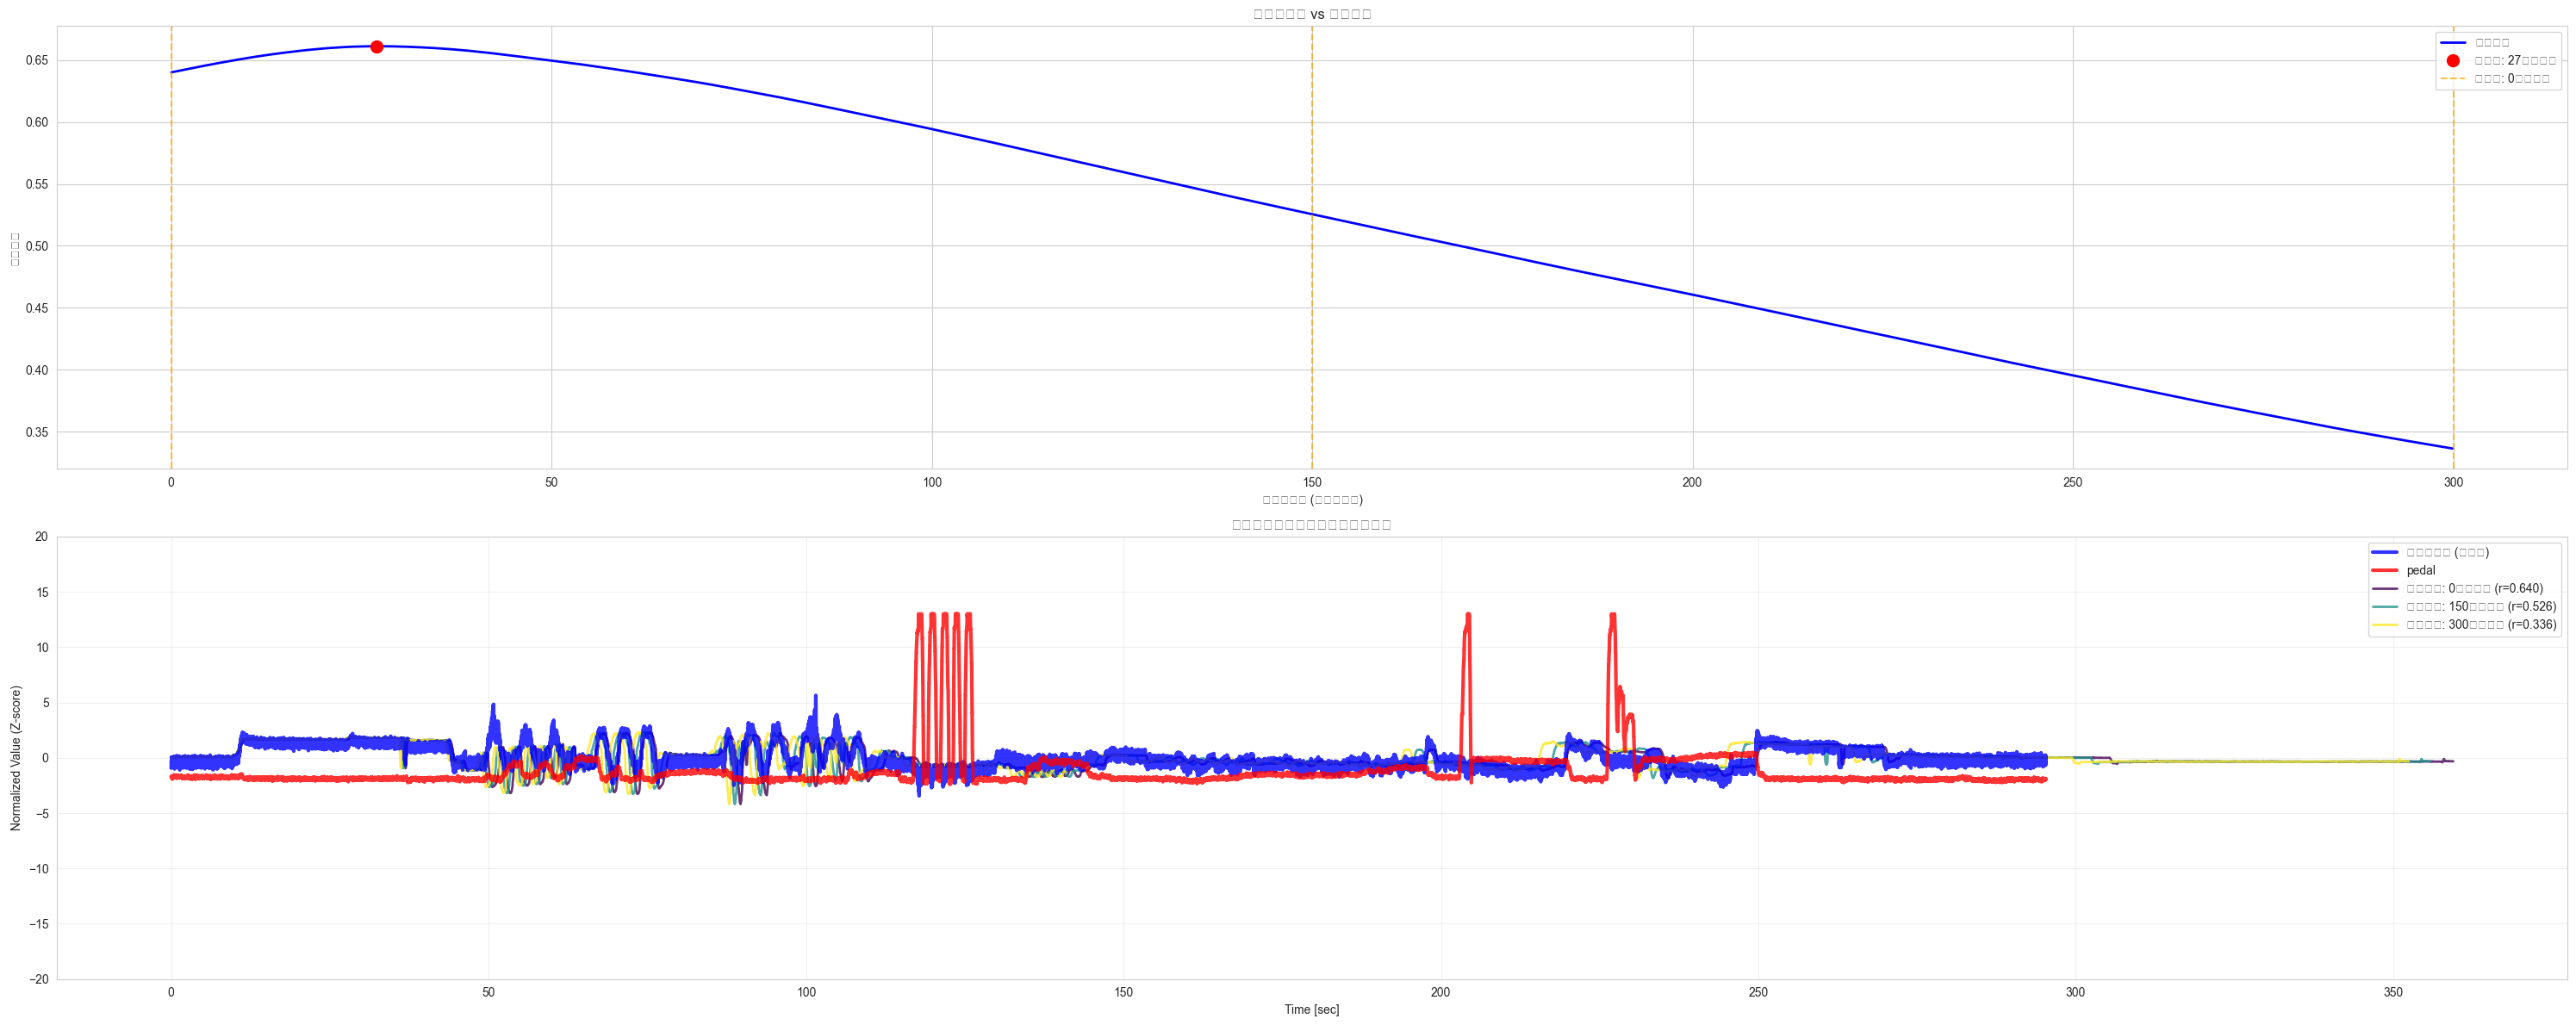


=== 探索結果サマリー ===
探索範囲: 0 ~ 300 サンプル
最適なドリフト量: 27 サンプル
最大相関係数: 0.6611

=== 代表サンプル詳細 ===
   ドリフト   0 サンプル: 相関係数 = 0.6400
   ドリフト 150 サンプル: 相関係数 = 0.5255
   ドリフト 300 サンプル: 相関係数 = 0.3363


In [62]:
def evaluate_linear_drifts_with_samples(df_ref, df_target, drift_range, 
                                       col_ref='COP_X', col_target='圧力中心列_2',
                                       num_sample_views=3):
    """
    線形ドリフトの評価＋代表的なサンプルを時系列グラフで表示
    """
    
    # --- 1. 前処理: 正規化 ---
    ref_data = df_ref[col_ref]
    ref_norm = (ref_data - ref_data.mean()) / ref_data.std()
    
    target_data = df_target[col_target]
    target_norm = (target_data - target_data.mean()) / target_data.std()
    
    # --- 2. 時間軸計算の準備 ---
    dt_mean = df_target['time'].diff().mean()
    t_start = df_target['time'].min()
    t_end_orig = df_target['time'].max()
    duration = t_end_orig - t_start # 全体長さ
    
    # --- 3. 全範囲で相関計算 ---
    all_results = []
    for drift_samples in range(drift_range[0], drift_range[1] + 1):
        total_lag_time = drift_samples * dt_mean
        scale_factor = duration / (duration + total_lag_time)
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        
        # 補間
        f_interp = interpolate.interp1d(new_time, target_norm, 
                                      bounds_error=False, fill_value='extrapolate')
        target_aligned = f_interp(df_ref['time'])
        
        # 相関計算
        valid_mask = ~np.isnan(target_aligned)
        if np.sum(valid_mask) > 10:
            correlation = np.corrcoef(ref_norm[valid_mask], target_aligned[valid_mask])[0,1]
        else:
            correlation = -1
            
        all_results.append((drift_samples, correlation))
    
    # 結果をソート
    all_results.sort(key=lambda x: x[0])
    drifts, corrs = zip(*all_results)
    
    # --- 4. 代表サンプルの選択 ---
    if len(drifts) <= num_sample_views:
        sample_drifts = drifts
    else:
        # 最小、中央、最大から選択
        indices = [
            0,  # 最小
            len(drifts) // 2,  # 中央
            len(drifts) - 1  # 最大
        ]
        sample_drifts = [drifts[i] for i in indices]
    
    # --- 5. 可視化 ---
    fig = plt.figure(figsize=(30, 12))
    
    # 5-1. 相関グラフ
    ax1 = plt.subplot(2, 1, 1)
    best_idx = np.argmax(corrs)
    plt.plot(drifts, corrs, 'b-', linewidth=2, label='相関係数')
    plt.plot(drifts[best_idx], corrs[best_idx], 'ro', markersize=10, 
             label=f'最適点: {drifts[best_idx]}サンプル')
    
    # 代表サンプルを縦線で表示
    for drift in sample_drifts:
        idx = drifts.index(drift)
        plt.axvline(x=drift, color='orange', linestyle='--', alpha=0.7,
                   label=f'代表点: {drift}サンプル' if drift == sample_drifts[0] else "")
    
    plt.xlabel('ドリフト量 (サンプル数)')
    plt.ylabel('相関係数')
    plt.title('ドリフト量 vs 相関係数')
    plt.grid(True)
    plt.legend()
    
    # 5-2. 時系列比較グラフ
    ax2 = plt.subplot(2, 1, 2)
    
    # 参照データ
    plt.plot(df_ref['time'], ref_norm, color='blue', linewidth=3, 
             alpha=0.8, label='参照データ (正規化)', zorder=10)
    plt.plot(df_ref['time'], df_ref['pedal'], color='red', linewidth=3, 
             alpha=0.8, label='pedal', zorder=10)
    
    # カラーマップ
    colors = plt.cm.viridis(np.linspace(0, 1, len(sample_drifts)))
    
    # 各代表サンプルの時系列をプロット
    for i, drift_samples in enumerate(sample_drifts):
        total_lag_time = drift_samples * dt_mean
        scale_factor = duration / (duration + total_lag_time)
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        
        # このドリフト量での相関係数を検索
        drift_corr = next((corr for drift, corr in all_results if drift == drift_samples), 0)
        
        plt.plot(new_time, target_norm, 
                 color=colors[i], linewidth=2, alpha=0.8,
                 label=f'ドリフト: {drift_samples}サンプル (r={drift_corr:.3f})')
    
    plt.title('代表的なドリフト量の時系列比較')
    plt.xlabel('Time [sec]')
    plt.ylabel('Normalized Value (Z-score)')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # 後半部分を拡大表示
    # plt.xlim(200, 300)
    plt.ylim(-20, 20)
    
    plt.tight_layout()
    plt.show()
    
    # --- 6. 結果表示 ---
    print("\n=== 探索結果サマリー ===")
    print(f"探索範囲: {drift_range[0]} ~ {drift_range[1]} サンプル")
    print(f"最適なドリフト量: {drifts[best_idx]} サンプル")
    print(f"最大相関係数: {corrs[best_idx]:.4f}")
    
    print(f"\n=== 代表サンプル詳細 ===")
    for drift in sample_drifts:
        idx = drifts.index(drift)
        marker = "★" if drift == drifts[best_idx] else "  "
        print(f"{marker} ドリフト {drift:3d} サンプル: 相関係数 = {corrs[idx]:.4f}")
    
    return all_results, sample_drifts

# ==========================================
# 実行例
# ==========================================

filter_processor = DataFrameLowpassFilter(
    sampling_freq=100, 
    cutoff_freq=5, 
    order=1
)

# 複数列を一度にフィルタリング
columns_to_process = ['FX', 'FY']
df_filtered = filter_processor.filter_dataframe(df_cleaned, columns_to_process)

print(df_filtered.columns.tolist())


all_results, sample_drifts = evaluate_linear_drifts_with_samples(
    df_filtered, #df_cleaned,
    df_seat, 
    drift_range=[0,300],  # 探索範囲
    # col_ref='FY_filtered',
    # col_target='荷重(N)_1',

    col_ref='FY', 
    col_target='圧力中心行_1',
    num_sample_views=3  # 表示する代表点の数
)

# リサンプリングパラメータあてはめ

C:\Users\youli\AppData\Local\Temp\ipykernel_27576\152420524.py:87: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_27576\152420524.py:87: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_27576\152420524.py:87: UserWarning: Glyph 31684 (\N{CJK UNIFIED IDEOGRAPH-7BC4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_27576\152420524.py:87: UserWarning: Glyph 22258 (\N{CJK UNIFIED IDEOGRAPH-56F2}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_27576\152420524.py:87: UserWarning: Glyph 31186 (\N{CJK UNIFIED IDEOGRAPH-79D2}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_27576\152420524.py:87: UserWarning: Glyph 21442 (\N{CJK UNIFIED IDEOGRAPH-53C2}) missi

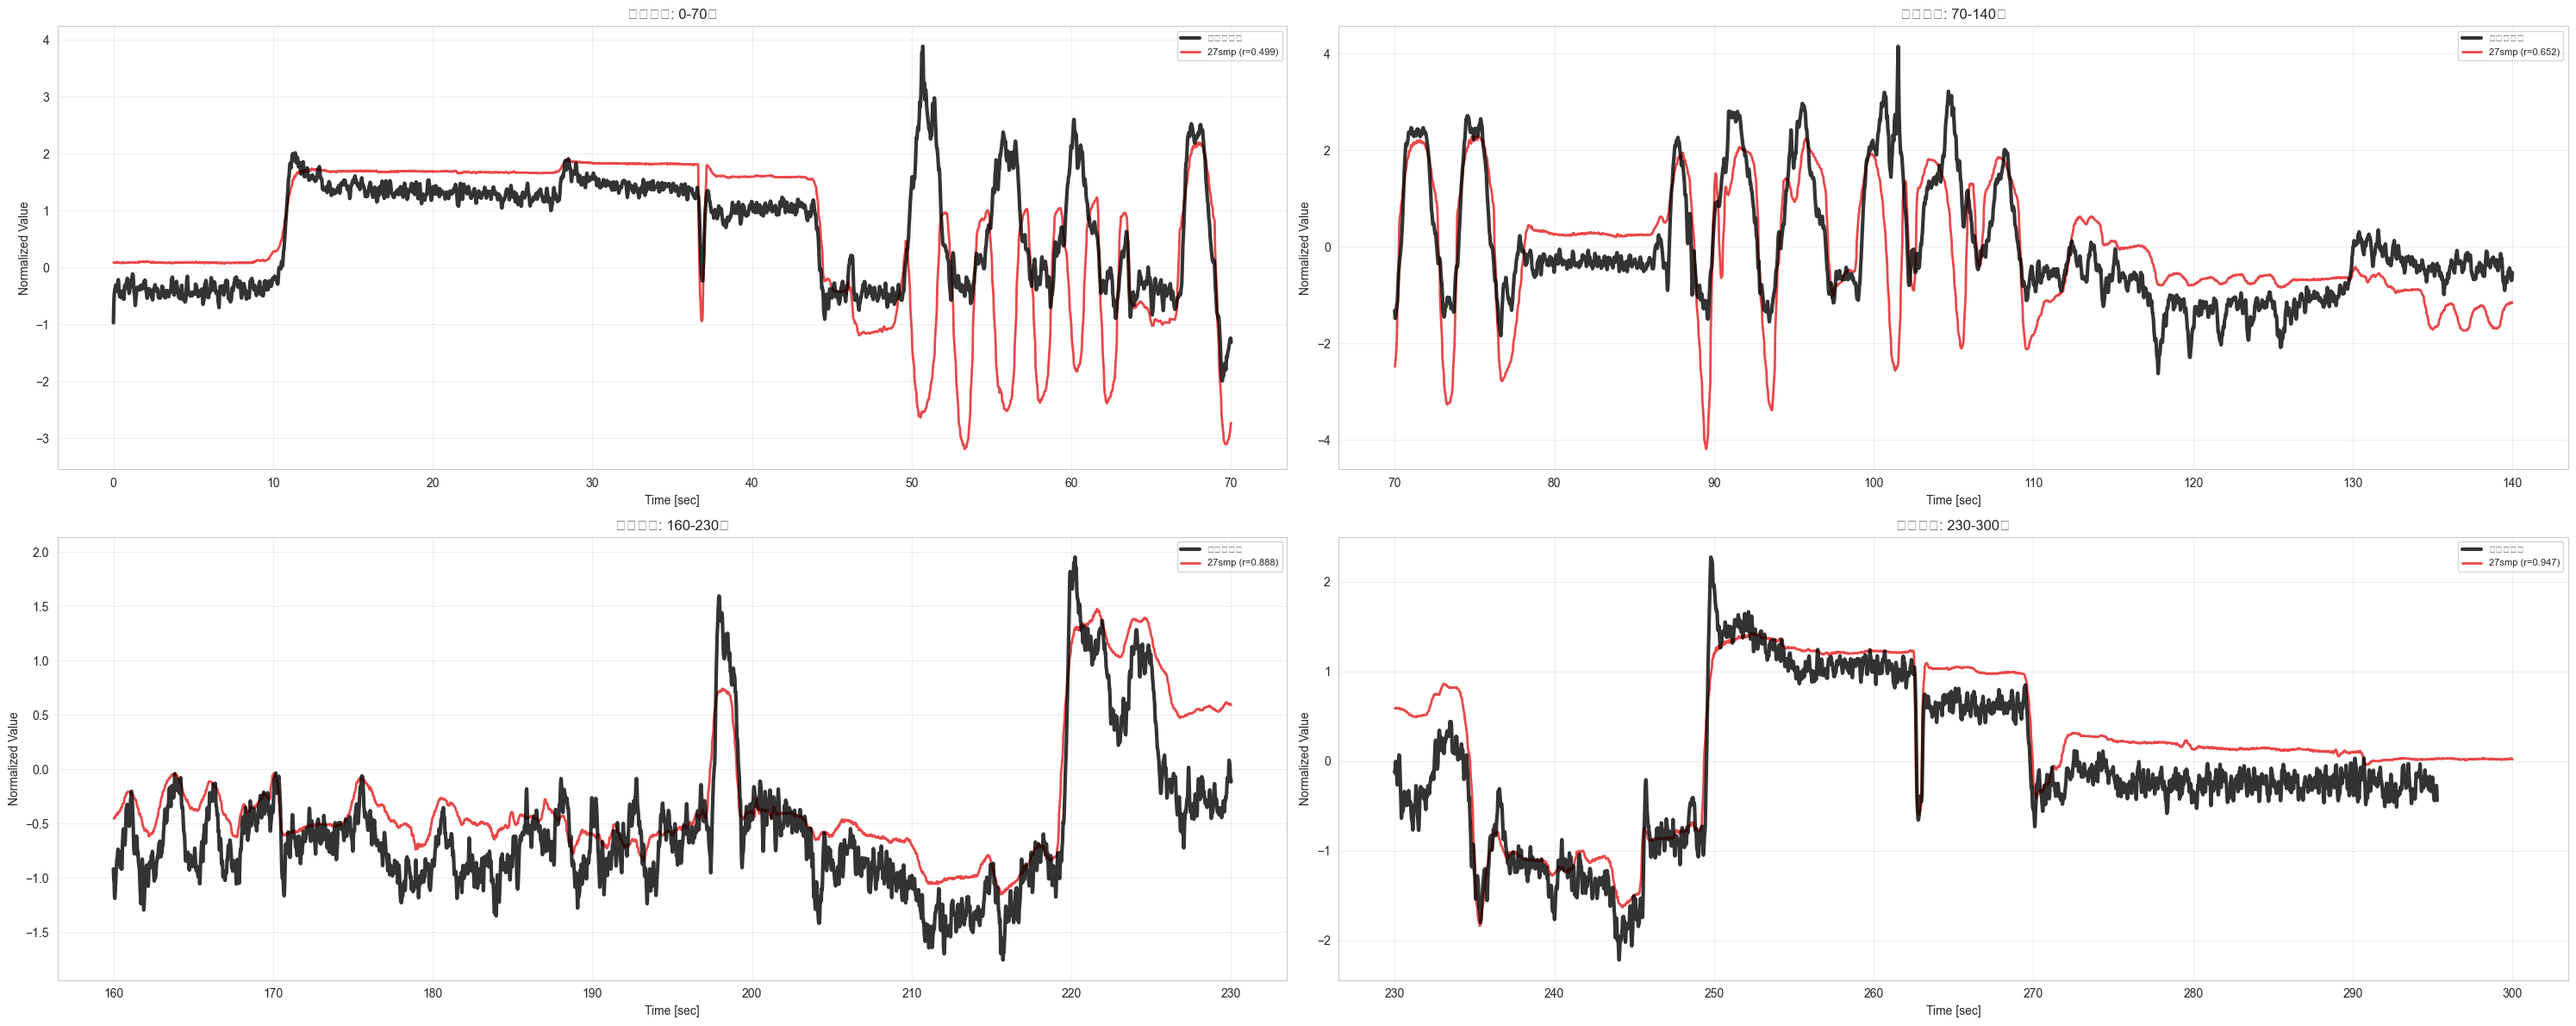


=== 指定ドリフト量の全体相関 ===
ドリフト  27 サンプル: 全体相関 = 0.6921


In [63]:
def compare_detailed_samples(df_ref, df_target, specific_drifts, 
                           col_ref='COP_X', col_target='圧力中心列_2',
                           focus_range=(200, 300)):
    """
    特定のドリフト量を詳細に比較（複数区間で表示）
    """    

    # --- 前処理 ---
    ref_data = df_ref[col_ref]
    ref_norm = (ref_data - ref_data.mean()) / ref_data.std()
    
    target_data = df_target[col_target]
    target_norm = (target_data - target_data.mean()) / target_data.std()
    
    dt_mean = df_target['time'].diff().mean()
    t_start = df_target['time'].min()
    t_end_orig = df_target['time'].max()
    duration = t_end_orig - t_start
    
    # --- 複数サブプロットで表示 ---
    fig, axes = plt.subplots(2, 2, figsize=(30, 12))
    axes = axes.flatten()
    
    # カラーマップ
    colors = plt.cm.Set1(np.linspace(0, 1, len(specific_drifts)))
    
    # 各注目区間をプロット
    focus_ranges = [
        (0, 70),     # 最初の部分
        (70, 140),   # 前半部分
        (160, 230),  # 中間部分
        (230, 300),  # 後半部分
    ]
    
    for ax_idx, (start_time, end_time) in enumerate(focus_ranges):
        if ax_idx >= len(axes):
            break
            
        ax = axes[ax_idx]
        
        # 参照データ
        mask_ref = (df_ref['time'] >= start_time) & (df_ref['time'] <= end_time)
        ax.plot(df_ref['time'][mask_ref], ref_norm[mask_ref], 
                color='black', linewidth=3, alpha=0.8, 
                label='参照データ', zorder=10)
        
        # 各ドリフト量
        for i, drift_samples in enumerate(specific_drifts):
            total_lag_time = drift_samples * dt_mean
            scale_factor = duration / (duration + total_lag_time)
            new_time = t_start + (df_target['time'] - t_start) * scale_factor
            
            # 相関係数計算（この区間のみ）
            mask_target = (new_time >= start_time) & (new_time <= end_time)
            if np.sum(mask_target) > 5:
                # この区間内での相関を計算
                time_in_range = new_time[mask_target]
                values_in_range = target_norm[mask_target]
                
                # 参照データと同じ時間点に補間
                from scipy import interpolate
                f_interp = interpolate.interp1d(time_in_range, values_in_range, 
                                              bounds_error=False, fill_value='extrapolate')
                target_aligned = f_interp(df_ref['time'][mask_ref])
                
                # 相関計算
                valid_mask = ~np.isnan(target_aligned)
                if np.sum(valid_mask) > 5:
                    correlation = np.corrcoef(ref_norm[mask_ref][valid_mask], 
                                            target_aligned[valid_mask])[0,1]
                else:
                    correlation = 0
            else:
                correlation = 0
            
            # プロット
            ax.plot(new_time[mask_target], target_norm[mask_target],
                   color=colors[i], linewidth=2, alpha=0.8,
                   label=f'{drift_samples}smp (r={correlation:.3f})')
        
        ax.set_title(f'時間範囲: {start_time}-{end_time}秒')
        ax.set_xlabel('Time [sec]')
        ax.set_ylabel('Normalized Value')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # 各ドリフト量の全体相関も表示
    print("\n=== 指定ドリフト量の全体相関 ===")
    for drift_samples in specific_drifts:
        total_lag_time = drift_samples * dt_mean
        scale_factor = duration / (duration + total_lag_time)
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        # new_time = df_target['time'] * scale_factor
        
        # 補間
        from scipy import interpolate
        f_interp = interpolate.interp1d(new_time, target_norm, 
                                      bounds_error=False, fill_value='extrapolate')
        target_aligned = f_interp(df_ref['time'])
        
        # 全体相関
        valid_mask = ~np.isnan(target_aligned)
        if np.sum(valid_mask) > 10:
            overall_correlation = np.corrcoef(ref_norm[valid_mask], target_aligned[valid_mask])[0,1]
            print(f"ドリフト {drift_samples:3d} サンプル: 全体相関 = {overall_correlation:.4f}")

# 特定のドリフト量を詳細比較
compare_detailed_samples(
    df_filtered, # df_cleaned, 
    df_seat, 
    specific_drifts=[27],  # 比較したい特定の値 subA = 279 subC = 140, subE = 269, subG = 27
    # col_ref='FY_filtered', 
    # col_target='荷重(N)_1'

    col_ref='FY_filtered', 
    col_target='圧力中心行_1'

    # col_ref='FX_filtered', 
    # col_target='圧力中心列_1'


)

# ずれ量確定

補正情報:
  - ズレサンプル数: 27
  - ズレ時間換算  : 0.6429 sec
  - 適用スケール  : 0.99821464


c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32066 (\N{CJK UNIFIED IDEOGRAPH-7D42}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32080 (\N{CJK UNIFIED IDEOGRAPH-7D50}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing fr

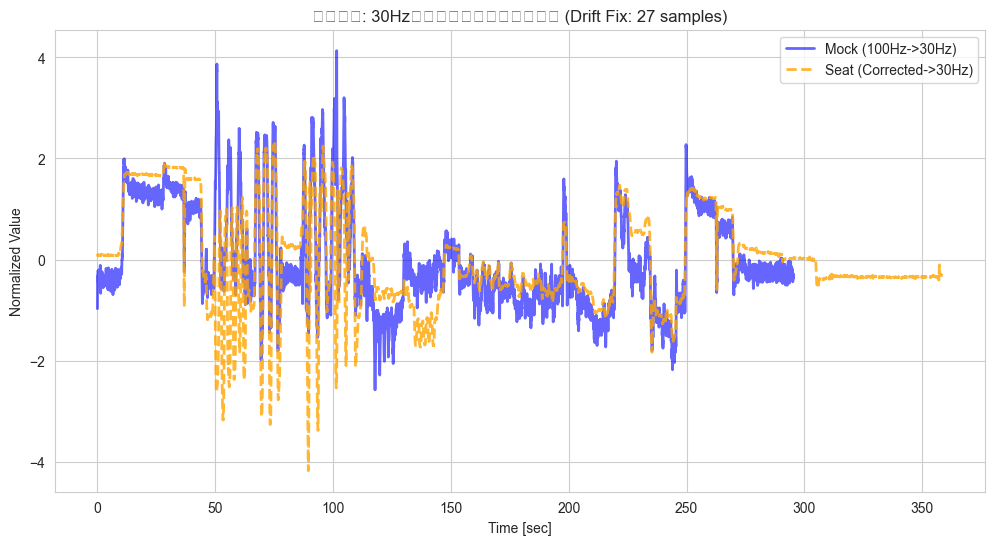

--- df_mock_30hz ---
       time        F1        F2        F3        F4    steer     pedal  \
0  0.000000 -0.036621  0.312805  0.634766  0.353088 -1.51751 -1.709473   
1  0.033333  0.006104  0.374756  0.568848  0.269470 -1.51751 -1.801026   
2  0.066667  0.063883  0.373942  0.619710  0.262146 -1.51751 -1.770508   
3  0.100000  0.076904  0.361328  0.592346  0.239563 -1.51751 -1.678956   
4  0.133333  0.095113  0.356547  0.582377  0.282186 -1.51751 -1.709473   

   FX_filtered  FY_filtered  
0     0.116631     0.088345  
1     0.149327     0.114331  
2     0.164747     0.124116  
3     0.172589     0.127372  
4     0.177202     0.130677  

--- df_seat_30hz ---
       time  平均圧力_1  最低圧力_1   ピーク圧力_1  接触域 (cm²)_1  選択領域(cm²)_1     接触 %_1  \
0  0.000000     0.4    0.13  2.080000   879.030000      2580.65  34.060000   
1  0.033333     0.4    0.13  2.082173   879.030000      2580.65  34.060000   
2  0.066667     0.4    0.13  2.078168   879.030000      2580.65  34.060000   
3  0.100000     0.4 

In [64]:
# =========================================================
# 1. パラメータ設定
# =========================================================
BEST_DRIFT_SAMPLES = 27  # 見つけたベストな値
TARGET_FS = 30.0           # 目標サンプリング周波数 (Hz)

# =========================================================
# 2. df_seat の時間軸を補正（永続化）
# =========================================================
def apply_drift_correction(df, drift_samples):
    """
    見つけたドリフト量(samples)に基づいて時間軸を実際に書き換える
    """
    df_fixed = df.copy()
    
    # 統計量の計算
    dt_mean = df_fixed['time'].diff().mean()
    t_start = df_fixed['time'].min()
    t_end   = df_fixed['time'].max()
    duration = t_end - t_start
    
    # ズレ時間の計算 (35サンプル * 1サンプルの時間)
    total_lag_time = drift_samples * dt_mean
    
    # 伸縮率 (Scale Factor) の計算
    # visualize関数と同じ計算式を使用
    scale_factor = duration / (duration + total_lag_time)
    
    print(f"補正情報:")
    print(f"  - ズレサンプル数: {drift_samples}")
    print(f"  - ズレ時間換算  : {total_lag_time:.4f} sec")
    print(f"  - 適用スケール  : {scale_factor:.8f}")
    
    # 時間軸の更新
    df_fixed['time'] = t_start + (df_fixed['time'] - t_start) * scale_factor
    
    return df_fixed

# df_seat の時間を修正
df_seat_fixed = apply_drift_correction(df_seat, BEST_DRIFT_SAMPLES)


# =========================================================
# 3. 共通の30Hzへのリサンプリング
# =========================================================
def resample_to_target_hz(df, time_col, data_cols, target_fs):
    """
    指定されたDataFrameをtarget_fs(Hz)にリサンプリングする関数
    """
    # 元データ
    t_src = df[time_col].values
    # 時間軸の開始と終了（データの範囲内）
    t_min, t_max = t_src.min(), t_src.max()
    
    # 新しい時間軸 (startからendまで 1/fs 刻み)
    new_time = np.arange(t_min, t_max, 1.0 / target_fs)
    
    # 結果格納用DataFrame
    df_resampled = pd.DataFrame({time_col: new_time})
    
    # 指定されたデータ列を補間
    for col in data_cols:
        # 線形補間 (linear) または 3次スプライン (cubic)
        f = interpolate.interp1d(t_src, df[col].values, kind='linear', fill_value="extrapolate")
        df_resampled[col] = f(new_time)
        
    return df_resampled

# --- リサンプリング実行 ---

mock_cols = ['F1', 'F2', 'F3', 'F4', 'steer', 'pedal', 'FX_filtered', 'FY_filtered']
seat_cols = ['平均圧力_1', '最低圧力_1',
       'ピーク圧力_1', '接触域 (cm²)_1', '選択領域(cm²)_1', '接触 %_1', '荷重(N)_1', '標準偏差_1',
       '平均_1', '圧力中心行_1', '圧力中心列_1', '平均圧力_2', '最低圧力_2', 'ピーク圧力_2',
       '接触域 (cm²)_2', '選択領域(cm²)_2', '接触 %_2', '荷重(N)_2', '標準偏差_2', '平均_2',
       '圧力中心行_2', '圧力中心列_2']

# df_mock_tmp (元100Hz) -> 30Hz
df_mock_30hz = resample_to_target_hz(
    df_filtered, 
    time_col='time', 
    data_cols=mock_cols, # 必要な列を指定
    target_fs=TARGET_FS
)

# df_seat_fixed (補正済み40Hz) -> 30Hz
df_seat_30hz = resample_to_target_hz(
    df_seat_fixed, 
    time_col='time', 
    data_cols=seat_cols, # 必要な列を指定
    target_fs=TARGET_FS
)


# =========================================================
# 4. 結果の確認（結合・プロット）
# =========================================================

# 時間軸を完全に合わせるため、共通の時間範囲でデータを結合（Merge）しても良いですが、
# ここではプロットで確認します。

# 正規化関数（比較用）
def z_score(series):
    return (series - series.mean()) / series.std()

plt.figure(figsize=(12, 6))

# 青: df_mock (30Hz)
plt.plot(df_mock_30hz['time'], z_score(df_mock_30hz['FY_filtered']), 
         label='Mock (100Hz->30Hz)', color='blue', alpha=0.6, linewidth=2)

# オレンジ: df_seat (補正済み->30Hz)
plt.plot(df_seat_30hz['time'], z_score(df_seat_30hz['圧力中心行_1']), 
         label='Seat (Corrected->30Hz)', color='orange', alpha=0.8, linestyle='--', linewidth=2)

plt.title(f"最終結果: 30Hz同期・リサンプリング完了 (Drift Fix: {BEST_DRIFT_SAMPLES} samples)")
plt.xlabel("Time [sec]")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)

# ズレやすい後半を拡大
t_end = df_mock_30hz['time'].max()
# plt.xlim(t_end - 10, t_end) 

plt.show()

# データフレームの中身確認
print("--- df_mock_30hz ---")
print(df_mock_30hz.head())
print("\n--- df_seat_30hz ---")
print(df_seat_30hz.head())

#　ここから

c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 33655 (\N{CJK UNIFIED IDEOGRAPH-8377}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


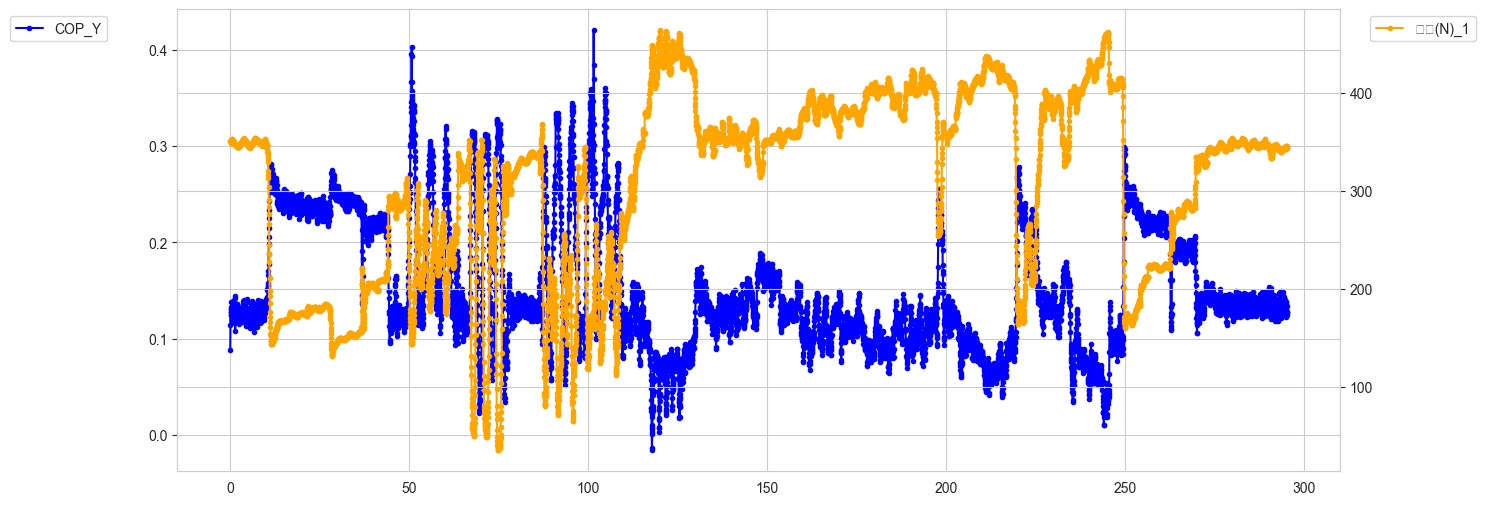

c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22311 (\N{CJK UNIFIED IDEOGRAPH-5727}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24515 (\N{CJK UNIFIED IDEOGRAPH-5FC3}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing fr

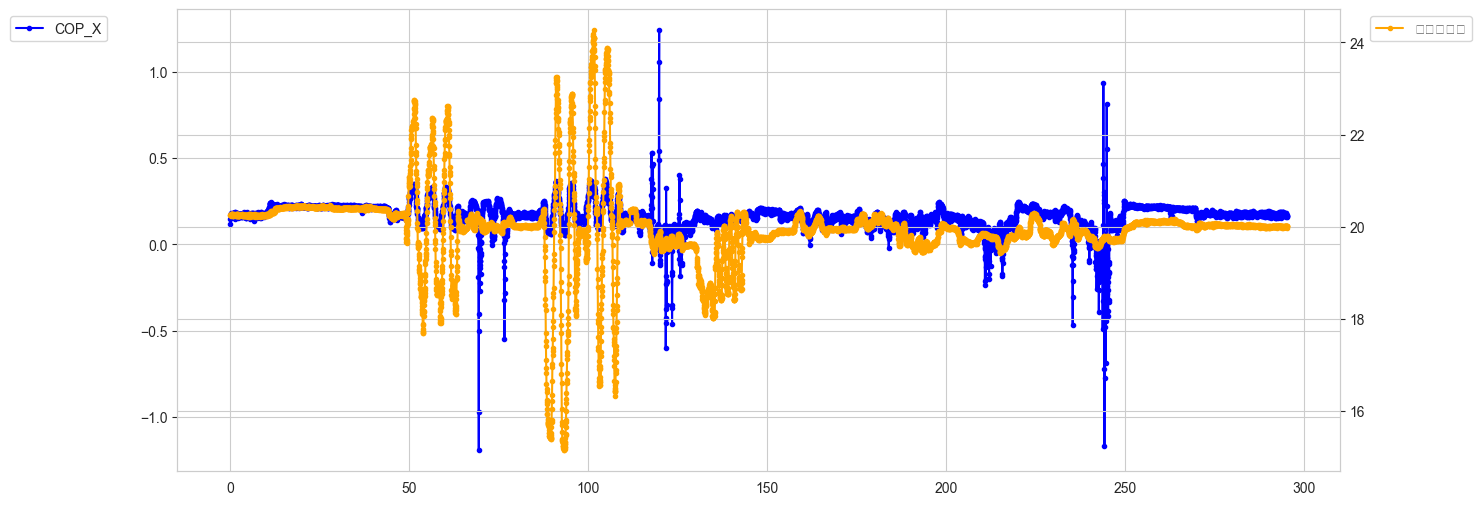

In [ ]:
df_all = pd.merge(df_mock_30hz, df_seat_30hz, on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 

# import pickle
# df_all['subject_id'] = 7
# with open('G.pkl','wb') as f:
#     pickle.dump(df_all,f)


fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx() 
ax1.plot(df_all.time,df_all['FY_filtered'],'.-',color='blue',label='COP_Y')
ax2.plot(df_all['time'],df_all['荷重(N)_1'],'.-',color='orange',label='荷重(N)_1') 
ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx() 
ax1.plot(df_all["time"],df_all['FX_filtered'],'.-',color='blue',label='COP_X')
ax2.plot(df_all['time'],df_all['圧力中心列_2'],'.-',color='orange',label='圧力中心列') # Y
ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()

In [2]:
import pickle

dfs = []

for ch in ['A','C', 'E', 'G']:
    fname = f"{ch}.pkl"
    with open(fname, "rb") as f:
        df = pickle.load(f)
        dfs.append(df)

# 縦に連結
df_all = pd.concat(dfs, axis=0, ignore_index=True)


In [3]:
df_all.subject_id.unique()
print(len(df_all))

35072


入力変数(X): ['F1', 'F2', 'F3', 'F4', 'FX_filtered', 'FY_filtered', 'pedal', 'steer', 'subject_id']
出力変数(Y): ['圧力中心列_2', '荷重(N)_1', '圧力中心行_1', '圧力中心列_1', 'ピーク圧力_1', '接触 %_1', '接触 %_2']
修正版パイプライン: Smooth -> Detrend -> Lag -> Scale

--- Fold 1 ---
  Target: 圧力中心列_2         | R2: 0.9293
  Target: 圧力中心列_2    | Train: 8728 | R2: 0.9293
  Target: 荷重(N)_1         | R2: 0.0813
  Target: 荷重(N)_1    | Train: 8768 | R2: 0.0813
  Target: 圧力中心行_1         | R2: -0.0501
  Target: 圧力中心行_1    | Train: 8768 | R2: -0.0501
  Target: 圧力中心列_1         | R2: -0.1103
  Target: 圧力中心列_1    | Train: 8768 | R2: -0.1103
  Target: ピーク圧力_1         | R2: -1.1660
  Target: ピーク圧力_1    | Train: 8768 | R2: -1.1660
  Target: 接触 %_1          | R2: 0.1330
  Target: 接触 %_1     | Train: 8768 | R2: 0.1330
  Target: 接触 %_2          | R2: -1.0651
  Target: 接触 %_2     | Train: 8768 | R2: -1.0651

--- Fold 2 ---
  Target: 圧力中心列_2         | R2: -122.7193
  Target: 圧力中心列_2    | Train: 17411 | R2: -122.7193
  Target: 荷重(N)_1         | R2:

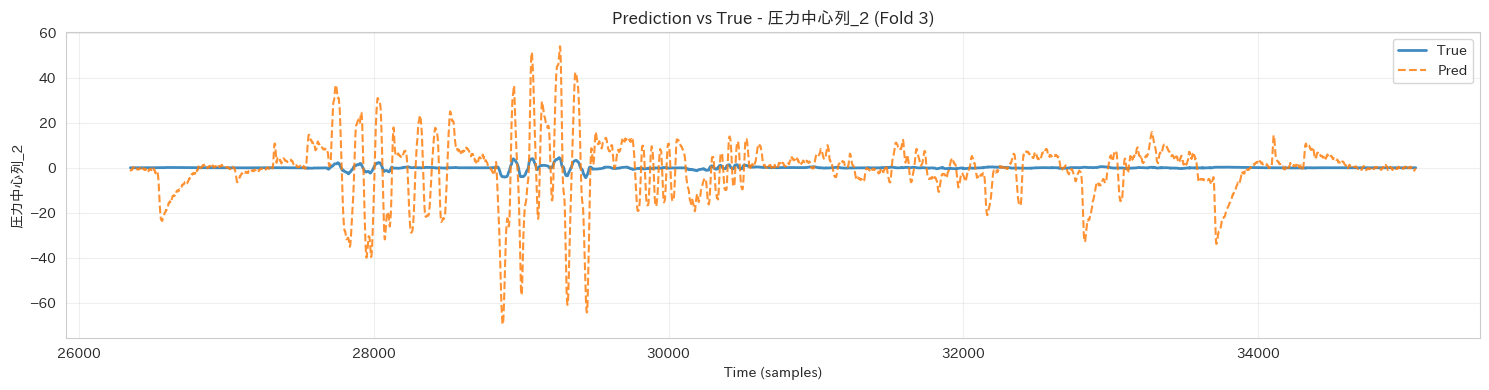

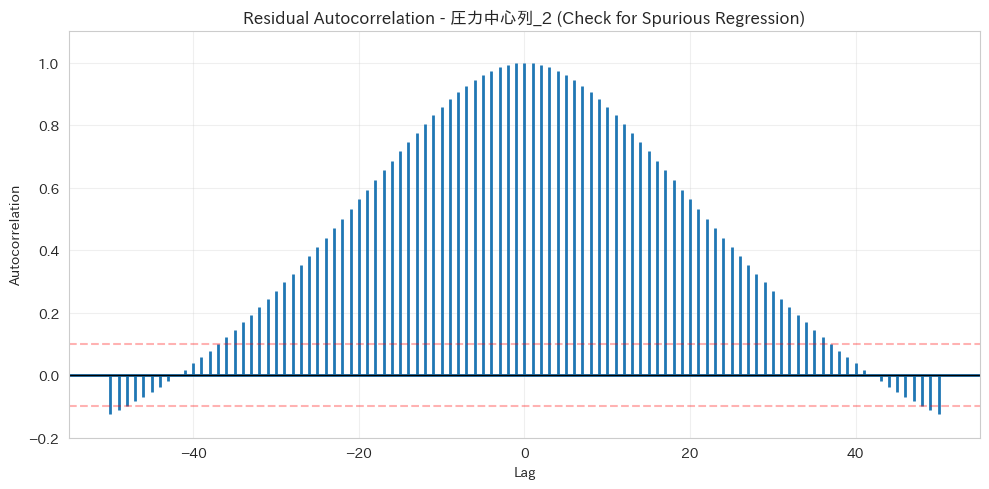

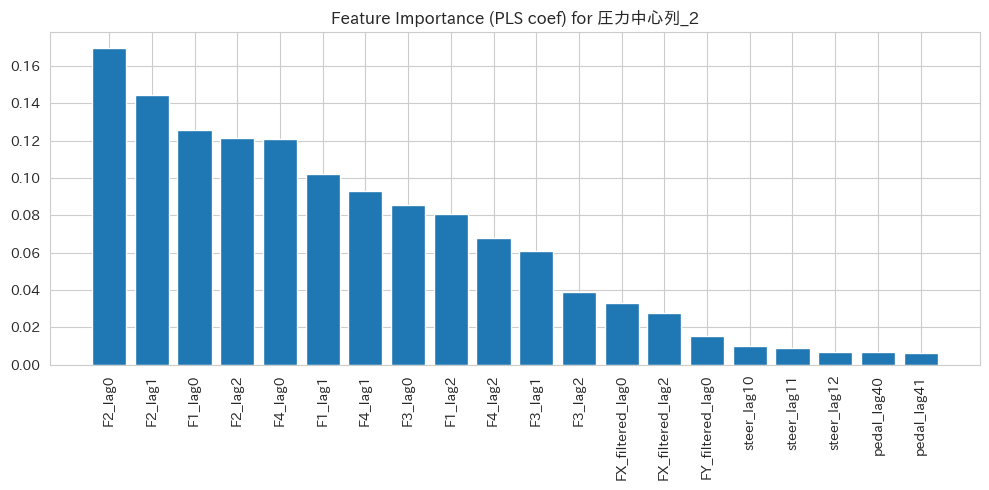

  Target: 荷重(N)_1         | R2: -323.9324
  Target: 荷重(N)_1    | Train: 26296 | R2: -323.9324


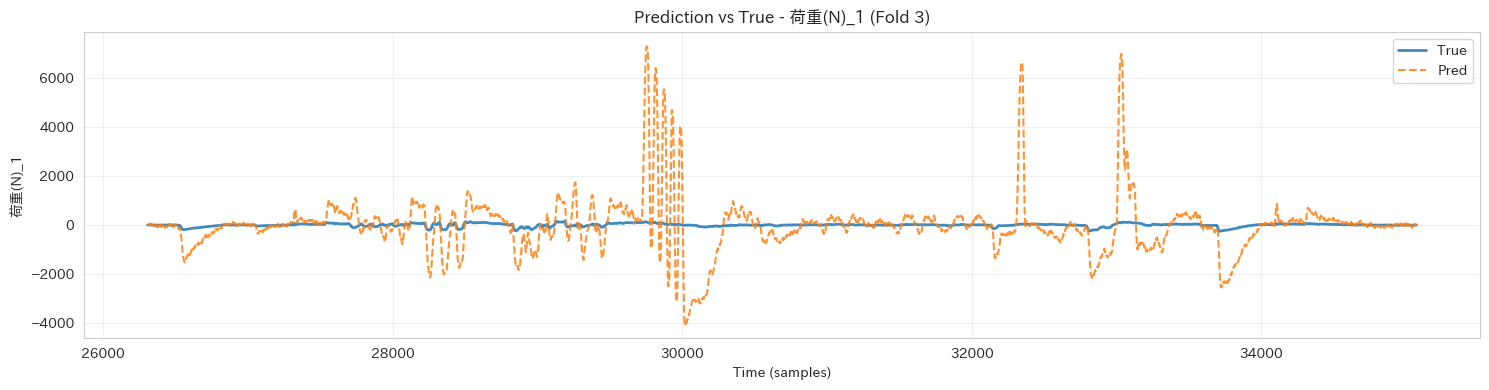

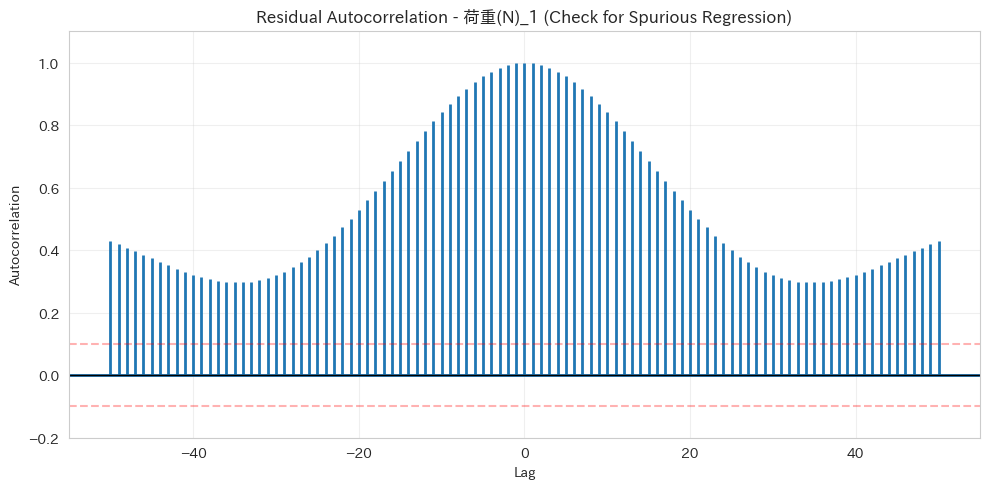

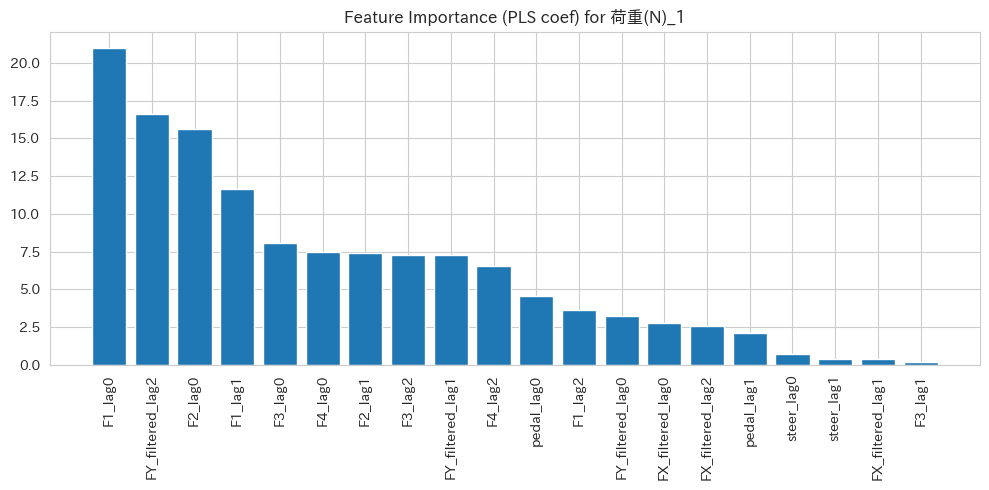

  Target: 圧力中心行_1         | R2: -432.0497
  Target: 圧力中心行_1    | Train: 26296 | R2: -432.0497


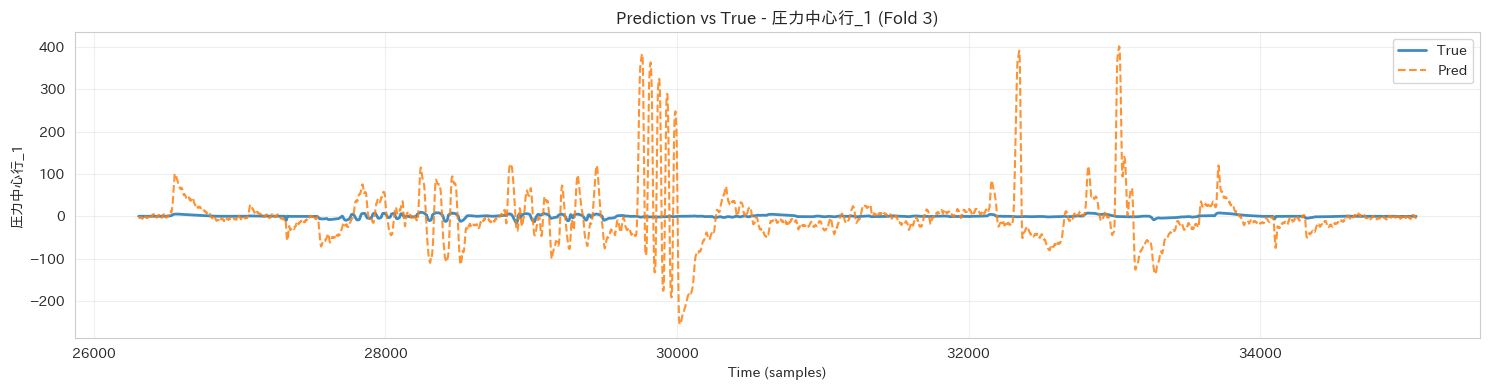

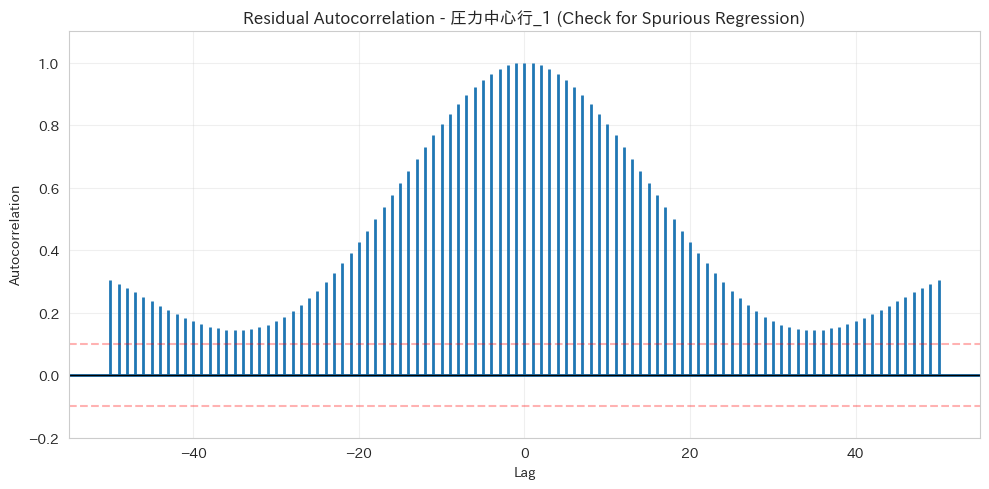

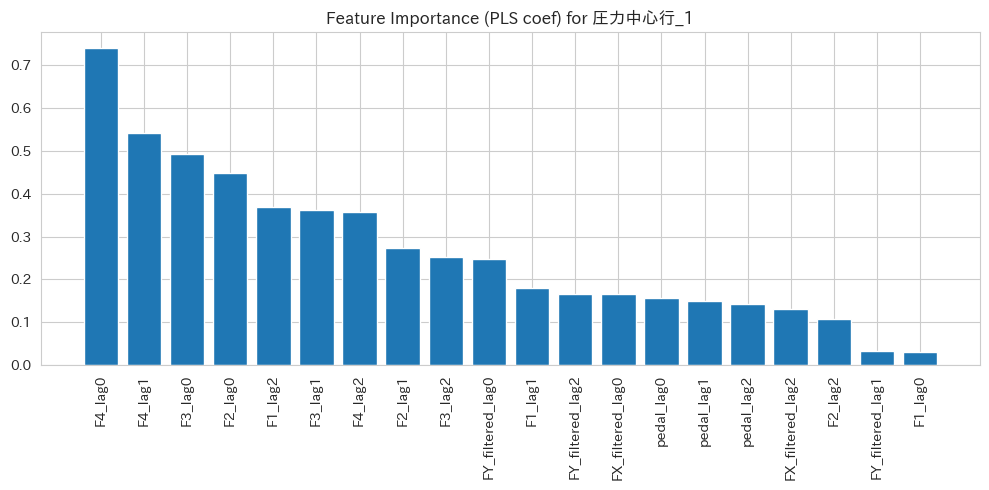

  Target: 圧力中心列_1         | R2: -60.3518
  Target: 圧力中心列_1    | Train: 26296 | R2: -60.3518


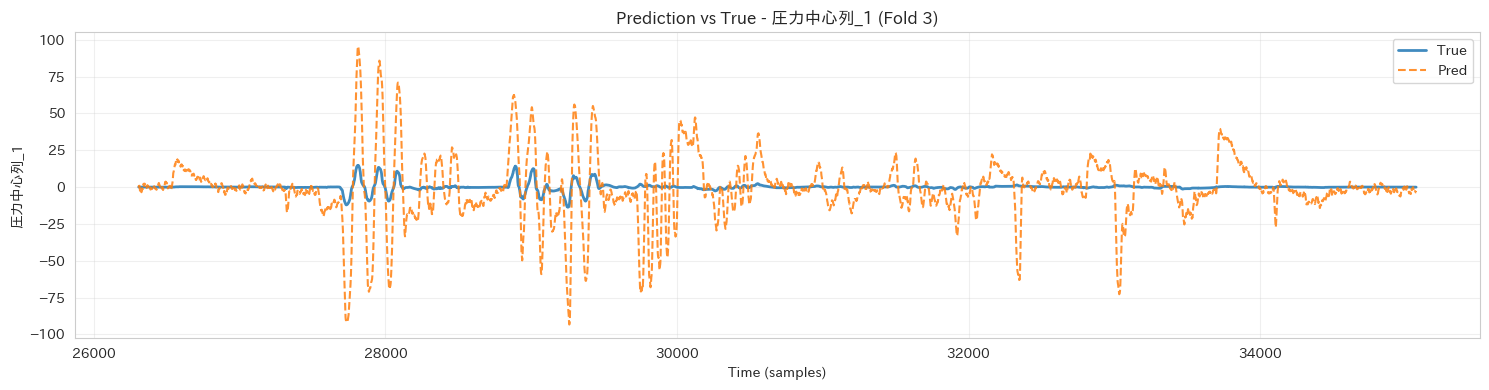

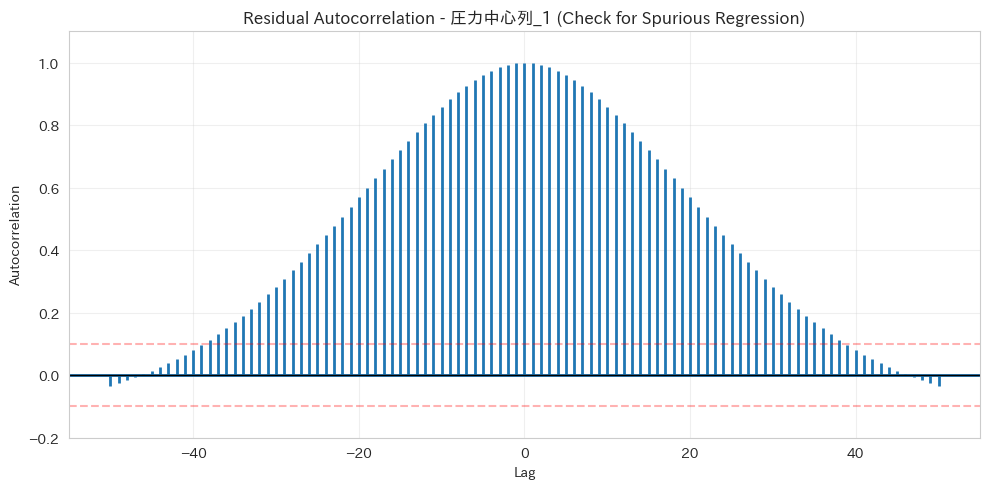

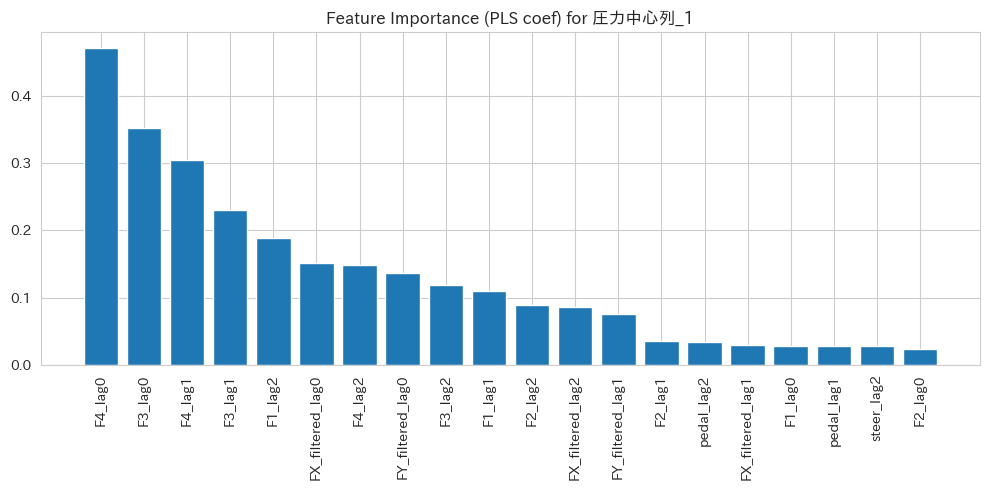

  Target: ピーク圧力_1         | R2: -156.8839
  Target: ピーク圧力_1    | Train: 26296 | R2: -156.8839


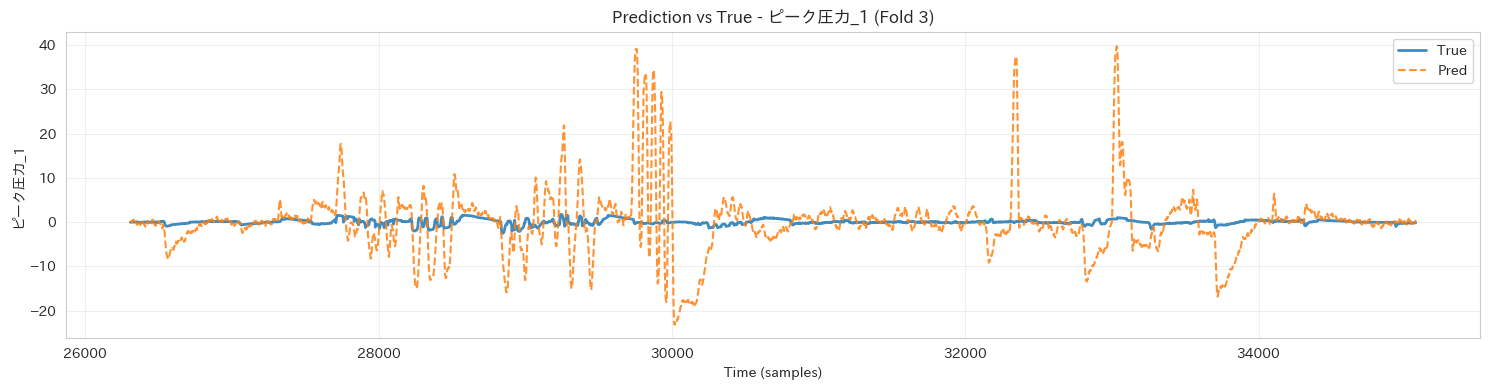

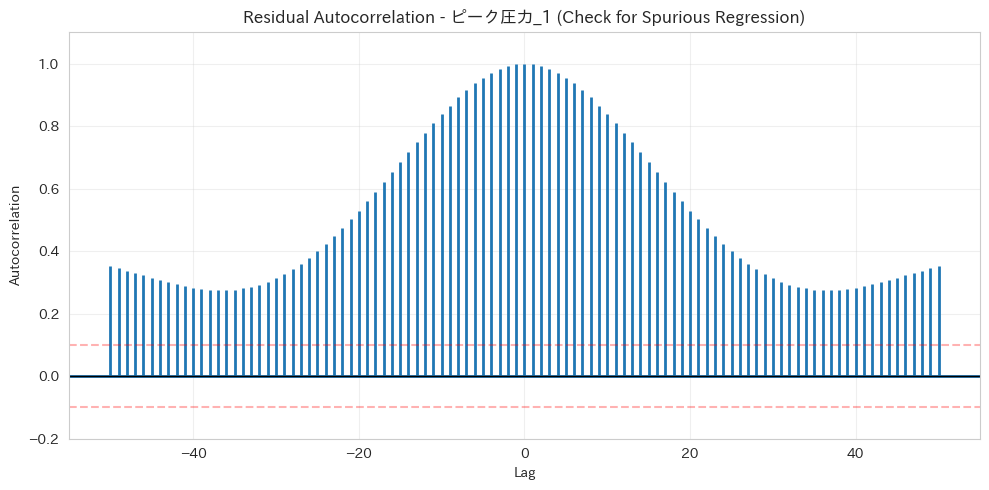

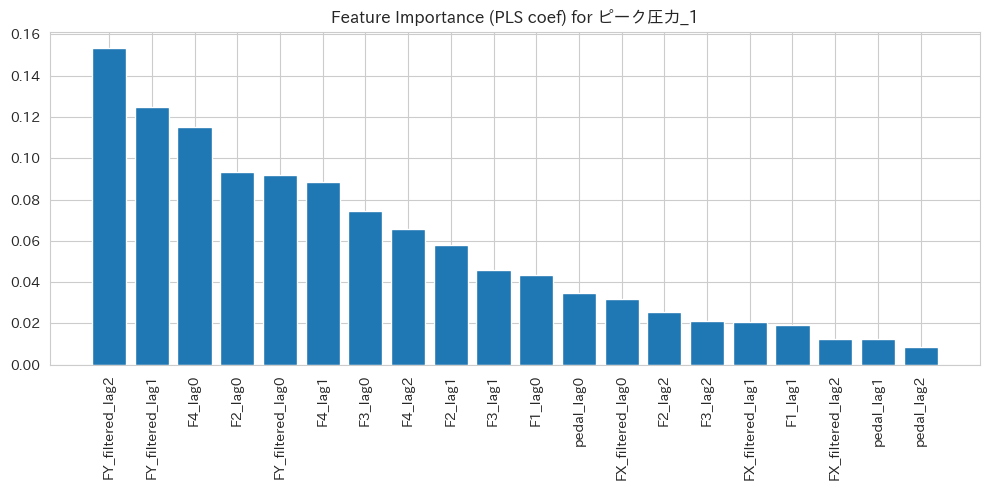

  Target: 接触 %_1          | R2: -163.7761
  Target: 接触 %_1     | Train: 26296 | R2: -163.7761


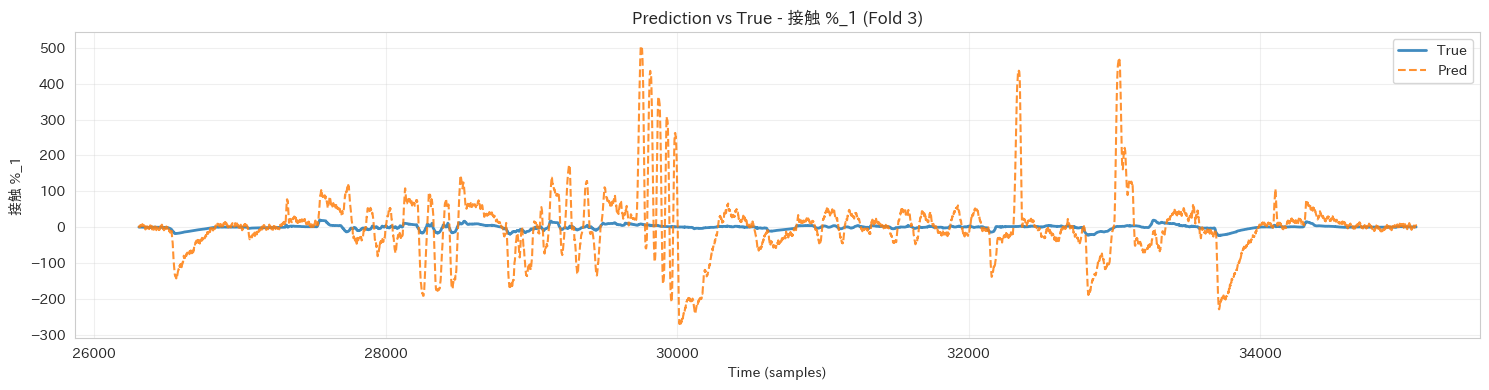

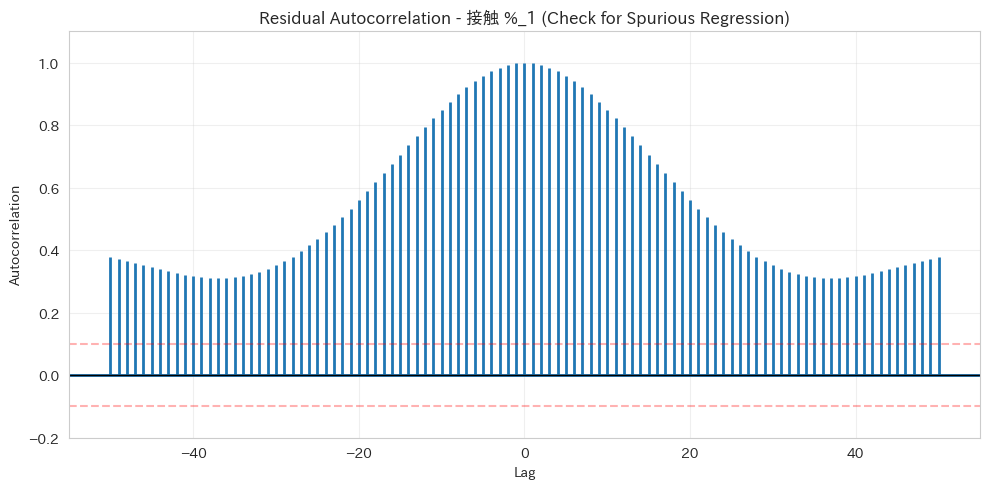

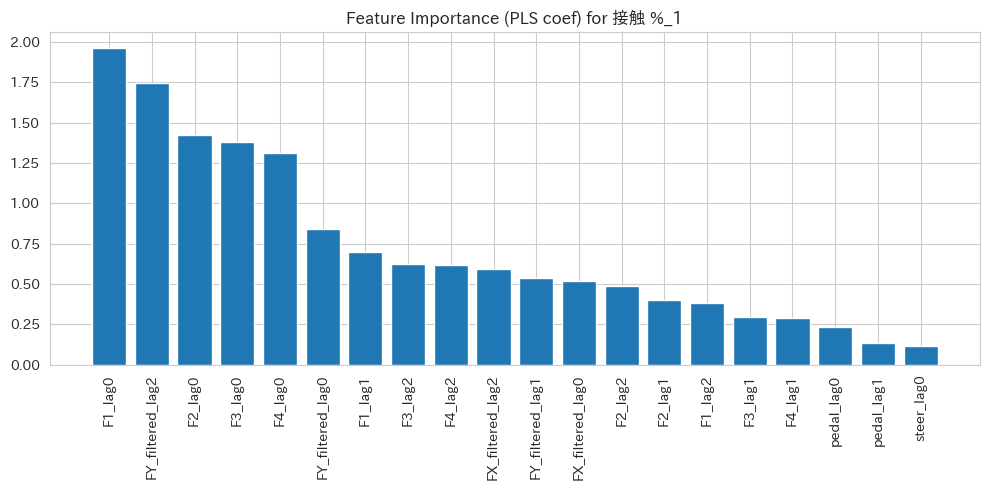

  Target: 接触 %_2          | R2: -409.5329
  Target: 接触 %_2     | Train: 26296 | R2: -409.5329


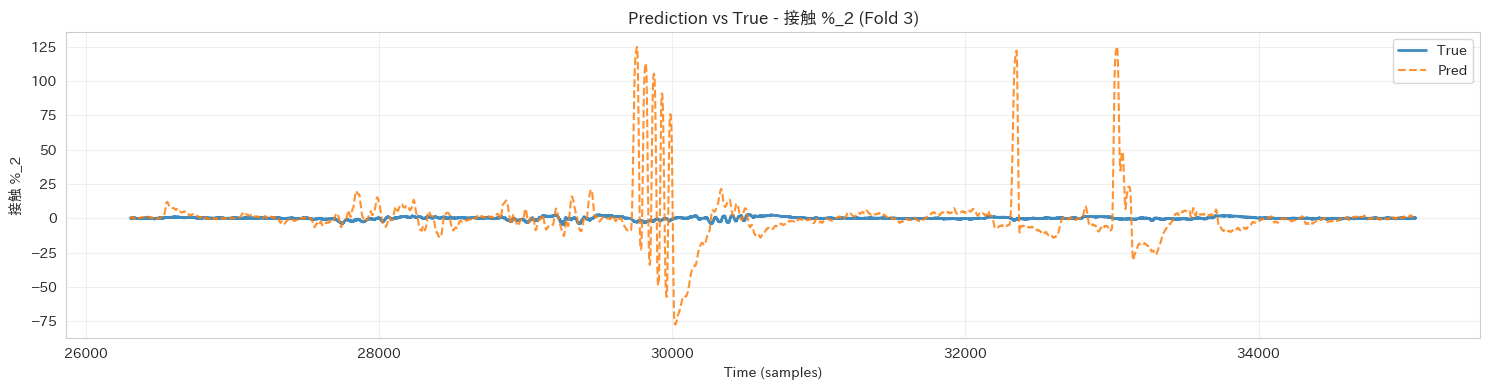

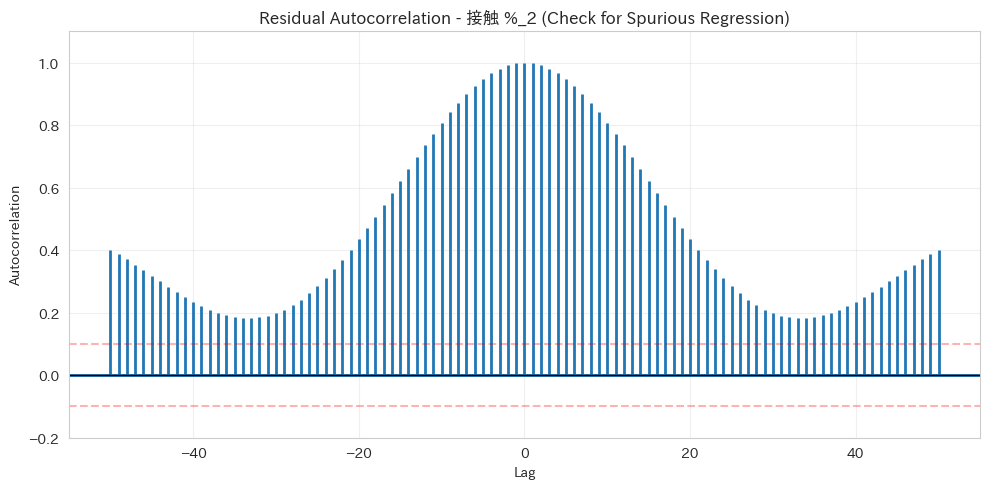

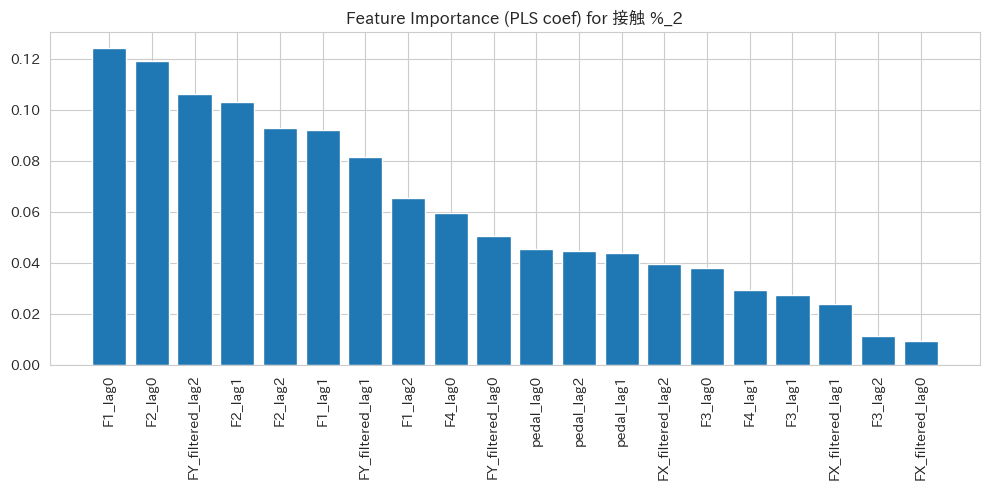

{'圧力中心列_2': [0.9292909623968576, -122.7193268032121, -236.3745766277008],
 '荷重(N)_1': [0.08125522146026354, -7070.25852497122, -323.9323615056171],
 '圧力中心行_1': [-0.05014247830156471, -14483.386984278553, -432.0496638364309],
 '圧力中心列_1': [-0.11030991579987925, -4799.249492390473, -60.35179572480894],
 'ピーク圧力_1': [-1.1660486937462116, -33499.42852609785, -156.88387571753452],
 '接触 %_1': [0.13295225195946214, -2290.9542290328386, -163.7760801900212],
 '接触 %_2': [-1.0650627683277567, -17830.971641099073, -409.5329178241683]}

In [4]:

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

# ==========================================
# 1. SubjectAwareSmoother (平滑化)
# ==========================================
class SubjectAwareSmoother(BaseEstimator, TransformerMixin):
    def __init__(self, window=15):
        self.window = window

    def _apply_rolling_mean(self, df):
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        cols_to_roll = [c for c in numeric_cols if c != 'subject_id']
        
        if 'subject_id' not in df.columns:
            return df[cols_to_roll].rolling(window=self.window, min_periods=1).mean()
        
        # GroupBy Rolling
        rolled = df.groupby('subject_id')[cols_to_roll].rolling(window=self.window, min_periods=1).mean()
        rolled = rolled.reset_index(level=0, drop=True).sort_index()
        return rolled

    def fit(self, X, y=None):
        return self

    def transform(self, X, X_context=None):
        X_out = X.copy()
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        target_cols = [c for c in numeric_cols if c != 'subject_id']

        if X_context is not None:
            X_combined = pd.concat([X_context.iloc[-self.window:], X])
            X_smooth_full = self._apply_rolling_mean(X_combined)
            X_smooth = X_smooth_full.iloc[-len(X):]
        else:
            X_smooth = self._apply_rolling_mean(X)
        
        X_out[target_cols] = X_smooth
        return X_out

# ==========================================
# 2. SubjectAwareDetrender (トレンド除去)
# ==========================================
class SubjectAwareDetrender(BaseEstimator, TransformerMixin):
    def __init__(self, window=300):
        self.window = window

    def _calculate_trend(self, df):
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        cols_to_roll = [c for c in numeric_cols if c != 'subject_id']
        
        if 'subject_id' not in df.columns:
            return df[cols_to_roll].rolling(window=self.window, min_periods=1).mean()
        
        # GroupBy Rolling
        rolled = df.groupby('subject_id')[cols_to_roll].rolling(window=self.window, min_periods=1).mean()
        rolled = rolled.reset_index(level=0, drop=True).sort_index()
        return rolled

    def fit(self, X, y=None):
        return self

    def transform(self, X, X_context=None):
        X_out = X.copy()
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        target_cols = [c for c in numeric_cols if c != 'subject_id']

        if X_context is not None:
            X_combined = pd.concat([X_context.iloc[-self.window:], X])
            trend_full = self._calculate_trend(X_combined)
            trend = trend_full.iloc[-len(X):]
        else:
            trend = self._calculate_trend(X)

        X_out[target_cols] = X_out[target_cols] - trend
        return X_out

# ==========================================
# 3. CausalFeatureGenerator (ラグ特徴量生成)
# ==========================================
class CausalFeatureGenerator:
    def __init__(self, control_lags):
        self.control_lags = control_lags

    def transform(self, X, y_target_col):
        features_df = pd.DataFrame(index=X.index)
        
        if 'subject_id' not in X.columns:
            groups = X.assign(temp_id=1).groupby('temp_id')
        else:
            groups = X.groupby('subject_id')

        # 使用する特徴量候補
        feature_vars = ['F1', 'F2', 'F3', 'F4', 'FX_filtered', 'FY_filtered','pedal', 'steer']
        
        for feature_var in feature_vars:
            if feature_var not in X.columns: continue
            
            control_key = f"{feature_var}→{y_target_col}"
            optimal_lag = self.control_lags.get(control_key, 0)
            
            # 指定ラグ周辺を含めて生成
            for lag in range(optimal_lag, optimal_lag + 3):
                features_df[f"{feature_var}_lag{lag}"] = groups[feature_var].shift(lag)

        return features_df

# ==========================================
# 4. SubjectAwareStandardizer (標準化)
# ==========================================
class SubjectAwareStandardizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stats_per_subject = {} 
        self.global_stats = {}      
        self.target_cols = []

    def fit(self, X, y=None):
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        self.target_cols = [c for c in numeric_cols if c != 'subject_id']

        # 1. Global Stats
        for col in self.target_cols:
            mean, std = X[col].mean(), X[col].std()
            if std == 0: std = 1.0
            self.global_stats[col] = (mean, std)

        # 2. Subject Stats
        if 'subject_id' in X.columns:
            grouped = X.groupby('subject_id')[self.target_cols].agg(['mean', 'std'])
            for subject_id, row in grouped.iterrows():
                self.stats_per_subject[subject_id] = {}
                for col in self.target_cols:
                    m = row[(col, 'mean')]
                    s = row[(col, 'std')]
                    if pd.isna(s) or s == 0: s = 1.0
                    self.stats_per_subject[subject_id][col] = (m, s)
        return self

    def transform(self, X):
        X_out = X.copy()
        
        # Subjectが無い場合
        if 'subject_id' not in X.columns:
            for col in self.target_cols:
                if col in X_out.columns:
                    m, s = self.global_stats[col]
                    X_out[col] = (X_out[col] - m) / s
            return X_out

        # Subjectがある場合 (Mapによる高速化)
        for col in self.target_cols:
            if col not in X_out.columns: continue

            mean_map, std_map = {}, {}
            g_mean, g_std = self.global_stats[col]

            for uid in X_out['subject_id'].unique():
                if uid in self.stats_per_subject:
                    mean_map[uid] = self.stats_per_subject[uid][col][0]
                    std_map[uid]  = self.stats_per_subject[uid][col][1]
                else:
                    mean_map[uid] = g_mean
                    std_map[uid]  = g_std
            
            means = X_out['subject_id'].map(mean_map)
            stds  = X_out['subject_id'].map(std_map)
            X_out[col] = (X_out[col] - means) / stds

        return X_out

# ==========================================
# 5. SimplePLSModel
# ==========================================
class SimplePLSModel:
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.model = None

    def fit(self, X, y):
        self.model = PLSRegression(n_components=min(self.n_components, X.shape[1]))
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

def plot_prediction_waveform(y_true, y_pred, y_col, fold_id=None):
    """
    y_true : numpy array
    y_pred : numpy array
    y_col  : どのターゲットか（例: 'COP_X'）
    fold_id: どのfoldか（オプション）
    """
    plt.figure(figsize=(15, 4))
    
    plt.plot(y_true, label="True", linewidth=2, alpha=0.85)
    plt.plot(y_pred, label="Pred", linewidth=1.5, linestyle='--', alpha=0.85)
    
    title = f"Prediction vs True - {y_col}"
    if fold_id is not None:
        title += f" (Fold {fold_id})"
    plt.title(title)
    
    plt.xlabel("Time (samples)")
    plt.ylabel(y_col)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
def plot_feature_importance(pls_model, feature_names, y_col):
    """
    PLS の特徴量重要度を棒グラフで可視化する
    - pls_model : SimplePLSModel.model (PLSRegression)
    - feature_names : X の列名
    - y_col : どのターゲット向けのモデルか
    """
    # 係数を取得（shape: n_features x n_targets）
    coefs = pls_model.coef_.flatten()

    # 重要度 = |係数|
    importance = np.abs(coefs)

    # 大きい順にソート
    idx = np.argsort(importance)[::-1]
    sorted_importance = importance[idx]
    sorted_features = np.array(feature_names)[idx]

    plt.figure(figsize=(10, 5))
    plt.bar(sorted_features[:20], sorted_importance[:20])  # 上位20個だけ描画（多すぎるため）
    plt.xticks(rotation=90)
    plt.title(f"Feature Importance (PLS coef) for {y_col}")
    plt.tight_layout()
    plt.show()

def plot_residual_acorrelation(y_true, y_pred, y_col):
    """
    残差の自己相関（Autocorrelation）をプロットする関数
    修正点: y_true が DataFrame の場合に Series に変換する処理を追加
    """
    # ★修正: y_true が DataFrame なら Series (1次元) に変換する
    if isinstance(y_true, pd.DataFrame):
        # 1列目のデータをSeriesとして取り出す
        y_true = y_true.iloc[:, 0]
    
    # 残差の計算 (Series同士の計算になるので安全)
    resid = y_true - y_pred
    
    # NaNや無限大が含まれているとエラーになるので除去
    resid = resid.dropna()
    resid = resid[np.isfinite(resid)]
    
    # numpy array に変換して flatten (念には念を入れて1次元化)
    resid_values = resid.values.flatten()

    plt.figure(figsize=(10, 5))
    
    # acorrプロット
    # maxlags: データ点数が少ない場合は len(resid)//2 程度に抑えるのが安全
    lags = min(50, len(resid_values) // 2)
    
    plt.acorr(resid_values, maxlags=lags, usevlines=True, normed=True, lw=2)
    
    plt.title(f"Residual Autocorrelation - {y_col} (Check for Spurious Regression)")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.grid(True, alpha=0.3)
    plt.ylim(-0.2, 1.1) 
    
    # 目安ライン
    plt.axhline(0, color='black', lw=1)
    plt.axhline(0.1, color='red', linestyle='--', alpha=0.3)
    plt.axhline(-0.1, color='red', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ==========================================
# Main Execution Pipeline
# ==========================================
def run_corrected_pipeline(X_raw, y_raw, scale_y=False):
    """
    scale_y (bool): 
      True  -> yも標準化する（評価指標は標準偏差単位になる）
      False -> yは標準化しない（評価指標はmmやNなどの物理単位になる）※実務推奨
    """
    
    print("=" * 60)
    print("修正版パイプライン: Smooth -> Detrend -> Lag -> Scale")
    print("=" * 60)

    # 0. 前提チェック
    if 'subject_id' not in X_raw.columns:
        X_raw = X_raw.assign(subject_id=1)
    
    tscv = TimeSeriesSplit(n_splits=3)
    all_scores = {col: [] for col in y_raw.columns}
    
    # プロセッサ初期化
    smoother = SubjectAwareSmoother(window=15)
    detrender = SubjectAwareDetrender(window=300)
    # StandardizerはFold内でfitするため、ここではクラス定義のみ確認
    
    # ラグ設定
    control_lags = {'steer→圧力中心列_2': 10, 'pedal→圧力中心列_2': 40} 
    generator = CausalFeatureGenerator(control_lags)
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_raw)):
        print(f"\n--- Fold {fold+1} ---")
        
        # 1. データ分割
        X_train_raw = X_raw.iloc[train_idx].copy()
        y_train_raw = y_raw.iloc[train_idx].copy()
        X_test_raw = X_raw.iloc[test_idx].copy()
        y_test_raw = y_raw.iloc[test_idx].copy()

        # Detrend用の一時ID付与
        y_train_raw['subject_id'] = X_train_raw['subject_id']
        y_test_raw['subject_id'] = X_test_raw['subject_id']

        # 2. Smoothing
        X_train_smooth = smoother.transform(X_train_raw)
        X_test_smooth = smoother.transform(X_test_raw, X_context=X_train_raw)

        # 3. Detrending
        X_train_detrend = detrender.transform(X_train_smooth)
        y_train_detrend = detrender.transform(y_train_raw)
        
        X_test_detrend = detrender.transform(X_test_smooth, X_context=X_train_smooth)
        y_test_detrend = detrender.transform(y_test_raw, X_context=y_train_raw)

        # 4. Feature Generation Loop
        for y_col in [c for c in y_raw.columns if c != 'subject_id']:
            
            # Shift & Lag
            X_train_feats = generator.transform(X_train_detrend, y_col)
            X_test_feats = generator.transform(X_test_detrend, y_col)
            
            # ID復帰
            X_train_feats['subject_id'] = X_train_detrend['subject_id'].values
            X_test_feats['subject_id'] = X_test_detrend['subject_id'].values
            
            # Target設定
            y_train_target = y_train_detrend[[y_col, 'subject_id']]
            y_test_target = y_test_detrend[[y_col, 'subject_id']]

            # DropNa
            common_idx_train = X_train_feats.dropna().index.intersection(y_train_target.dropna().index)
            X_train_clean = X_train_feats.loc[common_idx_train]
            y_train_clean = y_train_target.loc[common_idx_train]
            
            common_idx_test = X_test_feats.dropna().index.intersection(y_test_target.dropna().index)
            X_test_clean = X_test_feats.loc[common_idx_test]
            y_test_clean = y_test_target.loc[common_idx_test]

            if len(X_train_clean) < 100: continue

            # ----------------------------------------------------
            # 5. Standardization (Optionによる分岐)
            # ----------------------------------------------------
            # Xは常に標準化する
            scaler_x = SubjectAwareStandardizer()
            scaler_x.fit(X_train_clean)
            
            X_train_final = scaler_x.transform(X_train_clean).drop(columns=['subject_id'], errors='ignore')
            X_test_final  = scaler_x.transform(X_test_clean).drop(columns=['subject_id'], errors='ignore')

            # yの処理分岐
            if scale_y:
                # 標準化する (従来パターン)
                scaler_y = SubjectAwareStandardizer()
                scaler_y.fit(y_train_clean)
                y_train_final = scaler_y.transform(y_train_clean).drop(columns=['subject_id'], errors='ignore')
                y_test_final  = scaler_y.transform(y_test_clean).drop(columns=['subject_id'], errors='ignore')
                unit_label = "std (σ)"
            else:
                # 標準化しない (物理単位パターン: Detrend済みの値を使う)
                y_train_final = y_train_clean.drop(columns=['subject_id'], errors='ignore')
                y_test_final  = y_test_clean.drop(columns=['subject_id'], errors='ignore')
                unit_label = "physical"

            # ----------------------------------------------------
            # 6. Modeling
            # ----------------------------------------------------
            model = SimplePLSModel(n_components=5)
            model.fit(X_train_final, y_train_final)
            # 生のNumPy配列 (インデックス情報なし: 0, 1, 2...)
            y_pred_raw = model.predict(X_test_final)

            # ★ここでインデックスを復元する★ # shapeが(N, 1)になっていることが多いので flatten() して1次元にする
            y_pred = pd.Series(y_pred_raw.flatten(), index=y_test_final.index)
            
            r2 = r2_score(y_test_final, y_pred)
            print(f"  Target: {y_col:<15} | R2: {r2:.4f}")
            all_scores[y_col].append(r2)
            
            print(f"  Target: {y_col:<10} | Train: {len(X_train_clean)} | R2: {r2:.4f}")
            
            if fold == tscv.n_splits - 1: # 最終Foldだけプロット
                # 1. 予測波形のプロット（既存）
                plot_prediction_waveform(y_test_final, y_pred, y_col, fold_id=fold+1)
                
                # 2. 【追加】残差の自己相関チェック（見せかけ回帰検出）
                plot_residual_acorrelation(y_test_final, y_pred, y_col)

                # 3. 特徴量重要度プロット（既存）
                feature_names = X_train_final.columns
                plot_feature_importance(model.model, feature_names, y_col)

    return all_scores

mock_sensor_cols = ['F1', 'F2', 'F3', 'F4','FX_filtered','FY_filtered' ,'pedal','steer','subject_id'] 
target_features_A = ['圧力中心列_2', '荷重(N)_1', '圧力中心行_1', '圧力中心列_1','ピーク圧力_1','接触 %_1','接触 %_2']  # 目標圧力変数

# 列が存在するかチェック
available_cols = df_all.columns.tolist()
X_cols = [c for c in mock_sensor_cols if c in available_cols]
Y_cols = [c for c in target_features_A if c in available_cols]
print(f"入力変数(X): {X_cols}")
print(f"出力変数(Y): {Y_cols}")

if len(X_cols) == 0:
    raise ValueError("エラー: モドキセンサの列が見つかりません。列名を修正してください。")
df_raw = df_all[X_cols + Y_cols].dropna()
X_raw = df_raw[X_cols]
y_raw = df_raw[Y_cols]

run_corrected_pipeline(X_raw, y_raw, scale_y=False)


入力変数(X): ['F1', 'F2', 'F3', 'F4', 'FX_filtered', 'FY_filtered', 'pedal', 'steer', 'subject_id']
出力変数(Y): ['圧力中心列_2', '荷重(N)_1', '圧力中心行_1', '圧力中心列_1', 'ピーク圧力_1', '接触 %_1', '接触 %_2']
修正版パイプライン: Smooth -> Detrend -> Lag -> Scale
🚀 改良版パイプライン: Hold-out Subject Mode (Test IDs: [7])
   ※ 未知の被験者に対する汎化性能を評価します

--- Fold 1 ---
Validation Type: Unknown Subject (Generalization)
  Target: 圧力中心列_2         | R2: 0.8365
  Target: 圧力中心列_2    | Train: 26086 | R2: 0.8365


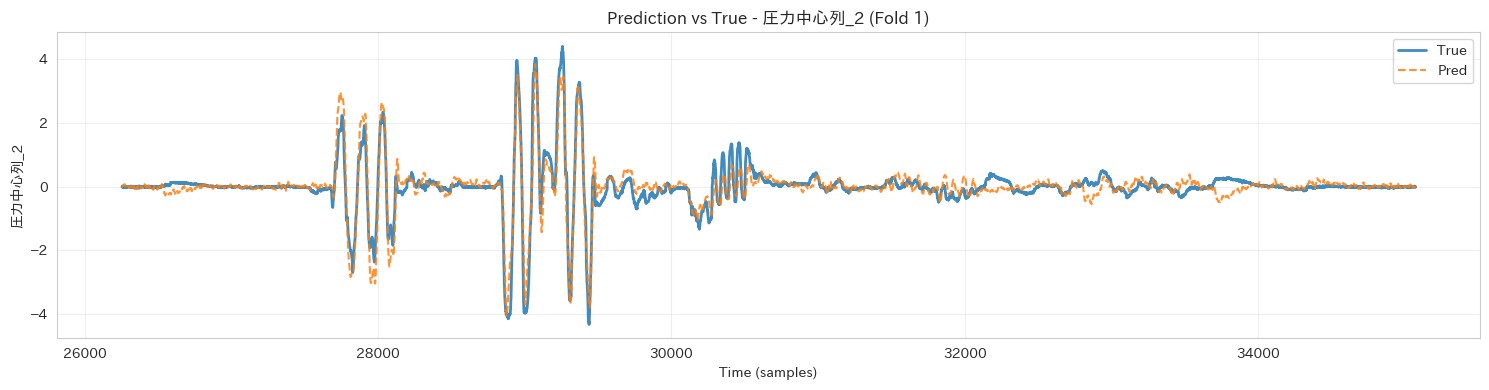

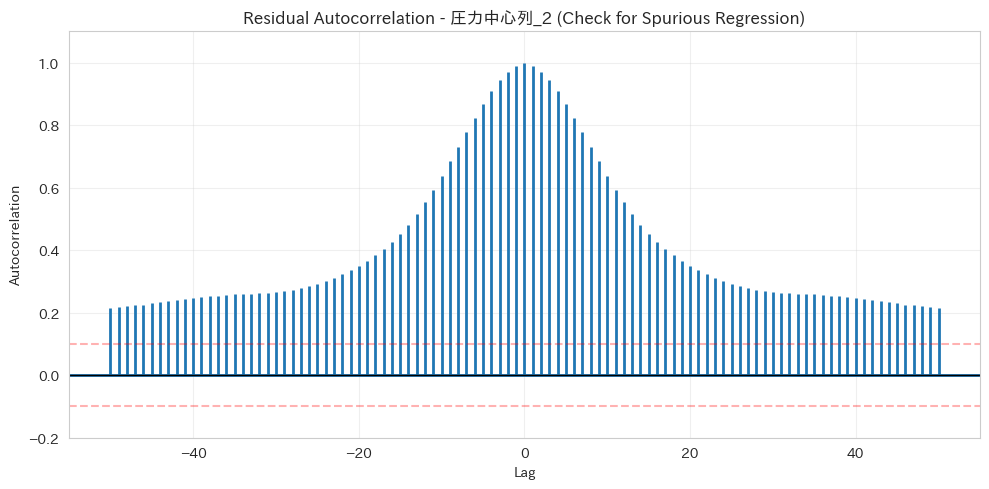

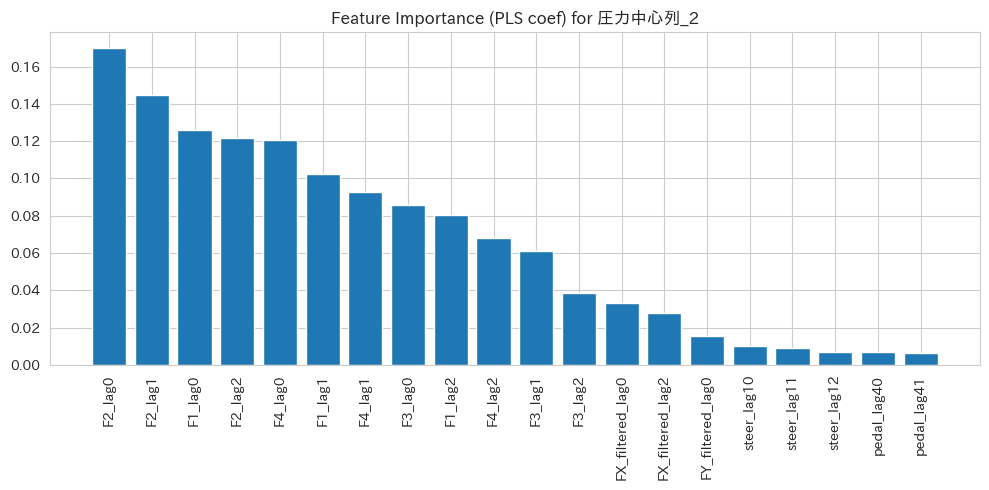

  Target: 荷重(N)_1         | R2: 0.7730
  Target: 荷重(N)_1    | Train: 26206 | R2: 0.7730


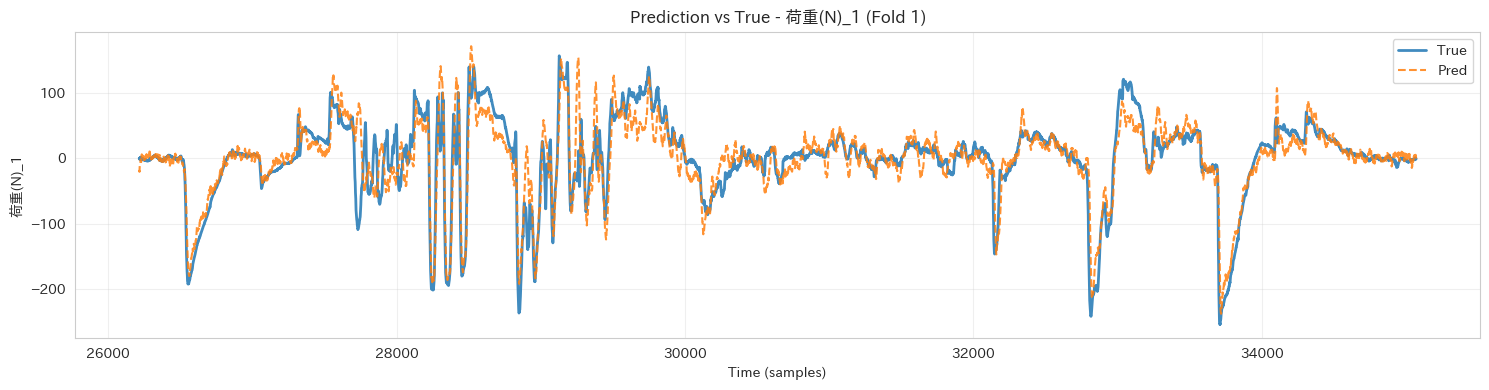

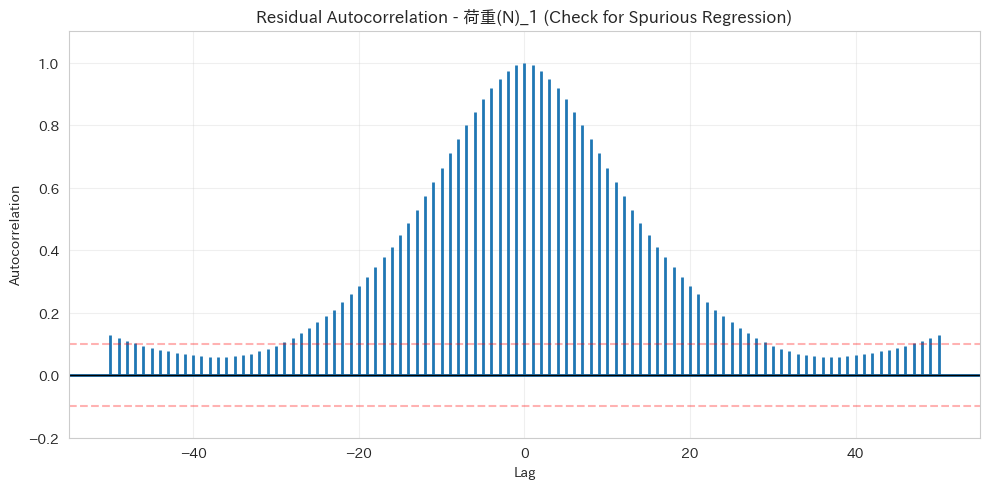

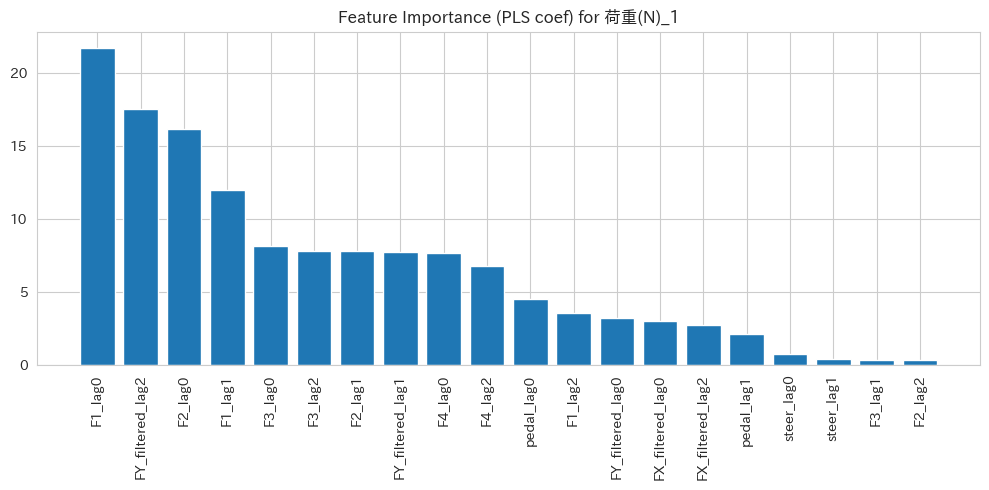

  Target: 圧力中心行_1         | R2: 0.4562
  Target: 圧力中心行_1    | Train: 26206 | R2: 0.4562


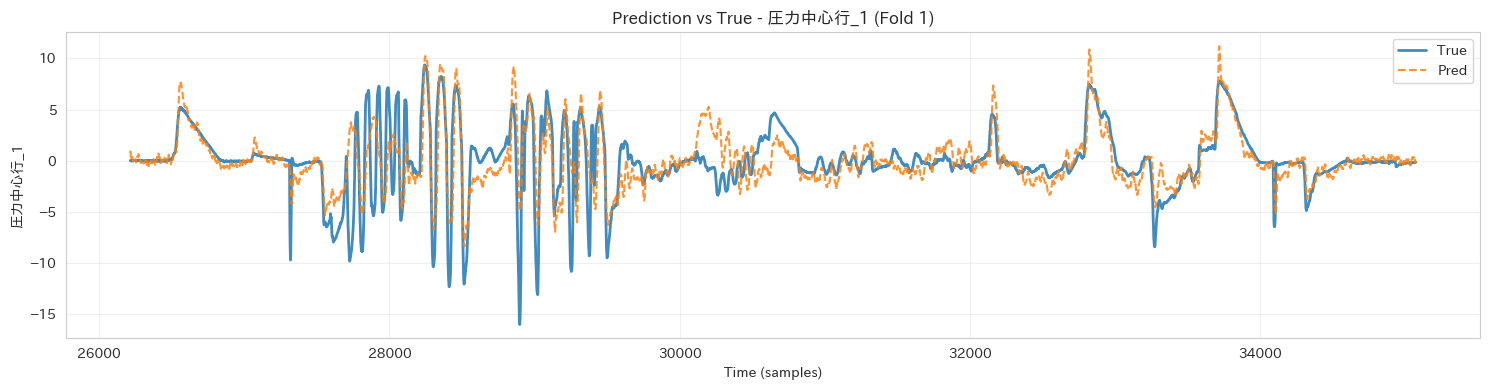

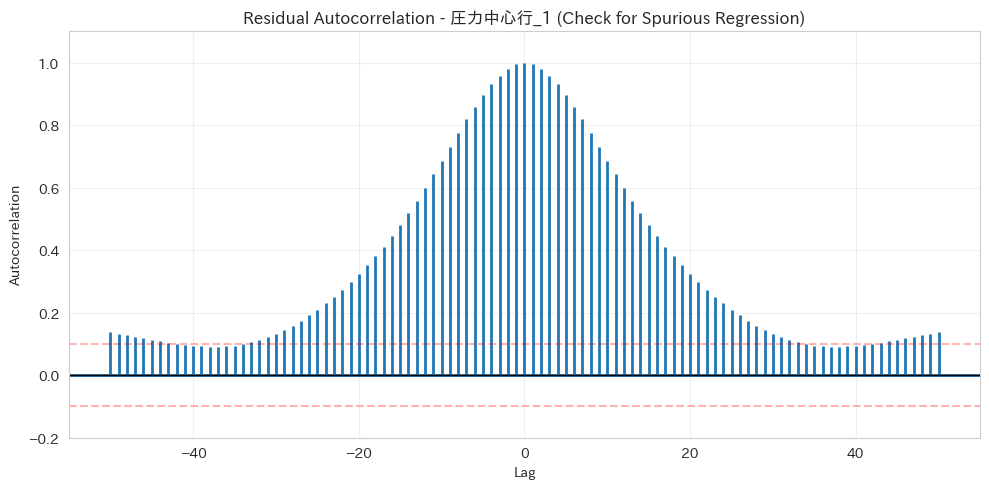

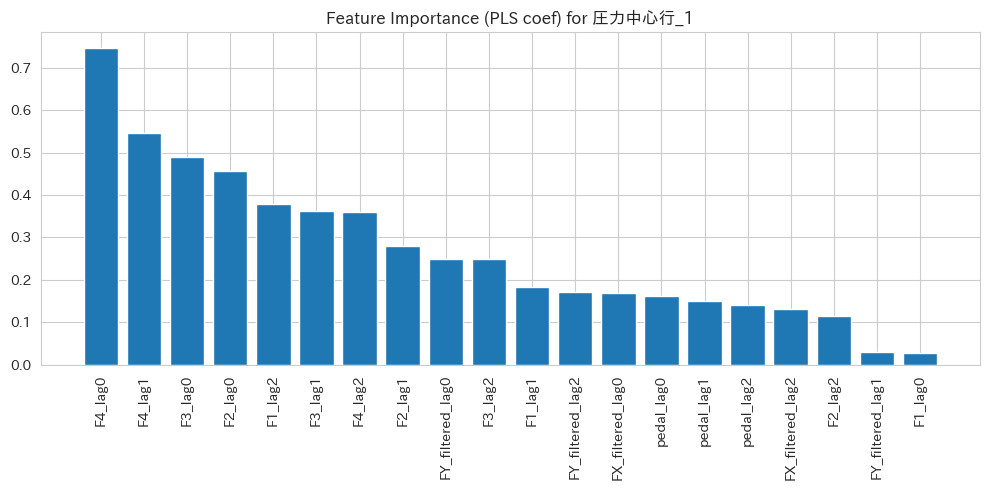

  Target: 圧力中心列_1         | R2: 0.7990
  Target: 圧力中心列_1    | Train: 26206 | R2: 0.7990


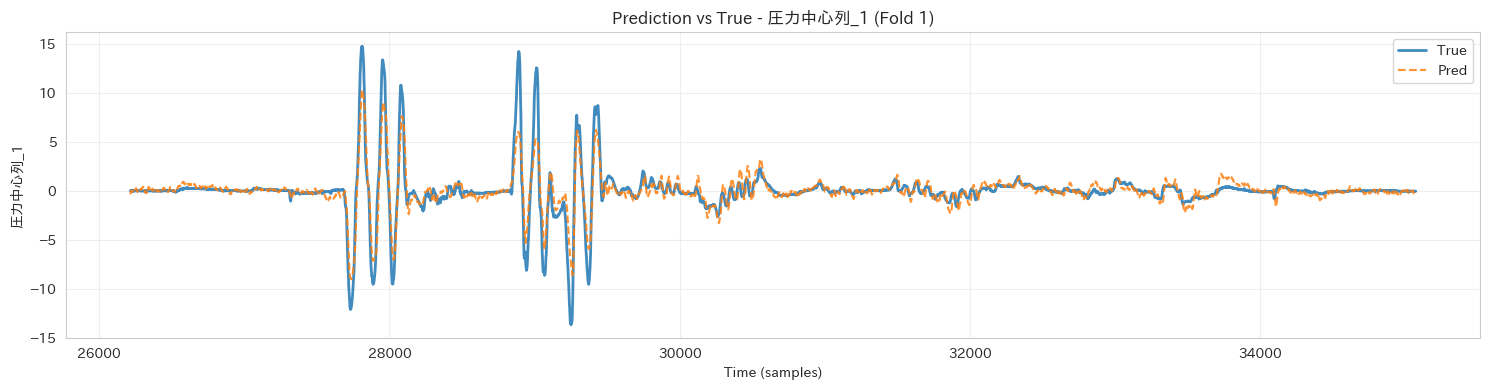

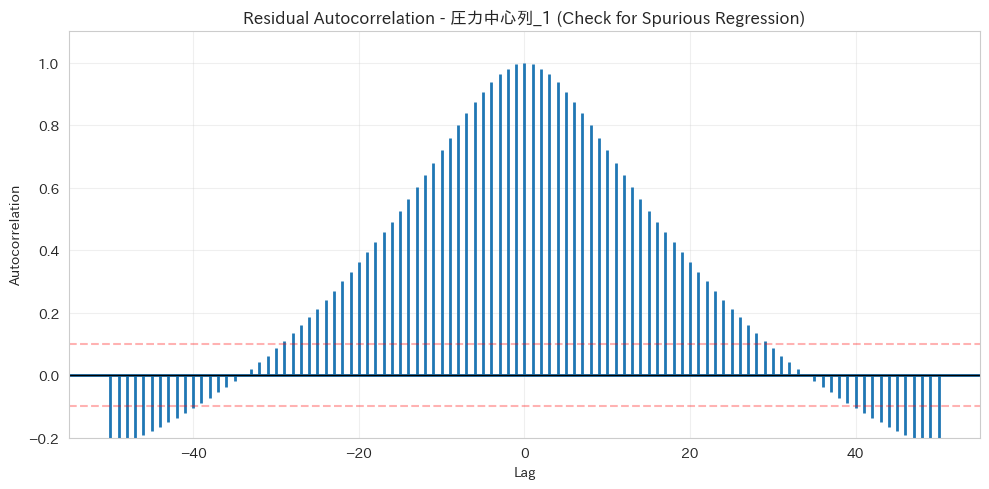

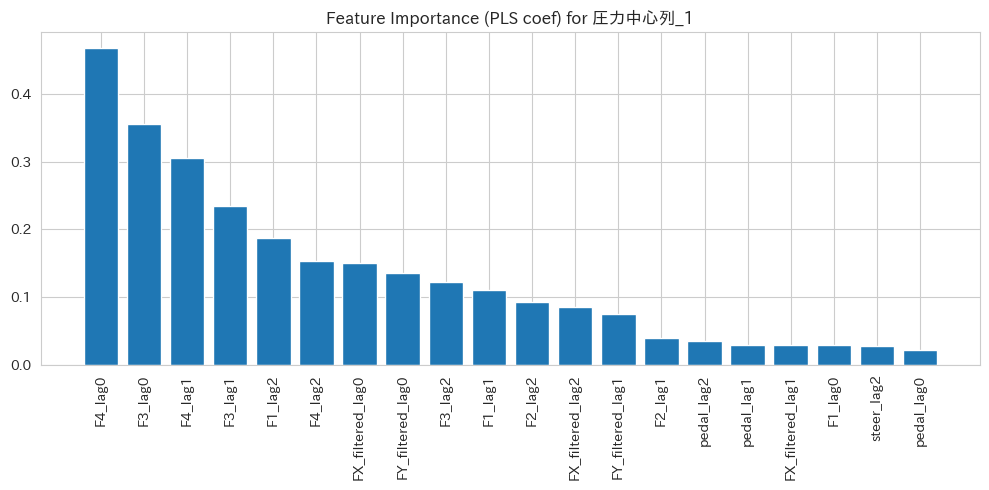

  Target: ピーク圧力_1         | R2: 0.1610
  Target: ピーク圧力_1    | Train: 26206 | R2: 0.1610


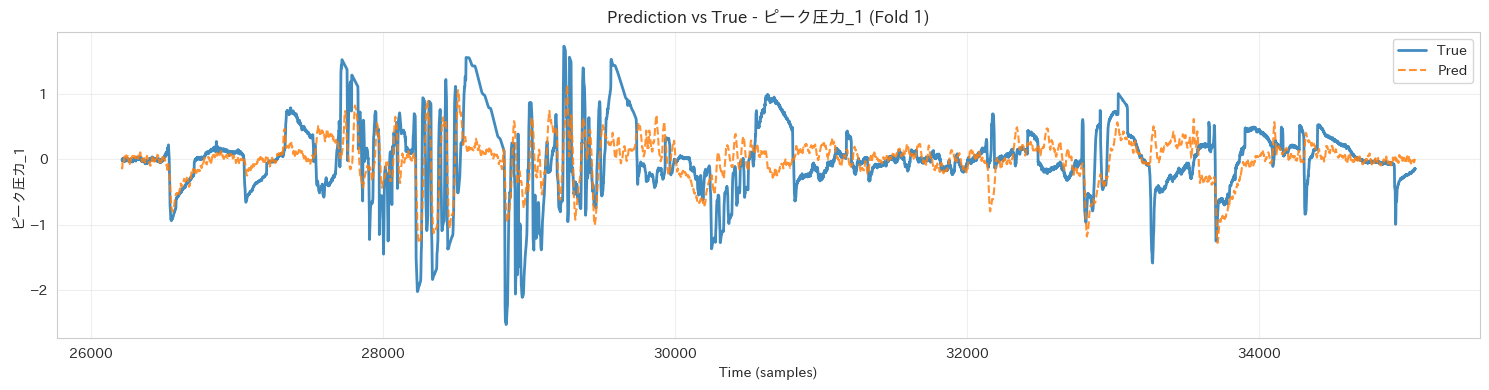

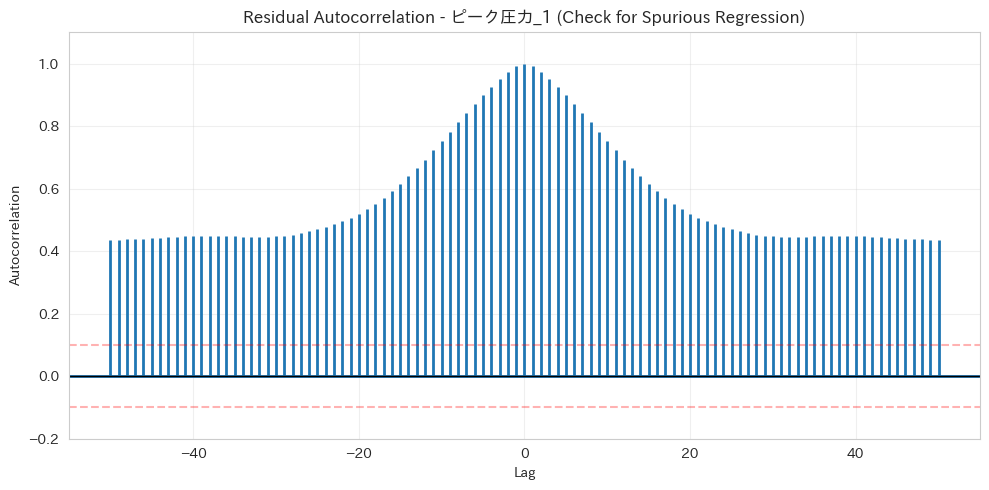

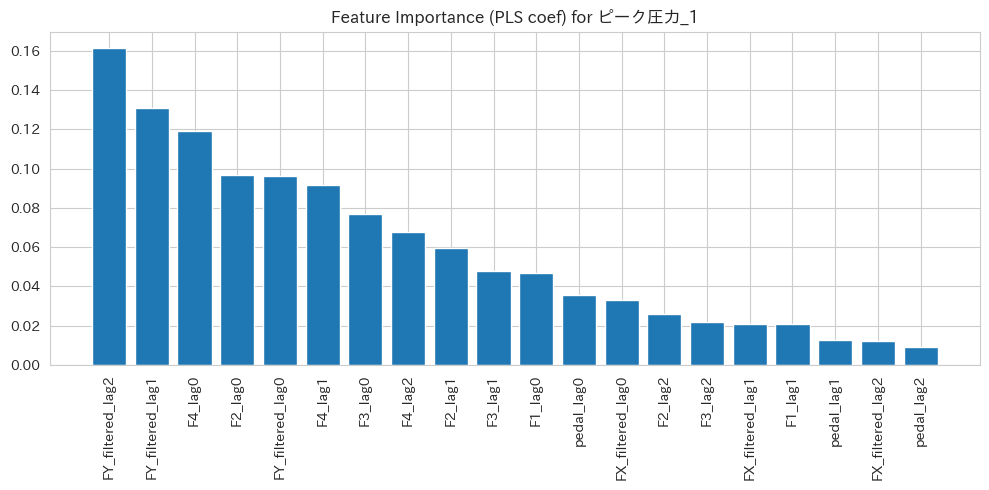

  Target: 接触 %_1          | R2: 0.7025
  Target: 接触 %_1     | Train: 26206 | R2: 0.7025


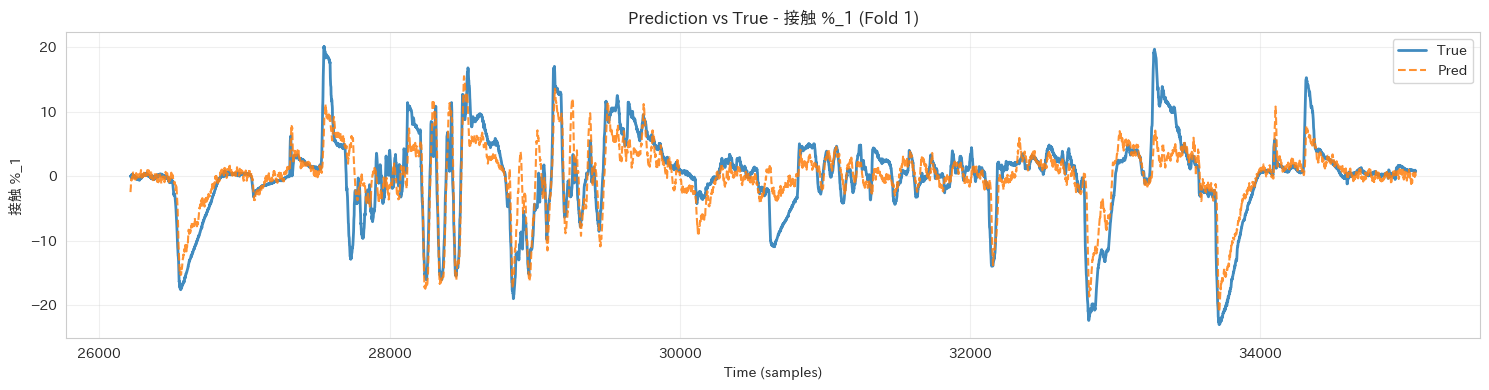

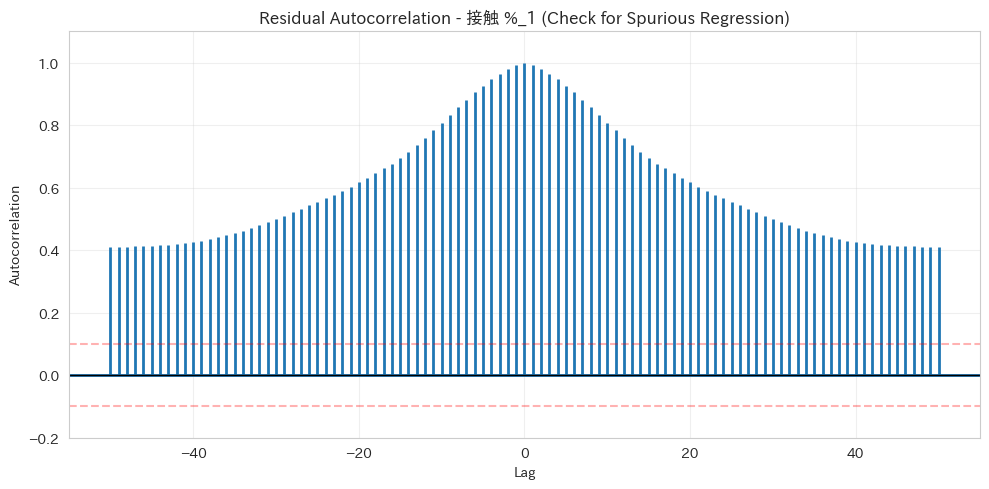

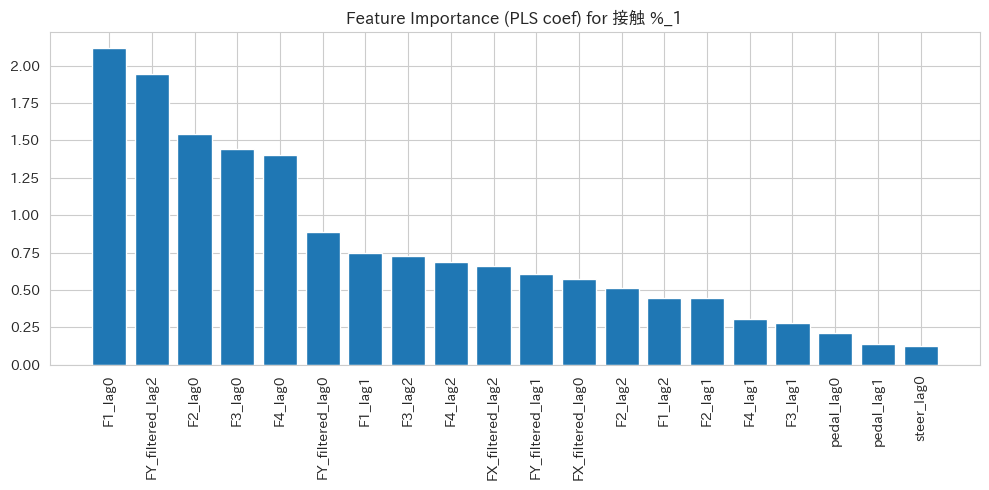

  Target: 接触 %_2          | R2: -0.0770
  Target: 接触 %_2     | Train: 26206 | R2: -0.0770


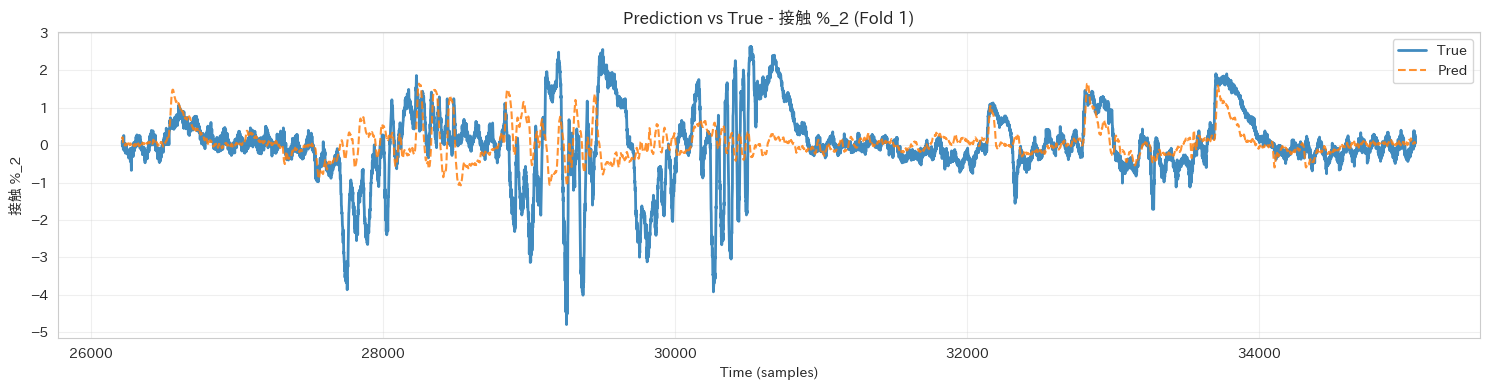

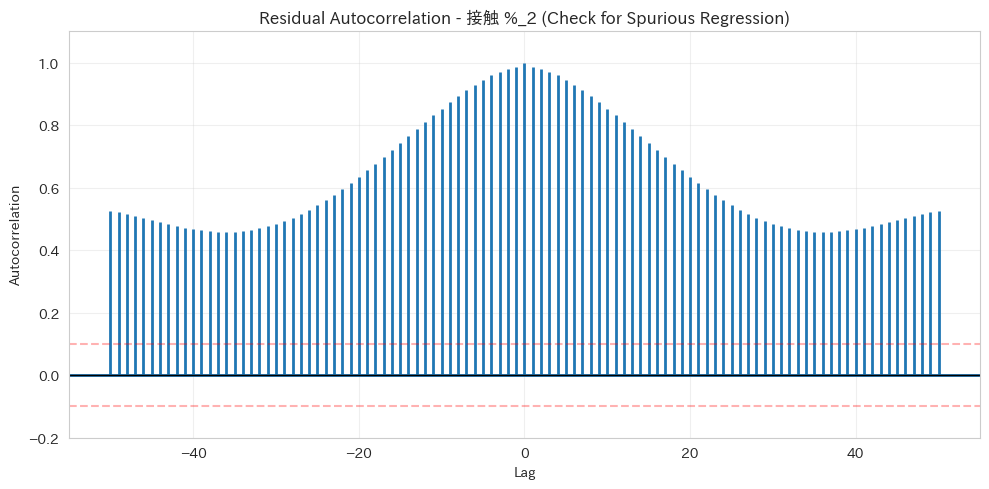

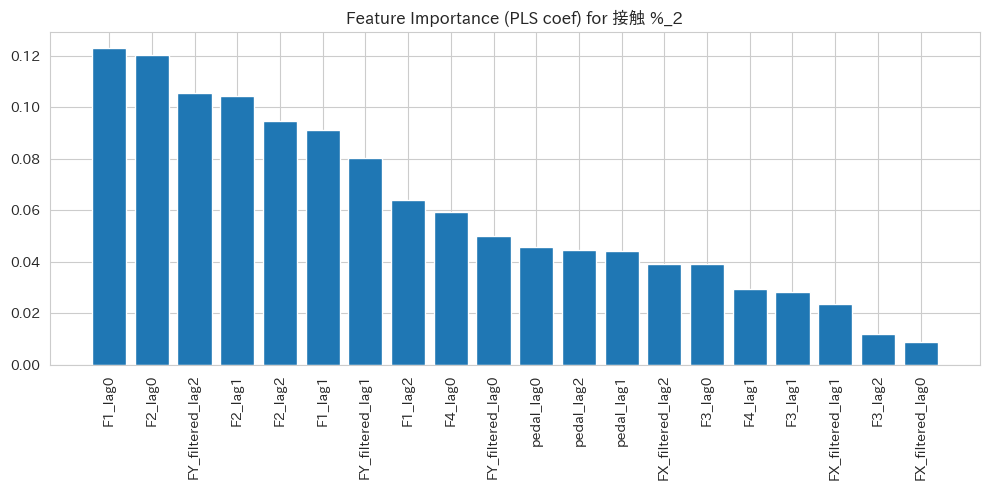

{'圧力中心列_2': [0.8364581413853099],
 '荷重(N)_1': [0.7730194167182323],
 '圧力中心行_1': [0.4561536057620903],
 '圧力中心列_1': [0.7990320982237276],
 'ピーク圧力_1': [0.1609540800581064],
 '接触 %_1': [0.7025111175602199],
 '接触 %_2': [-0.0769545376038101]}

In [5]:

def run_corrected_pipeline(X_raw, y_raw, scale_y=False,holdout_subject_ids=None):
    """
    scale_y (bool): 
      True  -> yも標準化する（評価指標は標準偏差単位になる）
      False -> yは標準化しない（評価指標はmmやNなどの物理単位になる）※実務推奨
    """
    
    print("=" * 60)
    print("修正版パイプライン: Smooth -> Detrend -> Lag -> Scale")
    if holdout_subject_ids is not None:
        if isinstance(holdout_subject_ids, int): holdout_subject_ids = [holdout_subject_ids]
        print(f"🚀 改良版パイプライン: Hold-out Subject Mode (Test IDs: {holdout_subject_ids})")
        print("   ※ 未知の被験者に対する汎化性能を評価します")
    else:
        print("🚀 改良版パイプライン: TimeSeriesSplit Mode")
        print("   ※ 時系列的な未来予測性能を評価します")
    print("=" * 60)

    # 0. 前提チェック
    if 'subject_id' not in X_raw.columns:
        X_raw = X_raw.assign(subject_id=1)
    
    if holdout_subject_ids is not None:
        # 【新機能】指定IDをテストにする (Trainに含まない)
        # rawデータのindexではなく、行番号(iloc用)を取得する必要がある
        mask_test = X_raw['subject_id'].isin(holdout_subject_ids)
        
        if mask_test.sum() == 0:
            raise ValueError(f"指定されたID {holdout_subject_ids} はデータ内に存在しません。")
        
        train_indices = np.where(~mask_test)[0]
        test_indices  = np.where(mask_test)[0]
        
        # 1回だけの分割としてリスト化 (CVループと互換性を持たせる)
        cv_splits = [(train_indices, test_indices)]
        
    else:
        # 【従来】時系列分割
        tscv = TimeSeriesSplit(n_splits=3)
        cv_splits = tscv.split(X_raw)

    
    # プロセッサ初期化
    smoother = SubjectAwareSmoother(window=15)
    detrender = SubjectAwareDetrender(window=300)
    
    # ラグ設定
    control_lags = {'steer→圧力中心列_2': 10, 'pedal→圧力中心列_2': 40} 
    generator = CausalFeatureGenerator(control_lags)
    
    all_scores = {col: [] for col in y_raw.columns}

    for fold, (train_idx, test_idx) in enumerate(cv_splits):
        print(f"\n--- Fold {fold+1} ---")
        if holdout_subject_ids is not None:
            print("Validation Type: Unknown Subject (Generalization)")
        
        # 1. データ分割
        X_train_raw = X_raw.iloc[train_idx].copy()
        y_train_raw = y_raw.iloc[train_idx].copy()
        X_test_raw = X_raw.iloc[test_idx].copy()
        y_test_raw = y_raw.iloc[test_idx].copy()

        # Detrend用の一時ID付与
        y_train_raw['subject_id'] = X_train_raw['subject_id']
        y_test_raw['subject_id'] = X_test_raw['subject_id']

        # ★重要: Contextの設定
        # Hold-outモードの場合、TrainとTestは「別人」なので連続性がない。
        # そのため、Testの変換時にTrainをContextとして渡してはいけない。
        if holdout_subject_ids is not None:
            X_context_data = None
            y_context_data = None
        else:
            X_context_data = X_train_raw
            y_context_data = y_train_raw


        # 2. Smoothing
        X_train_smooth = smoother.transform(X_train_raw)
        X_test_smooth = smoother.transform(X_test_raw, X_context=X_context_data)

        # 3. Detrending
        X_train_detrend = detrender.transform(X_train_smooth)
        y_train_detrend = detrender.transform(y_train_raw)
        
        X_test_detrend = detrender.transform(X_test_smooth, X_context=X_context_data)
        y_test_detrend = detrender.transform(y_test_raw, X_context=y_context_data)

        # 4. Feature Generation Loop
        for y_col in [c for c in y_raw.columns if c != 'subject_id']:
            
            # Shift & Lag
            X_train_feats = generator.transform(X_train_detrend, y_col)
            X_test_feats = generator.transform(X_test_detrend, y_col)
            
            # ID復帰
            X_train_feats['subject_id'] = X_train_detrend['subject_id'].values
            X_test_feats['subject_id'] = X_test_detrend['subject_id'].values
            
            # Target設定
            y_train_target = y_train_detrend[[y_col, 'subject_id']]
            y_test_target = y_test_detrend[[y_col, 'subject_id']]

            # DropNa
            common_idx_train = X_train_feats.dropna().index.intersection(y_train_target.dropna().index)
            X_train_clean = X_train_feats.loc[common_idx_train]
            y_train_clean = y_train_target.loc[common_idx_train]
            
            common_idx_test = X_test_feats.dropna().index.intersection(y_test_target.dropna().index)
            X_test_clean = X_test_feats.loc[common_idx_test]
            y_test_clean = y_test_target.loc[common_idx_test]

            if len(X_train_clean) < 100: continue

            # ----------------------------------------------------
            # 5. Standardization (Optionによる分岐)
            # ----------------------------------------------------
            # Xは常に標準化する
            scaler_x = SubjectAwareStandardizer()
            scaler_x.fit(X_train_clean)
            
            X_train_final = scaler_x.transform(X_train_clean).drop(columns=['subject_id'], errors='ignore')
            X_test_final  = scaler_x.transform(X_test_clean).drop(columns=['subject_id'], errors='ignore')

            # yの処理分岐
            if scale_y:
                # 標準化する (従来パターン)
                scaler_y = SubjectAwareStandardizer()
                scaler_y.fit(y_train_clean)
                y_train_final = scaler_y.transform(y_train_clean).drop(columns=['subject_id'], errors='ignore')
                y_test_final  = scaler_y.transform(y_test_clean).drop(columns=['subject_id'], errors='ignore')
                unit_label = "std (σ)"
            else:
                # 標準化しない (物理単位パターン: Detrend済みの値を使う)
                y_train_final = y_train_clean.drop(columns=['subject_id'], errors='ignore')
                y_test_final  = y_test_clean.drop(columns=['subject_id'], errors='ignore')
                unit_label = "physical"

            # ----------------------------------------------------
            # 6. Modeling
            # ----------------------------------------------------
            model = SimplePLSModel(n_components=5)
            model.fit(X_train_final, y_train_final)
            # 生のNumPy配列 (インデックス情報なし: 0, 1, 2...)
            y_pred_raw = model.predict(X_test_final)

            # ★ここでインデックスを復元する★ # shapeが(N, 1)になっていることが多いので flatten() して1次元にする
            y_pred = pd.Series(y_pred_raw.flatten(), index=y_test_final.index)
            
            r2 = r2_score(y_test_final, y_pred)
            print(f"  Target: {y_col:<15} | R2: {r2:.4f}")
            all_scores[y_col].append(r2)
            
            print(f"  Target: {y_col:<10} | Train: {len(X_train_clean)} | R2: {r2:.4f}")
            # プロット（Hold-outモードなら毎回、CVなら最後だけ）
            is_last_fold = (fold == len(list(cv_splits)) - 1) if not isinstance(cv_splits, list) else True
            
            if holdout_subject_ids is not None or is_last_fold:
                # 1. 予測波形のプロット（既存）
                plot_prediction_waveform(y_test_final, y_pred, y_col, fold_id=fold+1)
                
                # 2. 【追加】残差の自己相関チェック（見せかけ回帰検出）
                plot_residual_acorrelation(y_test_final, y_pred, y_col)

                # 3. 特徴量重要度プロット（既存）
                feature_names = X_train_final.columns
                plot_feature_importance(model.model, feature_names, y_col)

    return all_scores

mock_sensor_cols = ['F1', 'F2', 'F3', 'F4','FX_filtered','FY_filtered' ,'pedal','steer','subject_id'] 
target_features_A = ['圧力中心列_2', '荷重(N)_1', '圧力中心行_1', '圧力中心列_1','ピーク圧力_1','接触 %_1','接触 %_2']  # 目標圧力変数

# 列が存在するかチェック
available_cols = df_all.columns.tolist()
X_cols = [c for c in mock_sensor_cols if c in available_cols]
Y_cols = [c for c in target_features_A if c in available_cols]
print(f"入力変数(X): {X_cols}")
print(f"出力変数(Y): {Y_cols}")

if len(X_cols) == 0:
    raise ValueError("エラー: モドキセンサの列が見つかりません。列名を修正してください。")
df_raw = df_all[X_cols + Y_cols].dropna()
X_raw = df_raw[X_cols]
y_raw = df_raw[Y_cols]

run_corrected_pipeline(X_raw, y_raw, scale_y=False,holdout_subject_ids=[7])

# 見せかけの回帰対策

In [31]:

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

# ==========================================
# 1. SubjectAwareSmoother (平滑化)
# ==========================================
class SubjectAwareSmoother(BaseEstimator, TransformerMixin):
    def __init__(self, window=15):
        self.window = window

    def _apply_rolling_mean(self, df):
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        cols_to_roll = [c for c in numeric_cols if c != 'subject_id']
        
        if 'subject_id' not in df.columns:
            return df[cols_to_roll].rolling(window=self.window, min_periods=1).mean()
        
        # GroupBy Rolling
        rolled = df.groupby('subject_id')[cols_to_roll].rolling(window=self.window, min_periods=1).mean()
        rolled = rolled.reset_index(level=0, drop=True).sort_index()
        return rolled

    def fit(self, X, y=None):
        return self

    def transform(self, X, X_context=None):
        X_out = X.copy()
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        target_cols = [c for c in numeric_cols if c != 'subject_id']

        if X_context is not None:
            X_combined = pd.concat([X_context.iloc[-self.window:], X])
            X_smooth_full = self._apply_rolling_mean(X_combined)
            X_smooth = X_smooth_full.iloc[-len(X):]
        else:
            X_smooth = self._apply_rolling_mean(X)
        
        X_out[target_cols] = X_smooth
        return X_out

# ==========================================
# 2. SubjectAwareDetrender (トレンド除去)
# ==========================================
class SubjectAwareDetrender(BaseEstimator, TransformerMixin):
    def __init__(self, window=300):
        self.window = window

    def _calculate_trend(self, df):
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        cols_to_roll = [c for c in numeric_cols if c != 'subject_id']
        
        if 'subject_id' not in df.columns:
            return df[cols_to_roll].rolling(window=self.window, min_periods=1).mean()
        
        # GroupBy Rolling
        rolled = df.groupby('subject_id')[cols_to_roll].rolling(window=self.window, min_periods=1).mean()
        rolled = rolled.reset_index(level=0, drop=True).sort_index()
        return rolled

    def fit(self, X, y=None):
        return self

    def transform(self, X, X_context=None):
        X_out = X.copy()
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        target_cols = [c for c in numeric_cols if c != 'subject_id']

        if X_context is not None:
            X_combined = pd.concat([X_context.iloc[-self.window:], X])
            trend_full = self._calculate_trend(X_combined)
            trend = trend_full.iloc[-len(X):]
        else:
            trend = self._calculate_trend(X)

        X_out[target_cols] = X_out[target_cols] - trend
        return X_out

# ==========================================
# ★NEW: SubjectAwareDifferencer (差分化)
# ==========================================
class SubjectAwareDifferencer(BaseEstimator, TransformerMixin):
    """
    Subjectごとに1階差分(Diff)をとるクラス
    Test時はContextを受け取り、境界値のDiffも正しく計算する
    """
    def __init__(self):
        pass

    def _apply_diff(self, df):
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        cols_to_diff = [c for c in numeric_cols if c != 'subject_id']
        
        if 'subject_id' not in df.columns:
            return df[cols_to_diff].diff()
        
        # GroupBy Diff
        diffed = df.groupby('subject_id')[cols_to_diff].diff()
        # diffの結果はindexが維持されるのでそのまま返す
        return diffed

    def fit(self, X, y=None):
        return self

    def transform(self, X, X_context=None):
        X_out = X.copy()
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        target_cols = [c for c in numeric_cols if c != 'subject_id']

        if X_context is not None:
            # Context結合 (diffには直前1行あればいいが、念のため少し多めに)
            X_combined = pd.concat([X_context.iloc[-5:], X])
            diff_full = self._apply_diff(X_combined)
            diff = diff_full.iloc[-len(X):]
        else:
            diff = self._apply_diff(X)
        
        X_out[target_cols] = diff
        return X_out


# ==========================================
# 3. CausalFeatureGenerator (ラグ特徴量生成)
# ==========================================
class CausalFeatureGenerator:
    def __init__(self, control_lags):
        self.control_lags = control_lags

    def transform(self, X, y_target_col):
        features_df = pd.DataFrame(index=X.index)
        
        if 'subject_id' not in X.columns:
            groups = X.assign(temp_id=1).groupby('temp_id')
        else:
            groups = X.groupby('subject_id')

        # 使用する特徴量候補
        feature_vars = ['F1', 'F2', 'F3', 'F4', 'FX_filtered', 'FY_filtered','pedal', 'steer']
        
        for feature_var in feature_vars:
            if feature_var not in X.columns: continue
            
            control_key = f"{feature_var}→{y_target_col}"
            optimal_lag = self.control_lags.get(control_key, 0)
            
            # 指定ラグ周辺を含めて生成
            for lag in range(optimal_lag, optimal_lag + 1):
                features_df[f"{feature_var}_lag{lag}"] = groups[feature_var].shift(lag)

        return features_df

# ==========================================
# 4. SubjectAwareStandardizer (標準化)
# ==========================================
class SubjectAwareStandardizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stats_per_subject = {} 
        self.global_stats = {}      
        self.target_cols = []

    def fit(self, X, y=None):
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        self.target_cols = [c for c in numeric_cols if c != 'subject_id']

        # 1. Global Stats
        for col in self.target_cols:
            mean, std = X[col].mean(), X[col].std()
            if std == 0: std = 1.0
            self.global_stats[col] = (mean, std)

        # 2. Subject Stats
        if 'subject_id' in X.columns:
            grouped = X.groupby('subject_id')[self.target_cols].agg(['mean', 'std'])
            for subject_id, row in grouped.iterrows():
                self.stats_per_subject[subject_id] = {}
                for col in self.target_cols:
                    m = row[(col, 'mean')]
                    s = row[(col, 'std')]
                    if pd.isna(s) or s == 0: s = 1.0
                    self.stats_per_subject[subject_id][col] = (m, s)
        return self

    def transform(self, X):
        X_out = X.copy()
        
        # Subjectが無い場合
        if 'subject_id' not in X.columns:
            for col in self.target_cols:
                if col in X_out.columns:
                    m, s = self.global_stats[col]
                    X_out[col] = (X_out[col] - m) / s
            return X_out

        # Subjectがある場合 (Mapによる高速化)
        for col in self.target_cols:
            if col not in X_out.columns: continue

            mean_map, std_map = {}, {}
            g_mean, g_std = self.global_stats[col]

            for uid in X_out['subject_id'].unique():
                if uid in self.stats_per_subject:
                    mean_map[uid] = self.stats_per_subject[uid][col][0]
                    std_map[uid]  = self.stats_per_subject[uid][col][1]
                else:
                    mean_map[uid] = g_mean
                    std_map[uid]  = g_std
            
            means = X_out['subject_id'].map(mean_map)
            stds  = X_out['subject_id'].map(std_map)
            X_out[col] = (X_out[col] - means) / stds

        return X_out

# ==========================================
# 5. SimplePLSModel
# ==========================================
class SimplePLSModel:
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.model = None

    def fit(self, X, y):
        self.model = PLSRegression(n_components=min(self.n_components, X.shape[1]))
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

def plot_prediction_waveform(y_true, y_pred, y_col, fold_id=None):
    """
    y_true : numpy array
    y_pred : numpy array
    y_col  : どのターゲットか（例: 'COP_X'）
    fold_id: どのfoldか（オプション）
    """
    plt.figure(figsize=(15, 4))
    
    plt.plot(y_true, label="True", linewidth=2, alpha=0.85)
    plt.plot(y_pred, label="Pred", linewidth=1.5, linestyle='--', alpha=0.85)
    
    title = f"Prediction vs True - {y_col}"
    if fold_id is not None:
        title += f" (Fold {fold_id})"
    plt.title(title)
    
    plt.xlabel("Time (samples)")
    plt.ylabel(y_col)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
def plot_feature_importance(pls_model, feature_names, y_col):
    """
    PLS の特徴量重要度を棒グラフで可視化する
    - pls_model : SimplePLSModel.model (PLSRegression)
    - feature_names : X の列名
    - y_col : どのターゲット向けのモデルか
    """
    # 係数を取得（shape: n_features x n_targets）
    coefs = pls_model.coef_.flatten()

    # 重要度 = |係数|
    importance = np.abs(coefs)

    # 大きい順にソート
    idx = np.argsort(importance)[::-1]
    sorted_importance = importance[idx]
    sorted_features = np.array(feature_names)[idx]

    plt.figure(figsize=(10, 5))
    plt.bar(sorted_features[:20], sorted_importance[:20])  # 上位20個だけ描画（多すぎるため）
    plt.xticks(rotation=90)
    plt.title(f"Feature Importance (PLS coef) for {y_col}")
    plt.tight_layout()
    plt.show()
    

def plot_residual_acorrelation(y_true, y_pred, y_col):
    """
    残差の自己相関（Autocorrelation）をプロットする関数
    修正点: y_true が DataFrame の場合に Series に変換する処理を追加
    """
    # ★修正: y_true が DataFrame なら Series (1次元) に変換する
    if isinstance(y_true, pd.DataFrame):
        # 1列目のデータをSeriesとして取り出す
        y_true = y_true.iloc[:, 0]
    
    # 残差の計算 (Series同士の計算になるので安全)
    resid = y_true - y_pred
    
    # NaNや無限大が含まれているとエラーになるので除去
    resid = resid.dropna()
    resid = resid[np.isfinite(resid)]
    
    # numpy array に変換して flatten (念には念を入れて1次元化)
    resid_values = resid.values.flatten()

    plt.figure(figsize=(10, 5))
    
    # acorrプロット
    # maxlags: データ点数が少ない場合は len(resid)//2 程度に抑えるのが安全
    lags = min(50, len(resid_values) // 2)
    
    plt.acorr(resid_values, maxlags=lags, usevlines=True, normed=True, lw=2)
    
    plt.title(f"Residual Autocorrelation - {y_col} (Check for Spurious Regression)")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.grid(True, alpha=0.3)
    plt.ylim(-0.2, 1.1) 
    
    # 目安ライン
    plt.axhline(0, color='black', lw=1)
    plt.axhline(0.1, color='red', linestyle='--', alpha=0.3)
    plt.axhline(-0.1, color='red', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def add_ar_features(X_in, y_in, lags=[1, 2, 3]):
    X_out = X_in.copy()
    
    # y_inには [target_col, 'subject_id'] が入っているので、ターゲット名だけ特定
    target_cols = [c for c in y_in.columns if c != 'subject_id']
    if not target_cols:
        return X_out
    target_col = target_cols[0]
    
    # y全体ではなく、target_col (Series) に対してGroupByを作成する
    if 'subject_id' in X_in.columns:
        groups = y_in[target_col].groupby(X_in['subject_id'])
    else:
        # IDがない場合はダミーで全体を1グループとする
        groups = y_in[target_col].groupby(np.zeros(len(y_in)))

    for lag in lags:
        ar_col_name = f"AR_{target_col}_lag{lag}"
        # これで必ず Series (1次元) が返ってくるのでエラーにならない
        X_out[ar_col_name] = groups.shift(lag)
    
    return X_out

# # ==========================================
# # Main Execution Pipeline
# # ==========================================
# def run_corrected_pipeline(X_raw, y_raw, scale_y=False,use_diff_target=True, use_ar_features=False):
#     """
#     scale_y (bool): 
#       True  -> yも標準化する（評価指標は標準偏差単位になる）
#       False -> yは標準化しない（評価指標はmmやNなどの物理単位になる）※実務推奨
    
#     見せかけの回帰対策
#     use_diff_target (bool): Trueならyを差分(速度)に変換する [対策①]
#     use_ar_features (bool): TrueならXにyの過去の値を追加する [対策②]
#     """
    
#     print("=" * 60)
#     print(f"  - ターゲット差分化 (Δy): {'ON' if use_diff_target else 'OFF'} -> [対策①]")
#     print(f"  - AR特徴量 (y_lag):    {'ON' if use_ar_features else 'OFF'} -> [対策②]")
#     print(f"  - Y標準化:             {'ON' if scale_y else 'OFF'}")
#     print("=" * 60)

#     # 0. 前提チェック
#     if 'subject_id' not in X_raw.columns:
#         print('subject_idがありません')
#         X_raw = X_raw.assign(subject_id=1)
    
#     tscv = TimeSeriesSplit(n_splits=3)
#     all_scores = {col: [] for col in y_raw.columns}
    
#     # プロセッサ初期化
#     smoother = SubjectAwareSmoother(window=15)

#     # 差分化を使う場合はDetrendは弱め(or OFF)でも良いが、低周波除去のため残す
#     # 差分化した場合は window=80 などの短期間Detrendは不要になることが多い（差分自体がハイパスフィルタなので）
#     # ここでは安全のため、長めのDetrendを残しておく設定にします
#     detrender = SubjectAwareDetrender(window=300)
    
#     # 差分化クラス
#     differencer = SubjectAwareDifferencer()


#     # ラグ設定
#     feature_lags = {'steer→圧力中心列_2': 10,
#     'pedal→圧力中心列_2': 40,
#     'steer→接触 %_2': 30,
#     'pedal→接触 %_2': 70,
#     'steer→ピーク圧力_1': 90,
#     'pedal→ピーク圧力_1': 80,
#     'steer→接触 %_1': 0,
#     'pedal→接触 %_1': 40,
#     'steer→圧力中心列_1': 10,
#     'pedal→圧力中心列_1': 60,
#     'steer→荷重(N)_1': 90,
#     'pedal→荷重(N)_1': 40,
#     'steer→圧力中心行_1': 10,
#     'pedal→圧力中心行_1': 10}
#     generator = CausalFeatureGenerator(feature_lags)
    
#     for fold, (train_idx, test_idx) in enumerate(tscv.split(X_raw)):
#         print(f"\n--- Fold {fold+1} ---")
        
#         # 1. データ分割
#         X_train_raw = X_raw.iloc[train_idx].copy()
#         y_train_raw = y_raw.iloc[train_idx].copy()
#         X_test_raw = X_raw.iloc[test_idx].copy()
#         y_test_raw = y_raw.iloc[test_idx].copy()

#         # Detrend用の一時ID付与
#         y_train_raw['subject_id'] = X_train_raw['subject_id']
#         y_test_raw['subject_id'] = X_test_raw['subject_id']

#         # ----------------------------------------
#         # 2. Preprocessing Flow
#         # ----------------------------------------
#         # A. Differencing (Diffを最優先！)
#         # 生データのギザギザした変化をまず捉える
#         if use_diff_target:
#             y_train = differencer.transform(y_train_raw) # rawから直接diff
#             y_test  = differencer.transform(y_test_raw, X_context=y_train_raw)
#         else:
#             y_train = y_train_raw.copy()
#             y_test = y_test_raw.copy()

#         # B. Smoothing (Xのみ、またはDiff後のyに軽くかける)
#         X_train = smoother.transform(X_train_raw)
#         X_test  = smoother.transform(X_test_raw, X_context=X_train_raw)
        
#         # yへのsmoothは、diffした後ならOK（でもXと同じ強さだと鈍りすぎるかも）
#         # 因果を鋭く見たいなら、yへのsmootherはコメントアウトしても良いです
#         y_train = smoother.transform(y_train)
#         y_test  = smoother.transform(y_test, X_context=y_train)

#         # C. Detrending
#         X_train = detrender.transform(X_train)
#         X_test  = detrender.transform(X_test, X_context=X_train)
#         # diff済みのデータにDetrendは必須ではないが、オフセット除去として残してOK
#         y_train = detrender.transform(y_train)
#         y_test  = detrender.transform(y_test, X_context=y_train)

#         # 3. Feature Generation Loop
#         for y_col in [c for c in y_raw.columns if c != 'subject_id']:
            
#             # Shift & Lag
#             X_train_feats = generator.transform(X_train, y_col)
#             X_test_feats = generator.transform(X_test, y_col)
            
#             # ID復帰
#             X_train_feats['subject_id'] = X_train['subject_id'].values
#             X_test_feats['subject_id'] = X_test['subject_id'].values
            
#             # Target設定
#             y_train_target = y_train[[y_col, 'subject_id']]
#             y_test_target = y_test[[y_col, 'subject_id']]

#             # D. AR Features (Option: 対策②)
#             # 現在の加工済みy (diff or detrended) のラグをXに追加
#             if use_ar_features:
#                 X_train_feats = add_ar_features(X_train_feats, y_train_target, lags=[1, 2, 3])
#                 # Test時はLeak注意: ここでは単純化のため「Testデータのy」を使っていますが、
#                 # 本来は「予測したy」を使うのが理想(再帰的予測)。
#                 # ただし1ステップ予測(One-step-ahead)なら実測yを使ってOKです。
#                 X_test_feats  = add_ar_features(X_test_feats, y_test_target, lags=[1, 2, 3])

#             # DropNa
#             common_idx_train = X_train_feats.dropna().index.intersection(y_train_target.dropna().index)
#             X_train_clean = X_train_feats.loc[common_idx_train]
#             y_train_clean = y_train_target.loc[common_idx_train]
            
#             common_idx_test = X_test_feats.dropna().index.intersection(y_test_target.dropna().index)
#             X_test_clean = X_test_feats.loc[common_idx_test]
#             y_test_clean = y_test_target.loc[common_idx_test]

#             if len(X_train_clean) < 100: continue

#             # ----------------------------------------------------
#             # 5. Standardization (Optionによる分岐)
#             # ----------------------------------------------------
#             # Xは常に標準化する
#             scaler_x = SubjectAwareStandardizer()
#             scaler_x.fit(X_train_clean)
            
#             X_train_final = scaler_x.transform(X_train_clean).drop(columns=['subject_id'], errors='ignore')
#             X_test_final  = scaler_x.transform(X_test_clean).drop(columns=['subject_id'], errors='ignore')

#             # yの処理分岐
#             if scale_y:
#                 # 標準化する (従来パターン)
#                 scaler_y = SubjectAwareStandardizer()
#                 scaler_y.fit(y_train_clean)
#                 y_train_final = scaler_y.transform(y_train_clean).drop(columns=['subject_id'], errors='ignore')
#                 y_test_final  = scaler_y.transform(y_test_clean).drop(columns=['subject_id'], errors='ignore')
#                 unit_label = "std (σ)"
#             else:
#                 # 標準化しない (物理単位パターン: Detrend済みの値を使う)
#                 y_train_final = y_train_clean.drop(columns=['subject_id'], errors='ignore')
#                 y_test_final  = y_test_clean.drop(columns=['subject_id'], errors='ignore')
#                 unit_label = "diff/vel" if use_diff_target else "raw"


#             # ----------------------------------------------------
#             # 6. Modeling
#             # ----------------------------------------------------
#             model = SimplePLSModel(n_components=5)
#             model.fit(X_train_final, y_train_final)
#             # 生のNumPy配列 (インデックス情報なし: 0, 1, 2...)
#             y_pred_raw = model.predict(X_test_final)
#             # ★ここでインデックスを復元する★ # shapeが(N, 1)になっていることが多いので flatten() して1次元にする
#             y_pred = pd.Series(y_pred_raw.flatten(), index=y_test_final.index)
            
#             r2 = r2_score(y_test_final, y_pred)
#             print(f"  Target: {y_col:<15} | R2: {r2:.4f}")
#             all_scores[y_col].append(r2)
            
#             print(f"  Target: {y_col:<10} | Train: {len(X_train_clean)} | R2: {r2:.4f}")
            
#             if fold == tscv.n_splits - 1: # 最終Foldだけプロット
#                 # 1. 予測波形のプロット（既存）
#                 plot_prediction_waveform(y_test_final, y_pred, y_col, fold_id=fold+1)
                
#                 # # 2. 【追加】残差の自己相関チェック（見せかけ回帰検出）
#                 plot_residual_acorrelation(y_test_final, y_pred, y_col)

#                 # # 3. 特徴量重要度プロット（既存）
#                 # feature_names = X_train_final.columns
#                 # plot_feature_importance(model.model, feature_names, y_col)

#     return all_scores

# mock_sensor_cols = ['F1', 'F2', 'F3', 'F4','FX_filtered','FY_filtered' ,'pedal','steer'] 
# target_features_A = ['圧力中心列_2', '荷重(N)_1', '圧力中心行_1', '圧力中心列_1','ピーク圧力_1','接触 %_1','接触 %_2']  # 目標圧力変数

# # 列が存在するかチェック
# available_cols = df_all.columns.tolist()
# X_cols = [c for c in mock_sensor_cols if c in available_cols]
# Y_cols = [c for c in target_features_A if c in available_cols]
# print(f"入力変数(X): {X_cols}")
# print(f"出力変数(Y): {Y_cols}")

# if len(X_cols) == 0:
#     raise ValueError("エラー: モドキセンサの列が見つかりません。列名を修正してください。")
# df_raw = df_all[X_cols + Y_cols].dropna()
# X_raw = df_raw[X_cols]
# y_raw = df_raw[Y_cols]

# run_corrected_pipeline(
#     X_raw, 
#     y_raw, 
#     scale_y=True, 
#     use_diff_target=True,  # これをTrueにするのが最大のポイント
#     use_ar_features=False # 必要に応じてTrueへ
# )

入力変数(X): ['F1', 'F2', 'F3', 'F4', 'FX_filtered', 'FY_filtered', 'pedal', 'steer', 'subject_id']
出力変数(Y): ['圧力中心列_2', '荷重(N)_1', '圧力中心行_1', '圧力中心列_1', 'ピーク圧力_1', '接触 %_1', '接触 %_2']
🚀 改良版パイプライン: Hold-out Subject Mode (Test IDs: [7])
   ※ 未知の被験者に対する汎化性能を評価します
  - ターゲット差分化 (Δy): ON
  - AR特徴量 (y_lag):    OFF
  - Y標準化:             OFF

--- Fold 1 ---
Validation Type: Unknown Subject (Generalization)
  Target: 圧力中心列_2         | TrainN: 26209 | TestN: 8858  | R2: 0.0909
Unique subject_ids in residual: [7]


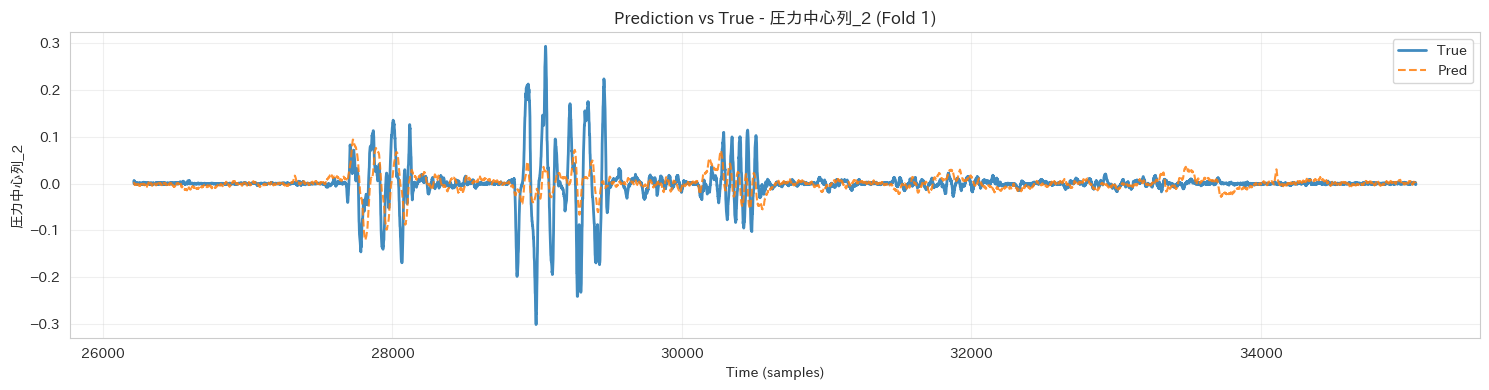

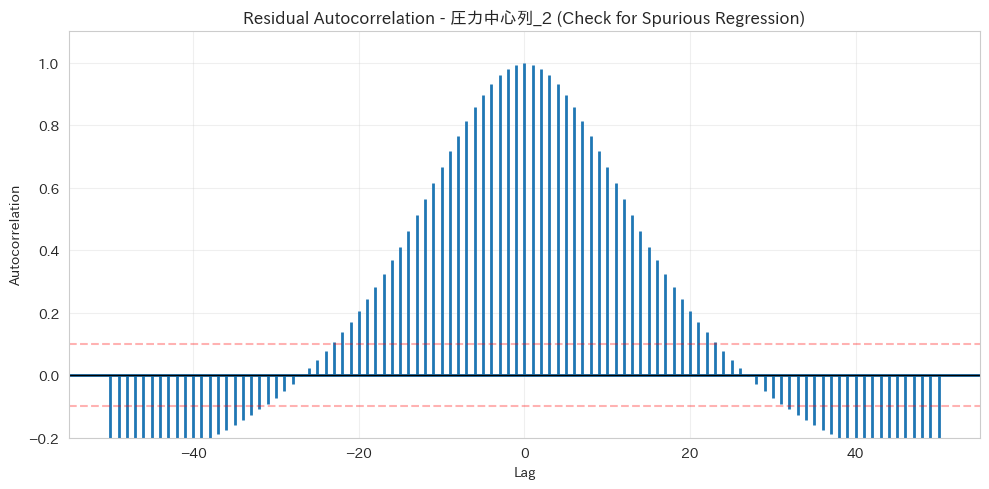

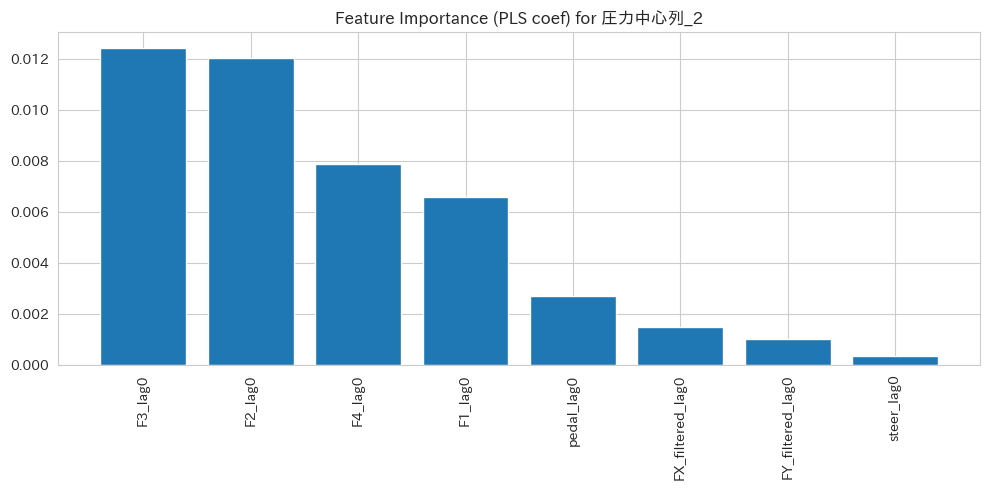

  Target: 荷重(N)_1         | TrainN: 26209 | TestN: 8858  | R2: -0.0026
Unique subject_ids in residual: [7]


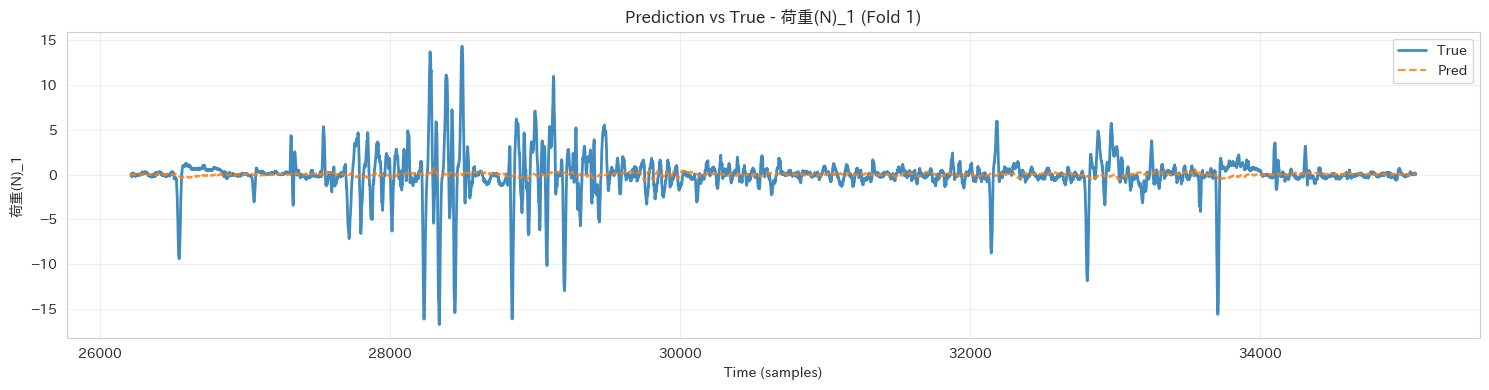

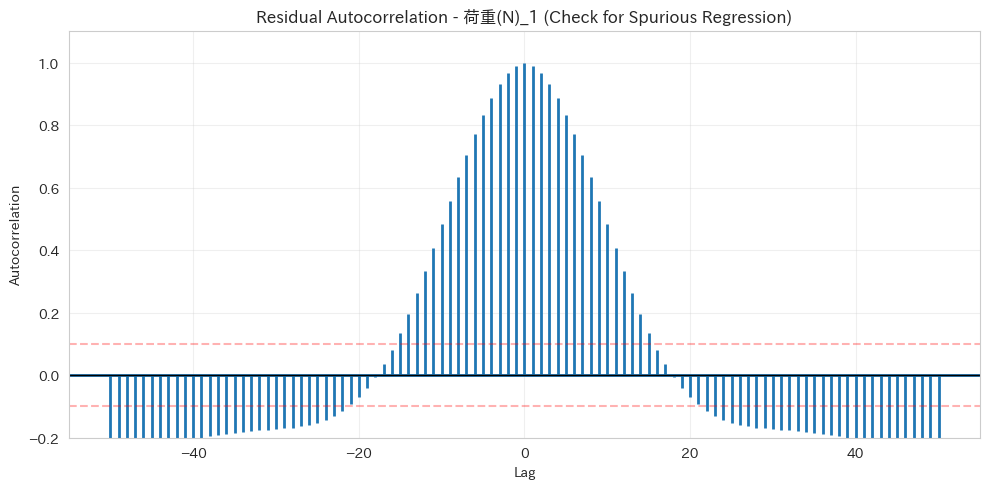

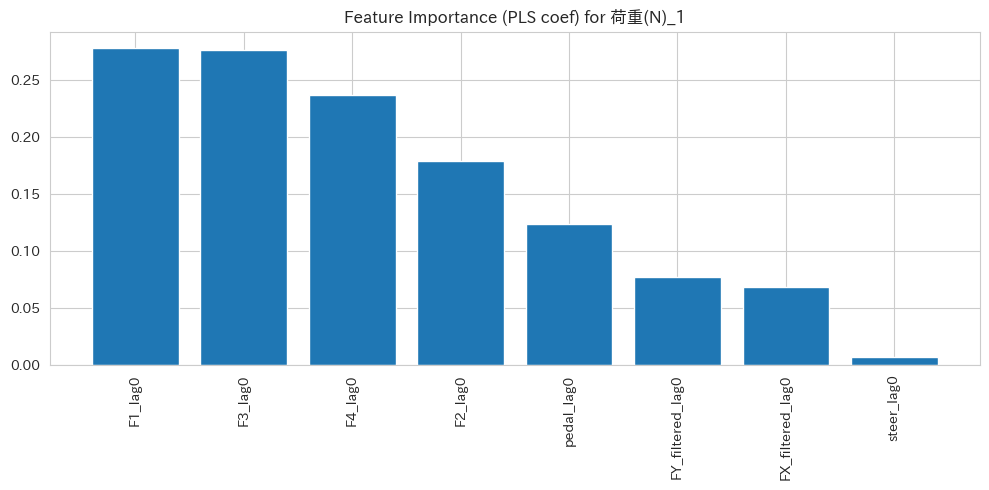

  Target: 圧力中心行_1         | TrainN: 26209 | TestN: 8858  | R2: -0.0024
Unique subject_ids in residual: [7]


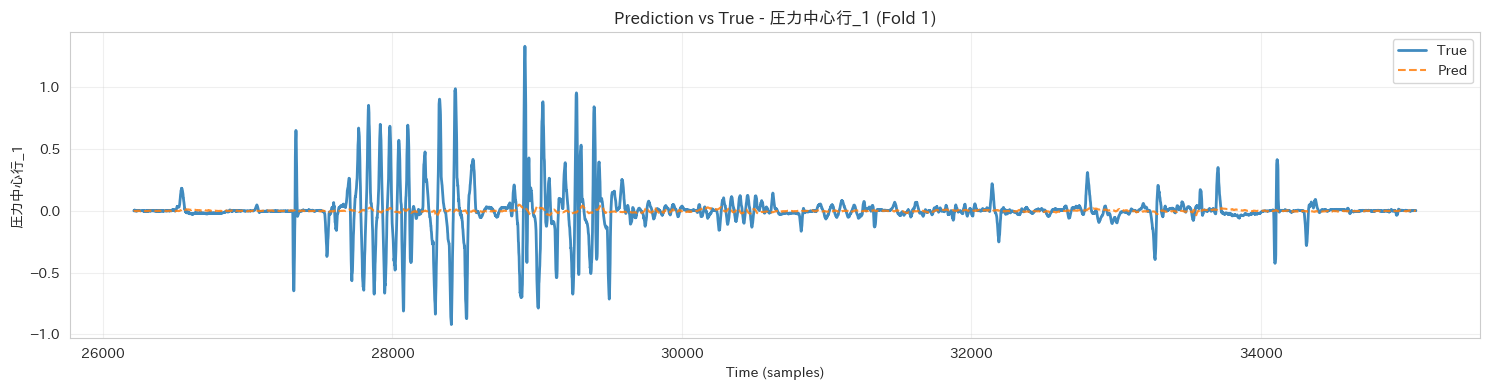

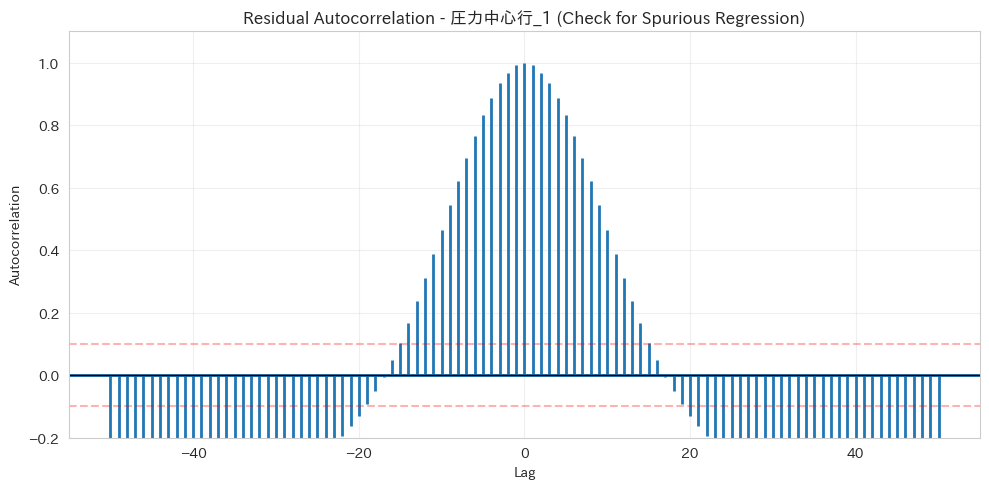

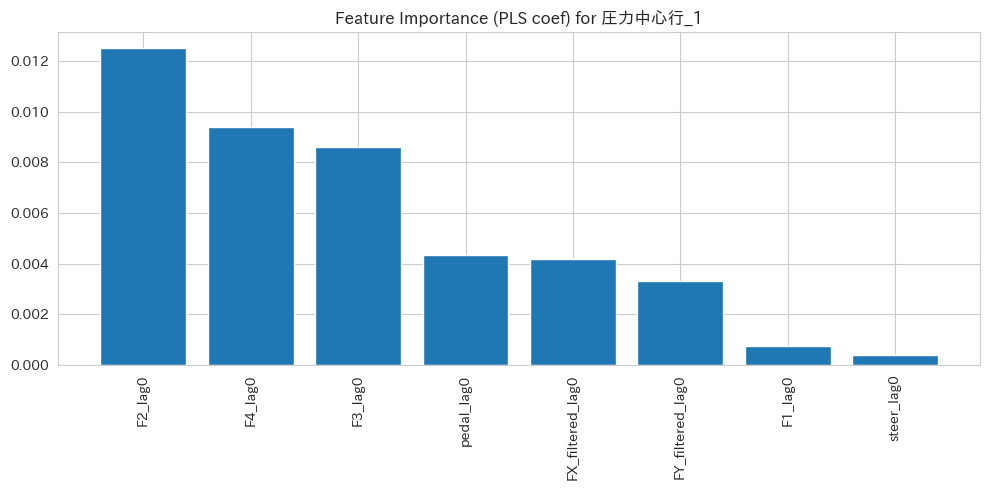

  Target: 圧力中心列_1         | TrainN: 26209 | TestN: 8858  | R2: 0.0643
Unique subject_ids in residual: [7]


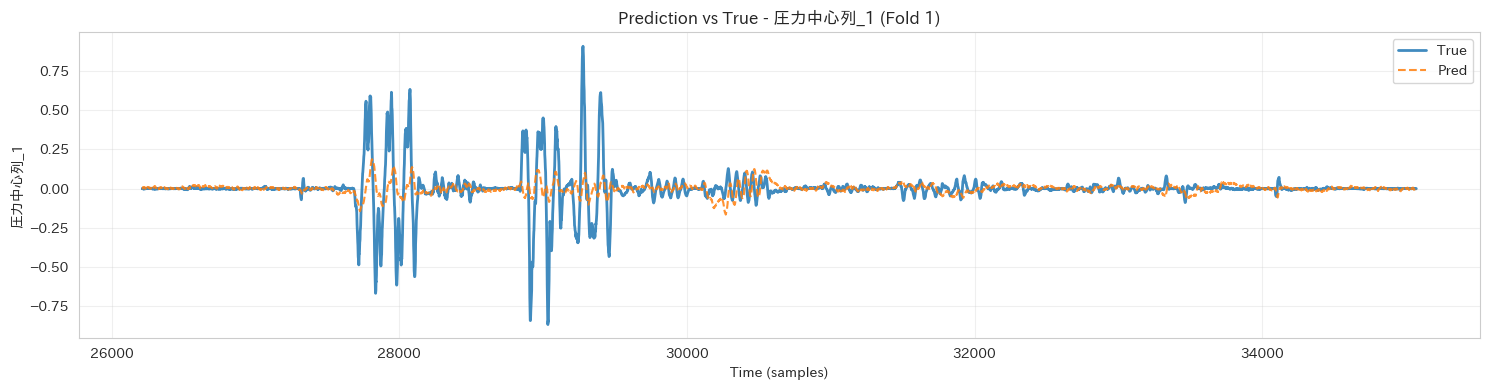

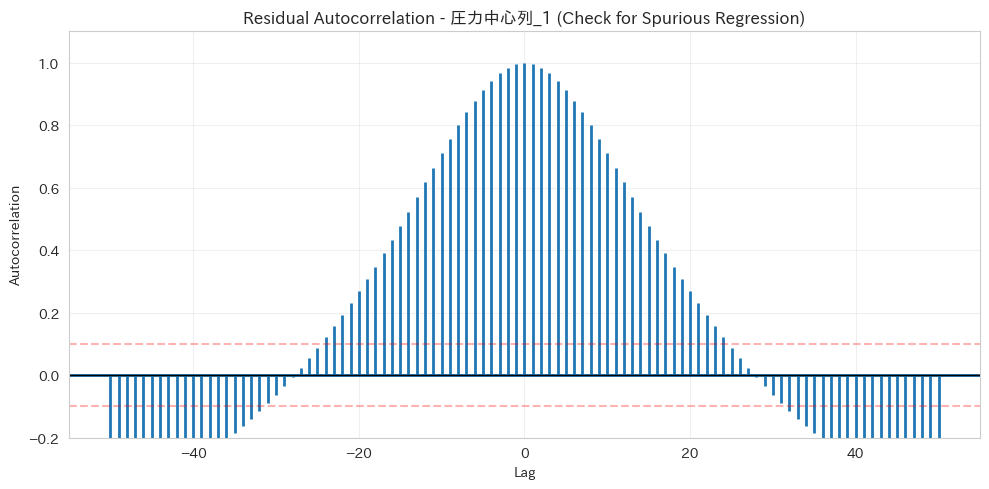

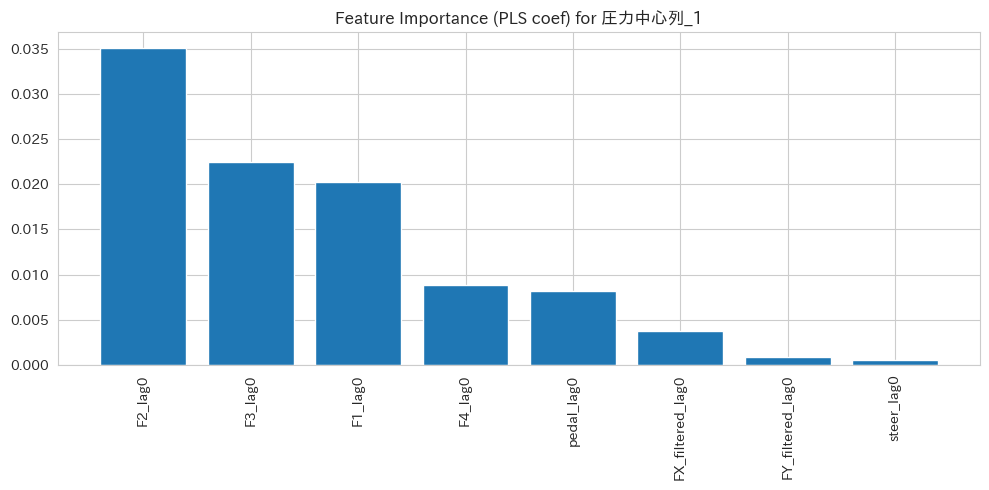

  Target: ピーク圧力_1         | TrainN: 26209 | TestN: 8858  | R2: 0.0023
Unique subject_ids in residual: [7]


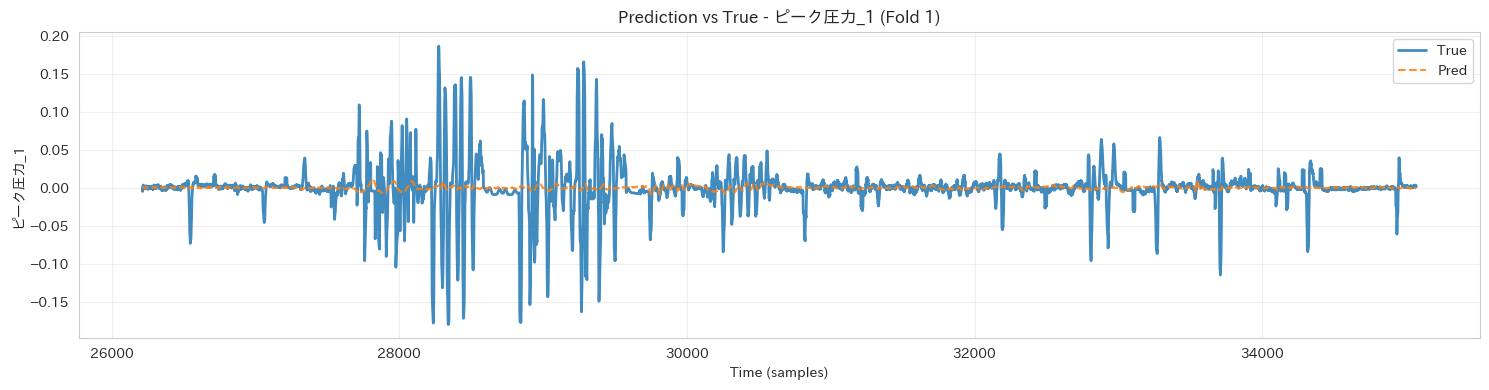

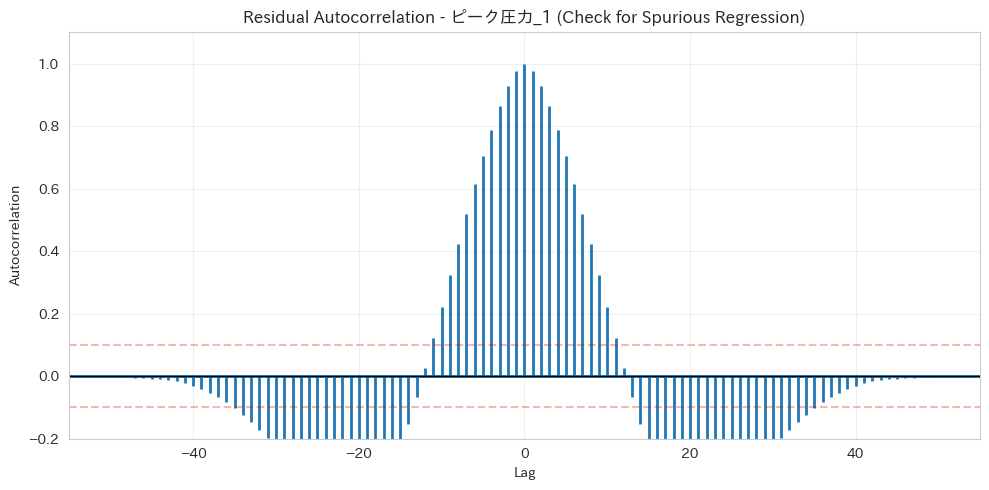

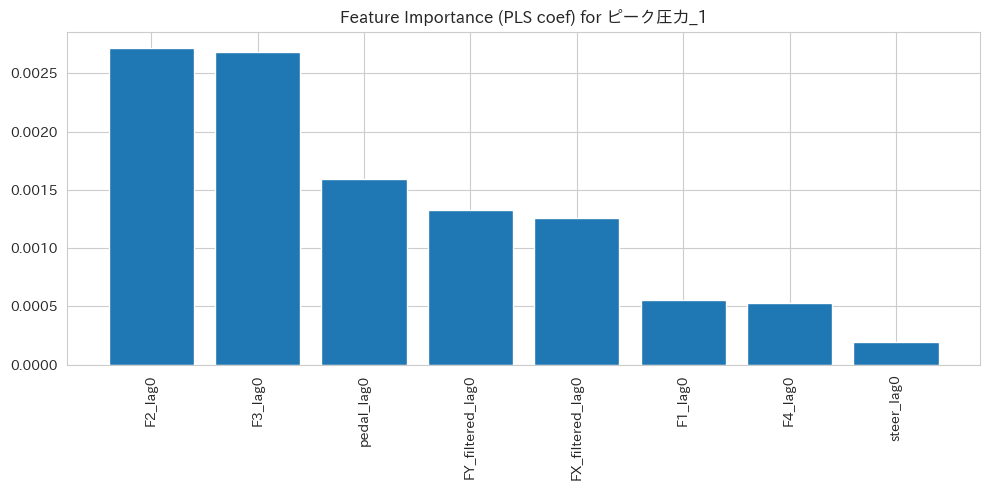

  Target: 接触 %_1          | TrainN: 26209 | TestN: 8858  | R2: -0.0022
Unique subject_ids in residual: [7]


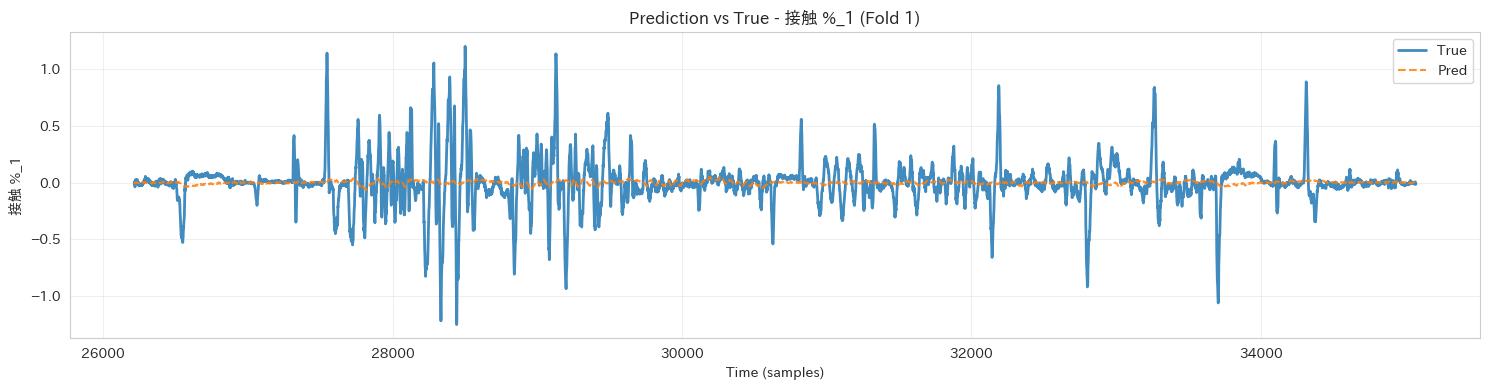

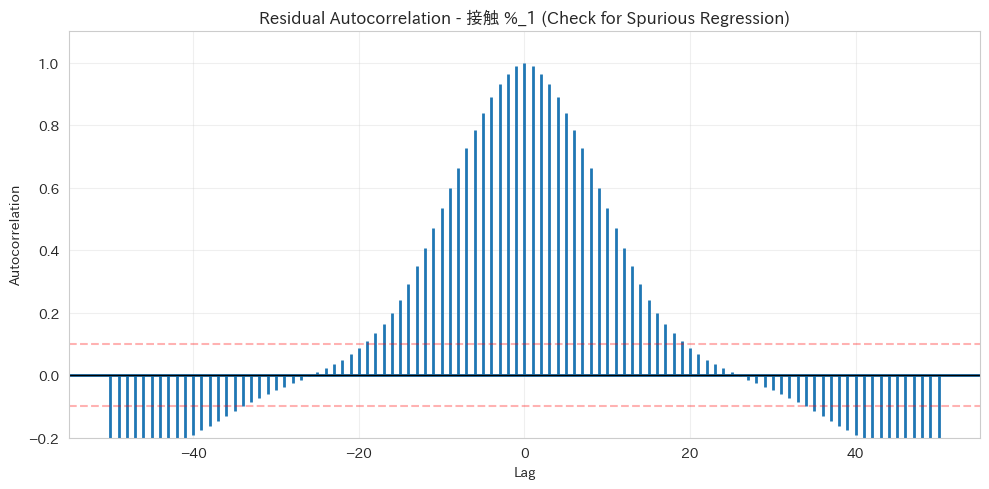

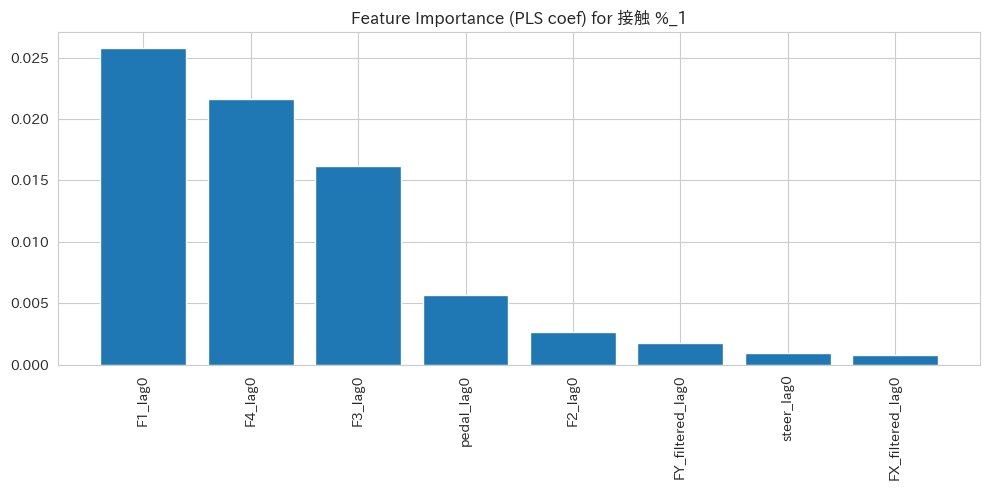

  Target: 接触 %_2          | TrainN: 26209 | TestN: 8858  | R2: 0.0090
Unique subject_ids in residual: [7]


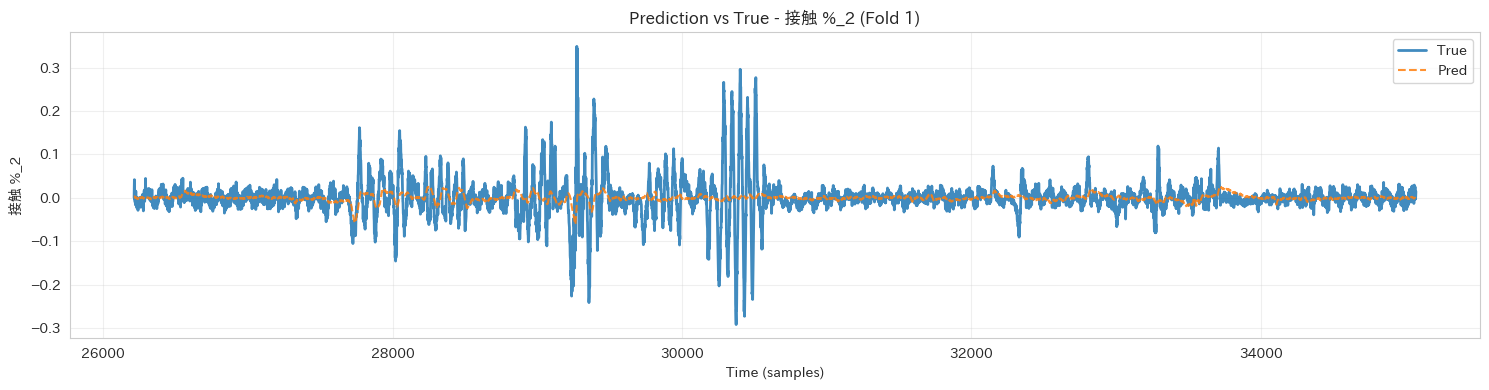

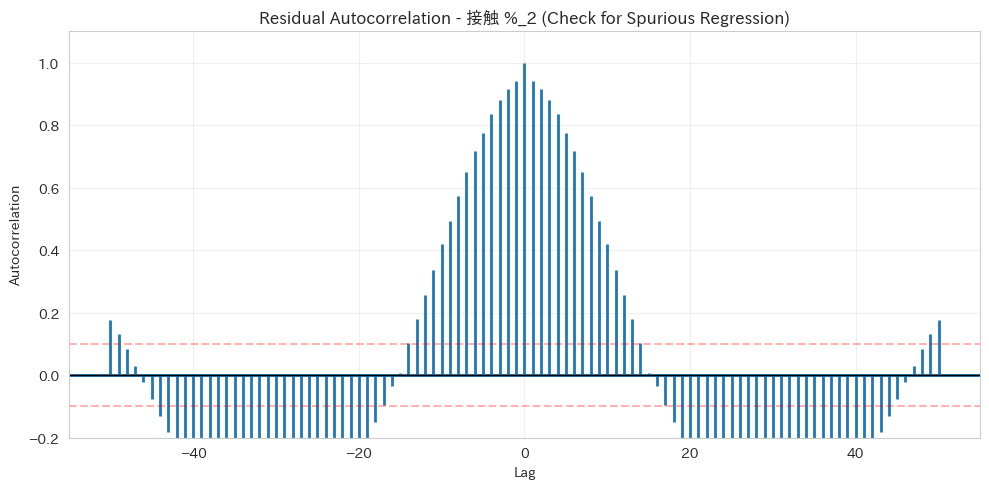

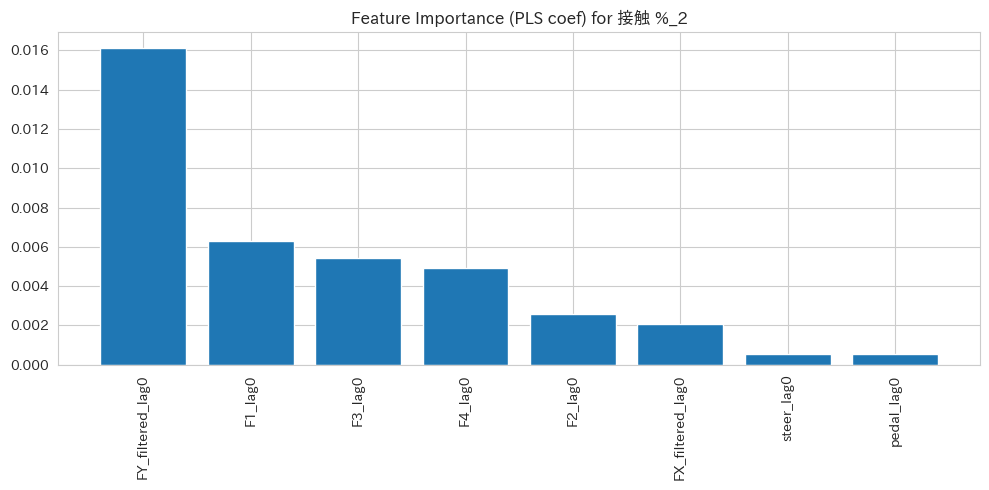

{'圧力中心列_2': [0.09089289859527361],
 '荷重(N)_1': [-0.002602432277207134],
 '圧力中心行_1': [-0.0023689129510073847],
 '圧力中心列_1': [0.06426430380756265],
 'ピーク圧力_1': [0.002263242359825779],
 '接触 %_1': [-0.0021722157330792413],
 '接触 %_2': [0.008985199554646273]}

In [33]:
def run_corrected_pipeline(X_raw, y_raw, scale_y=False, use_diff_target=True, use_ar_features=False, holdout_subject_ids=None):
    """
    holdout_subject_ids (list or int): 
      学習に使わずテスト専用にするsubject_idのリスト。
      Noneの場合は従来の TimeSeriesSplit（時系列分割）を行います。
    """
    
    print("=" * 60)
    if holdout_subject_ids is not None:
        if isinstance(holdout_subject_ids, int): holdout_subject_ids = [holdout_subject_ids]
        print(f"🚀 改良版パイプライン: Hold-out Subject Mode (Test IDs: {holdout_subject_ids})")
        print("   ※ 未知の被験者に対する汎化性能を評価します")
    else:
        print("🚀 改良版パイプライン: TimeSeriesSplit Mode")
        print("   ※ 時系列的な未来予測性能を評価します")
        
    print(f"  - ターゲット差分化 (Δy): {'ON' if use_diff_target else 'OFF'}")
    print(f"  - AR特徴量 (y_lag):    {'ON' if use_ar_features else 'OFF'}")
    print(f"  - Y標準化:             {'ON' if scale_y else 'OFF'}")
    print("=" * 60)

    # 0. 前提チェック
    if 'subject_id' not in X_raw.columns:
        X_raw = X_raw.assign(subject_id=1)
    
    # --- 分割ロジックの切り替え ---
    if holdout_subject_ids is not None:
        # 【新機能】指定IDをテストにする (Trainに含まない)
        # rawデータのindexではなく、行番号(iloc用)を取得する必要がある
        mask_test = X_raw['subject_id'].isin(holdout_subject_ids)
        
        if mask_test.sum() == 0:
            raise ValueError(f"指定されたID {holdout_subject_ids} はデータ内に存在しません。")
        
        train_indices = np.where(~mask_test)[0]
        test_indices  = np.where(mask_test)[0]
        
        # 1回だけの分割としてリスト化 (CVループと互換性を持たせる)
        cv_splits = [(train_indices, test_indices)]
        
    else:
        # 【従来】時系列分割
        tscv = TimeSeriesSplit(n_splits=3)
        cv_splits = tscv.split(X_raw)

    
    # プロセッサ初期化
    smoother = SubjectAwareSmoother(window=15)
    detrender = SubjectAwareDetrender(window=300)
    differencer = SubjectAwareDifferencer()
    
    # ラグ設定
    feature_lags = {'steer→圧力中心列_2': 10,
    'pedal→圧力中心列_2': 40,
    'steer→接触 %_2': 30,
    'pedal→接触 %_2': 70,
    'steer→ピーク圧力_1': 90,
    'pedal→ピーク圧力_1': 80,
    'steer→接触 %_1': 0,
    'pedal→接触 %_1': 40,
    'steer→圧力中心列_1': 10,
    'pedal→圧力中心列_1': 60,
    'steer→荷重(N)_1': 90,
    'pedal→荷重(N)_1': 40,
    'steer→圧力中心行_1': 10,
    'pedal→圧力中心行_1': 10}
    feature_lags = {}
    generator = CausalFeatureGenerator(feature_lags)
    
    # ループ実行 (Hold-outの場合は1回だけ回る)
    all_scores = {col: [] for col in y_raw.columns}
    
    for fold, (train_idx, test_idx) in enumerate(cv_splits):
        print(f"\n--- Fold {fold+1} ---")
        if holdout_subject_ids is not None:
            print("Validation Type: Unknown Subject (Generalization)")
        
        # 1. データ分割
        X_train_raw = X_raw.iloc[train_idx].copy()
        y_train_raw = y_raw.iloc[train_idx].copy()
        X_test_raw = X_raw.iloc[test_idx].copy()
        y_test_raw = y_raw.iloc[test_idx].copy()

        # Detrend用の一時ID付与
        y_train_raw['subject_id'] = X_train_raw['subject_id']
        y_test_raw['subject_id'] = X_test_raw['subject_id']

        # ★重要: Contextの設定
        # Hold-outモードの場合、TrainとTestは「別人」なので連続性がない。
        # そのため、Testの変換時にTrainをContextとして渡してはいけない。
        if holdout_subject_ids is not None:
            X_context_data = None
            y_context_data = None
        else:
            X_context_data = X_train_raw
            y_context_data = y_train_raw

        # ----------------------------------------
        # 2. Preprocessing Flow
        # ----------------------------------------
        # A. Differencing (Diffを最優先)
        if use_diff_target:
            y_train = differencer.transform(y_train_raw)
            y_test  = differencer.transform(y_test_raw, X_context=y_context_data)
        else:
            y_train = y_train_raw.copy()
            y_test = y_test_raw.copy()

        # B. Smoothing
        X_train = smoother.transform(X_train_raw)
        X_test  = smoother.transform(X_test_raw, X_context=X_context_data)
        
        y_train = smoother.transform(y_train)
        y_test  = smoother.transform(y_test, X_context=y_context_data)

        # C. Detrending
        X_train = detrender.transform(X_train)
        X_test  = detrender.transform(X_test, X_context=X_context_data)
        y_train = detrender.transform(y_train)
        y_test  = detrender.transform(y_test, X_context=y_context_data)

        # 3. Feature Generation Loop
        for y_col in [c for c in y_raw.columns if c != 'subject_id']:
            
            # Shift & Lag
            X_train_feats = generator.transform(X_train, y_col)
            X_test_feats = generator.transform(X_test, y_col)
            
            # ID復帰
            X_train_feats['subject_id'] = X_train['subject_id'].values
            X_test_feats['subject_id'] = X_test['subject_id'].values
            
            # Target設定
            y_train_target = y_train[[y_col, 'subject_id']]
            y_test_target = y_test[[y_col, 'subject_id']]

            # D. AR Features
            if use_ar_features:
                X_train_feats = add_ar_features(X_train_feats, y_train_target, lags=[1, 2, 3])
                X_test_feats  = add_ar_features(X_test_feats, y_test_target, lags=[1, 2, 3])

            # DropNa
            common_idx_train = X_train_feats.dropna().index.intersection(y_train_target.dropna().index)
            X_train_clean = X_train_feats.loc[common_idx_train]
            y_train_clean = y_train_target.loc[common_idx_train]
            
            common_idx_test = X_test_feats.dropna().index.intersection(y_test_target.dropna().index)
            X_test_clean = X_test_feats.loc[common_idx_test]
            y_test_clean = y_test_target.loc[common_idx_test]

            if len(X_train_clean) < 100: 
                print(f"Skipping {y_col}: Not enough training data.")
                continue

            # ----------------------------------------------------
            # 5. Standardization
            # ----------------------------------------------------
            scaler_x = SubjectAwareStandardizer()
            scaler_x.fit(X_train_clean)
            
            X_train_final = scaler_x.transform(X_train_clean).drop(columns=['subject_id'], errors='ignore')
            X_test_final  = scaler_x.transform(X_test_clean).drop(columns=['subject_id'], errors='ignore')

            if scale_y:
                scaler_y = SubjectAwareStandardizer()
                scaler_y.fit(y_train_clean)
                y_train_final = scaler_y.transform(y_train_clean).drop(columns=['subject_id'], errors='ignore')
                y_test_final  = scaler_y.transform(y_test_clean).drop(columns=['subject_id'], errors='ignore')
                unit_label = "std (σ)"
            else:
                y_train_final = y_train_clean.drop(columns=['subject_id'], errors='ignore')
                y_test_final  = y_test_clean.drop(columns=['subject_id'], errors='ignore')
                unit_label = "diff/vel" if use_diff_target else "raw"

            # ----------------------------------------------------
            # 6. Modeling & Eval
            # ----------------------------------------------------
            model = SimplePLSModel(n_components=5)
            model.fit(X_train_final, y_train_final)
            
            y_pred_raw = model.predict(X_test_final)
            y_pred = pd.Series(y_pred_raw.flatten(), index=y_test_final.index)
            
            r2 = r2_score(y_test_final, y_pred)
            all_scores[y_col].append(r2)
            
            print(f"  Target: {y_col:<15} | TrainN: {len(X_train_clean):<5} | TestN: {len(X_test_clean):<5} | R2: {r2:.4f}")
            
            # プロット（Hold-outモードなら毎回、CVなら最後だけ）
            is_last_fold = (fold == len(list(cv_splits)) - 1) if not isinstance(cv_splits, list) else True
            
            if holdout_subject_ids is not None or is_last_fold:
                print("Unique subject_ids in residual:", y_test_target['subject_id'].unique())
                plot_prediction_waveform(y_test_final, y_pred, y_col, fold_id=fold+1)
                
                # ★修正済みの残差プロット呼び出し★
                plot_residual_acorrelation(y_test_final, y_pred, y_col)

                # 3. 特徴量重要度プロット（既存）
                feature_names = X_train_final.columns
                plot_feature_importance(model.model, feature_names, y_col)

    return all_scores

# ID: 3 を未知のテストデータとして評価する
mock_sensor_cols = ['F1', 'F2', 'F3', 'F4','FX_filtered','FY_filtered' ,'pedal','steer','subject_id'] 
target_features_A = ['圧力中心列_2', '荷重(N)_1', '圧力中心行_1', '圧力中心列_1','ピーク圧力_1','接触 %_1','接触 %_2']  # 目標圧力変数

# 列が存在するかチェック
available_cols = df_all.columns.tolist()
X_cols = [c for c in mock_sensor_cols if c in available_cols]
Y_cols = [c for c in target_features_A if c in available_cols]
print(f"入力変数(X): {X_cols}")
print(f"出力変数(Y): {Y_cols}")

if len(X_cols) == 0:
    raise ValueError("エラー: モドキセンサの列が見つかりません。列名を修正してください。")
df_raw = df_all[X_cols + Y_cols].dropna()
X_raw = df_raw[X_cols]
y_raw = df_raw[Y_cols]

run_corrected_pipeline(
    X_raw, 
    y_raw, 
    scale_y=False,
    use_diff_target=True, 
    use_ar_features=False,
    holdout_subject_ids=[7]  # ★ここに追加
)